# Pipeline base com PyNILM:  avaliação de Taxa Amostral e Janelas na base REDD

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
%load_ext watermark

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "17") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)

NILMTK -> Detalhes sobre o dataset REDD:


## Preparando Janelas utilizadas no Experimento

Consumo geral dos medidores/aparelhos no período:


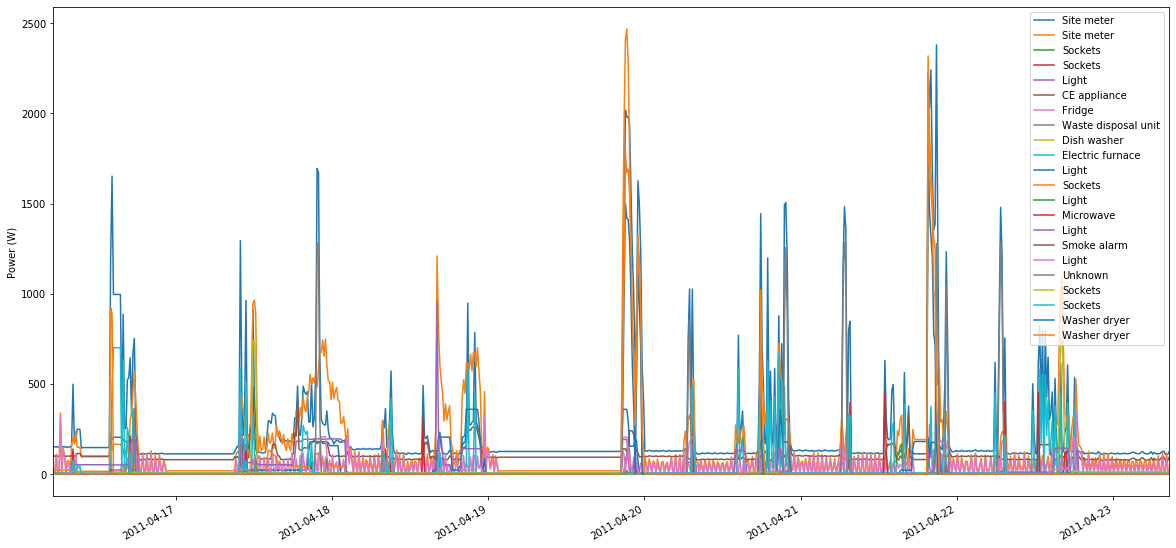

In [4]:
# Teste da classe
janelas = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16 05:11:30',
    fim_intervalo='2011-04-23 08:43:26',
    debug = False
)


# Plots
fig = plt.figure(figsize=(20, 10))
print("Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas.residencia.elec.meters)):
    janelas.residencia.elec.meters[m].plot();

In [5]:
# Extrair series divididas em janelas para cada medidor
# a cada 90 segundos, em uma taxa de 3s
dados_cargas = janelas.preparar(taxa_amostral=3, intervalo_medicao=90)

# Disposicao das janelas preparadas
pprint(dados_cargas)

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.

## Preparando Amostras (medidores residência ) e Rótulos (aparelhos)

In [6]:
# Listando as cargas que possuem janelas preparadas
janelas.lista_cargas(dados_cargas)

[(1, 'site_meter'),
 (2, 'site_meter'),
 (3, 'sockets'),
 (4, 'sockets'),
 (5, 'light'),
 (6, 'ce_appliance'),
 (7, 'fridge'),
 (8, 'waste_disposal_unit'),
 (9, 'dish_washer'),
 (10, 'electric_furnace'),
 (11, 'light'),
 (12, 'sockets'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (15, 'light'),
 (16, 'microwave'),
 (17, 'light'),
 (18, 'smoke_alarm'),
 (19, 'light'),
 (20, 'unknown')]

In [7]:
# Filtrando dados para conjunto de cargas
# NOTA: Os lares norte-americanos têm suprimentos de energia em fase dividida. 
#   Cada divisão é de 120 volts em relação ao neutro. As duas divisões 
#   totalizam 240 volts, por isso os dois 'site_meter'. 
#
#   Além disso, aparelhos que demandam energia (secadora, por exemplo) podem se 
#   conectar a ambas as divisões; na REDD se mede separadamente as duas divisões 
#   para esses tais aparelhos, contemplando no NILMTK dois medidores por 
#   dispositivo de 240 volts.

# Apenas duas fases da corrente eletrica da residencia
dados_medidores = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
print("Dados das janelas de ambos medidores da residência:")
print("---")
pprint(dados_medidores)

print("\n\n")

# Apenas dados de aparelhos da residencia
dados_aparelhos = janelas.filtrar_cargas(
    dados_cargas,
    filtros=[
        (3, 'sockets'),
        (4, 'sockets'),
        (5, 'light'),
        (6, 'ce_appliance'),
        (7, 'fridge'),
        (8, 'waste_disposal_unit'),
        (9, 'dish_washer'),
        (10, 'electric_furnace'),
        (11, 'light'),
        (12, 'sockets'),
        (13, 'washer_dryer'),
        (14, 'washer_dryer'),
        (15, 'light'),
        (16, 'microwave'),
        (17, 'light'),
        (18, 'smoke_alarm'),
        (19, 'light'),
        (20, 'unknown')
    ]
)
print("Dados das janelas dos aparelhos da residência:")
print("---")
pprint(dados_aparelhos)

Dados das janelas de ambos medidores da residência:
---
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[144.82    , 146.66667 , 146.01    , ..., 162.76666 , 160.01666 ,
        153.06667 ],
       [152.77666 , 152.92667 , 153.16333 , ..., 152.35666 , 152.29001 ,
        152.03667 ],
       [152.01    , 152.95334 , 153.31    , ..., 152.32666 , 152.03    ,
        152.45999 ],
       ...,
       [107.815   , 107.939995, 107.86    , ..., 108.13    , 108.130005,
        108.19    ],
       [108.11    , 108.22    , 108.096664, ..., 122.235   , 122.27334 ,
        122.47667 ],
       [122.39667 , 122.57333 , 121.11    , ..., 123.916664, 123.66    ,
        135.86333 ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([147.05612, 153.01077, 152.7641 , ..., 107.80511, 116.91384,
       122.40183], dtype=float32),
              'total': array([4411.6836, 4590.323 , 4582.923 , ..., 3234.1533, 3507.4153,
       3672.055 ], dtype

              'media': array([1.        , 1.        , 1.        , ..., 0.96666664, 0.96666664,
       1.        ], dtype=float32),
              'total': array([30., 30., 30., ..., 29., 29., 30.], dtype=float32)}},
 {'carga': 'unknown',
  'instancia': 20,
  'janelas': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'rotulos': {'estado': array([0, 0, 0, ..., 0, 0, 0]),
              'media': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
              'total': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)}}]


In [8]:

# Janelas do medidores agregados
X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

# Normalizando dados
# X = MinMaxScaler().fit_transform(X.T).T

print("* Dados dos medidores (Amostras / X):")
print("   - Shape:", X.shape)
print("   - Media:", np.mean(X))
print("   - Desvio:", np.std(X))

# Y = irá depender da carga a ser classificada

* Dados dos medidores (Amostras / X):
   - Shape: (6861, 30)
   - Media: 413.0859
   - Desvio: 673.9321


In [9]:
# Verificar apenas janelas válidaso: com medicao total MAIOR QUE ZERO 
# (ou seja, amostras que possuam ao menos uma carga ativa - janelas zeradas
# são INÚTEIS para aprendizado do modelo, além de contribuir para desbalanceamento)
idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
print("* Janelas com TODOS aparelhos desligados: {} (~{:.1f}% das amostras)".format(
    X.shape[0] - len(idx_janelas_validas), 
    ( 1 - (len(idx_janelas_validas)/X.shape[0]) )*100 
))
print()

# AMOSTRAS -> Filtrando apenas JANELAS validas
X = X[idx_janelas_validas]
print("* Amostras validadas (X shape):", X.shape)
print()

# APARELHOS -> Filtrando apenas JANELAS validas
print("* Rotulos (estado) validados:")
for i in range(len(dados_aparelhos)):
    
    dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
    
    rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
    
    dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
    dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
    print("   - `{}-{}`: {} -> {}".format(
        dados_aparelhos[i]["carga"].upper(), dados_aparelhos[i]["instancia"],
        Counter(rotulos["estado"]), 
        Counter(dados_aparelhos[i]["rotulos"]["estado"])
    ))

* Janelas com TODOS aparelhos desligados: 0 (~0.0% das amostras)

* Amostras validadas (X shape): (6861, 30)

* Rotulos (estado) validados:
   - `SOCKETS-3`: Counter({0: 4497, 1: 2364}) -> Counter({0: 4497, 1: 2364})
   - `SOCKETS-4`: Counter({0: 5858, 1: 1003}) -> Counter({0: 5858, 1: 1003})
   - `LIGHT-5`: Counter({0: 6092, 1: 769}) -> Counter({0: 6092, 1: 769})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) -> Counter({1: 6861})
   - `FRIDGE-7`: Counter({1: 5844, 0: 1017}) -> Counter({1: 5844, 0: 1017})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6138, 1: 723}) -> Counter({0: 6138, 1: 723})
   - `DISH_WASHER-9`: Counter({1: 6339, 0: 522}) -> Counter({1: 6339, 0: 522})
   - `ELECTRIC_FURNACE-10`: Counter({1: 6833, 0: 28}) -> Counter({1: 6833, 0: 28})
   - `LIGHT-11`: Counter({0: 5056, 1: 1805}) -> Counter({0: 5056, 1: 1805})
   - `SOCKETS-12`: Counter({0: 4866, 1: 1995}) -> Counter({0: 4866, 1: 1995})
   - `WASHER_DRYER-13`: Counter({0: 6613, 1: 248}) -> Counter({0: 6613, 1: 248})
   - `WAS

In [10]:
# TOP-5 aparelhos com maior consumo
top_aparelhos_consumo = []
for m in janelas.residencia.elec.submeters().select_top_k(5).meters:
    instancia = m.instance()
    carga = m.label().lower().replace(" ","_")
    if type(instancia)==tuple and len(instancia) > 1:
        for i in instancia:
            top_aparelhos_consumo.append((i, carga))
    else:
        top_aparelhos_consumo.append((instancia, carga))
        
print("\n")
print("------------------------------------------------------------------")
print("* Top-5 aparelhos com maior consumo total de energia no intervalo:")
print("------------------------------------------------------------------")
pprint(top_aparelhos_consumo)
print("----------------------------------------------")

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

------------------------------------------------------------------
* Top-5 aparelhos com maior consumo total de energia no intervalo:
------------------------------------------------------------------
[(6, 'ce_appliance'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (7, 'fridge'),
 (10, 'electric_furnace'),
 (17, 'light')]
----------------------------------------------


**Distribuções dos estados (rótulos classificação):**

   - `CE_APPLIANCE-6`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5264}
   - `FRIDGE-7`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 5125, 0: 139}
   - `ELECTRIC_FURNACE-10`: {1: 5236, 0: 28}
   - `WASHER_DRYER-13`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 5018, 1: 246}
   - `WASHER_DRYER-14`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 4945, 1: 319}
   - `LIGHT-17`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 3134, 1: 2130})
   
   
<u>**CONCLUSÕES PARCIAIS:**</u>
1. É possível perceber que o aparelho `CE_APPLIANCE-6` é inviável de treinar nestas configurações, pois há apenas amostras positivas;
2. `LIGHT-17` é o aparelho com melhor equlibrio de amostras, ou seja, possui menor grau de desbalanceamento;
3. De resto, todos os aparelhos possuem grande desbalanceamento; `talvez seja necessário avaliar individualmente o tamanho da janela considerada para cada aparelho`.
    * Corrobora [Fagiani *et. al* (2019)](https://www.mdpi.com/1996-1073/12/7/1371), os quais afirmam que *"(...) geralmente, apesar da tarefa a ser resolvida dependendo da formulação do algoritmo, a precisão da desagregação diminui proporcionalmente com a variação da taxa de amostragem."*

Portanto, vamos considerar avaliar diferentes 'sample rate' em um pipeline de classificação (RP+CNN) comum neste estudo, considerando as cargas de maior consumo.

In [11]:
# Eletrônicos, Luzes, refrigerador, lava loucas, aquecedor, secadora de
# roupas, alarmes de incêndio, equipamentos de banheiro, utensílios de
# cozinha, Micro-ondas, utensílios externos.

In [12]:
# # TOP-5 aparelhos com maior DEMANDA de energia
# df_energia = janelas.residencia.elec.dataframe_of_meters()

# fig = plt.figure(figsize=(20,8))
# cargas = janelas.residencia.elec.get_labels(df_energia.columns)[2:]
# legenda = []
# dados_energia = [] # Lista com estatisticas por caga
# for i, coluna in enumerate(df_energia.columns[2:]):
#     instancia = ""
#     if hasattr(coluna, "instance"):
#         instancia = coluna.instance
#     else:
#         instancia = tuple([m.instance for m in coluna.meters])

#     serie = np.nan_to_num(df_energia[coluna].values)
#     dados_energia.append({
#         "carga": cargas[i],
#         "instancia": instancia,
#         "total": np.sum(serie),
#         "maximo": np.max(serie),
#         "minimo": np.min(serie),
#         "media": np.mean(serie),
#         "desvio": np.std(serie)
#     })
#     legenda.append(f"{cargas[i]}-{str(instancia)}")
#     plt.plot(np.arange(df_energia.shape[0]), serie)
# plt.legend(legenda);
# plt.title("Consumo por Dispositivo dentro do Intervalo")
# plt.show();

# sorted(dados_energia, key=lambda k: k['maximo'], reverse=False) 

## Transformar Séries (Janelas) em Imagens

In [397]:

# fig, axes = plt.subplots(1,4, figsize=(20,5))

# axes[0].plot(np.arange(len(X[3])), X[3])
# axes[0].set_title("Série Original (Janela)")
# # axes[0].grid(False)

# # RPs
# X_rp = RecurrencePlot().fit_transform(X)
# axes[1].imshow(X_rp[3], cmap="plasma");
# axes[1].set_title("RP")
# axes[1].grid(False)

# # GASF
# X_gasf = GramianAngularField(method="summation").fit_transform(X)
# axes[2].imshow(X_gasf[3], cmap="plasma");
# axes[2].set_title("GASF")
# axes[2].grid(False)

# # GASF
# X_gadf = GramianAngularField(method="difference").fit_transform(X)
# axes[3].imshow(X_gadf[3], cmap="plasma");
# axes[3].set_title("GADF")
# axes[3].grid(False)

# # # MTF
# # X_mtf = MarkovTransitionField().fit_transform(X[np.where(np.sum(X, axis=1)>0)[0]])
# # plt.imshow(X_mtf[3], cmap="plasma");
# # plt.title("MTF")
# # plt.grid(False)
# # plt.show()
# plt.show()

# # Gerando imagens RGB N canais
# X_imagem = np.stack([X_rp, X_gasf, X_gadf], axis=-1)
# print("* Shape da matriz de amostras:", X_imagem.shape)

# Modelagem

In [9]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot
import cv2

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
TAMANHO_IMAGEM = (32, 32) # Apenas 1 canal
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
def convnet(
    input_shape_ = (30, 30, 1), 
    output_dim=6, 
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'softmax'
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation=output_activation))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

# GPUs habilitadas: 1 física(s) / 1 lógica(s)


In [10]:
# Verificando caracteristicas de funcionamento dos aparelhos
def repeticao_maxima_valor(vetor, valor = True):
    mask = np.concatenate(([False], vetor == valor,[False]))
    if ~mask.any():
        return 0
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        return (idx[1::2] - idx[::2]).max()
    
print("* Verificando caracteristicas de funcionamento dos aparelhos:")
print()
min_on, max_on = [], []
min_off, max_off = [], []

janelas = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16 05:11:30',
    fim_intervalo='2011-04-23 08:43:26',
    debug = False
)

for e in janelas.residencia.elec.meters:
    status = when_on = next(e.when_on())
    intervalo_maximo_on = repeticao_maxima_valor(status, True)
    intervalo_maximo_off = repeticao_maxima_valor(status, False)
    print(" -", e.label()+" - "+str(e.instance())+":")
    print("   -> ON (acionado) = Duração mínima:", e.min_on_duration(), "/ Duração máxima:", intervalo_maximo_on)
    print("   -> OFF (desligado) = Duração mínima:", e.min_off_duration(), "/ Duração máxima:", intervalo_maximo_off)
    
    min_on.append(e.min_on_duration())
    max_on.append(intervalo_maximo_on)
    
    min_off.append(e.min_off_duration())
    max_off.append(intervalo_maximo_off)
    print()
    
print()
print("-----")
print("Resultados:")
print()
print("* Periodos ON:")
print("  -> Mínimo:", sorted(list(set(min_on))))
print("  -> Máximo:", sorted(list(set(max_on))))
print()
print("* Periodos OFF:")
print("  -> Mínimo:", sorted(list(set(min_off))))
print("  -> Máximo:", sorted(list(set(max_off))))

* Verificando caracteristicas de funcionamento dos aparelhos:

 - Site meter - 1:
   -> ON (acionado) = Duração mínima: 0 / Duração máxima: 427679
   -> OFF (desligado) = Duração mínima: 0 / Duração máxima: 0

 - Site meter - 2:
   -> ON (acionado) = Duração mínima: 0 / Duração máxima: 427679
   -> OFF (desligado) = Duração mínima: 0 / Duração máxima: 0

 - Sockets - 3:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 167
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 40923

 - Sockets - 4:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 1
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 58563

 - Light - 5:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 232
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 82835

 - CE appliance - 6:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 120365
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 0

 - Fridge - 7:
   -> ON (acionado) = Duração mínima: 20

In [27]:
# Intervalos possiveis (de acordo com funcionamento das cargas)
janelas_avaliacao = np.array(sorted(list(set(min_on+max_on))))

# Janelas de avaliações consideradas na otimização
janelas_avaliacao = janelas_avaliacao[np.where( (janelas_avaliacao > 5) & (janelas_avaliacao <= 2347))[0]]
janelas_avaliacao

array([  20,   45,  167,  232,  264,  283,  566,  600,  622, 1315, 1996,
       2347], dtype=int64)

In [15]:
# Executar otimização (espaço de busca taxa / janela)
DEBUG = True

if not os.path.isfile(os.path.join(caminho_dados_notebook, 'resultados_taxa-amostragem_janelas.csv')):
    # Cenarios de avaliacao:
    # ---
    resultados = {
        "carga": [],
        "taxa_amostragem": [],
        "janela": [],
        "loss": [],
        "acuracia": [],
        "precisao": [],
        "recall": [],
        "f1": [],
        "f1_macro": []
    }

    # Intervalo de tempo e residencia considerados na base REDD
    janelas = Janelas(
        base=redd,
        id_residencia=3,
        inicio_intervalo='2011-04-16 05:11:30',
        fim_intervalo='2011-04-23 08:43:26',
        debug = False
    )

    # Testar diferentes taxas de amostragem
    taxas_amostragem = [3,4,5,8]
    for taxa in taxas_amostragem:
        
        for janela in [30, 60, 90, 180, 360, 540, 720, 900, 1080]: # nao foi possivel devido ao limite modelo/GPU
#         for janela in janelas_avaliacao:
            
            janela = int(janela)
            print()
            print("-="*10, f"AMOSTRAGEM `{taxa}s` / JANELA `{janela}`", "=-"*10)
            print()

            # Extrair series divididas em janelas para cada medidor
            if DEBUG: print("* Preparando dados das janelas para a taxa de amostragem...")
            # TODO: corrigir output com counter duplicados
            dados_cargas = janelas.preparar(
                taxa_amostral = taxa, 
                intervalo_medicao= janela 
            )
            if DEBUG: print()

            # Apenas duas fases da corrente eletrica da residencia
            if DEBUG: print("* Dividindo cargas entre medidores (mains) e aparelhos...")
            dados_medidores = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (1, 'site_meter'),
                    (2, 'site_meter'),    
                ]
            )
            # Apenas dados de aparelhos da residencia
            dados_aparelhos = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (3, 'sockets'),
                    (4, 'sockets'),
                    (5, 'light'),
                    (6, 'ce_appliance'),
                    (7, 'fridge'),
                    (8, 'waste_disposal_unit'),
                    (9, 'dish_washer'),
                    (10, 'electric_furnace'),
                    (11, 'light'),
                    (12, 'sockets'),
                    (13, 'washer_dryer'),
                    (14, 'washer_dryer'),
                    (15, 'light'),
                    (16, 'microwave'),
                    (17, 'light'),
                    (18, 'smoke_alarm'),
                    (19, 'light'),
                    (20, 'unknown')
                ]
            )

            # <<< Limpando memoria >>>
            dados_cargas = None
            del dados_cargas
            gc.collect()
            # <<< Limpando memoria >>>

            if DEBUG: print()

            # Gerar matriz de amostras do modelo (X) e preparar rotulos Y (estado das cargas)
            if DEBUG: print("* Preparando amostras e rótulos...")

            # Validar tamanho dos dados de medidores (podem ter mais registros que os aparelhos)
            janela_media_medidores = int(np.sum([len(d["janelas"])for d in dados_medidores])/len(dados_medidores))
            janela_media_aparelhos = int(np.sum([len(d["janelas"])for d in dados_aparelhos])/len(dados_aparelhos))

            # Ajustando para medidores terem o mesmo shape de janelas dos aparelhos 
            if janela_media_medidores > janela_media_aparelhos:
                diferenca = janela_media_medidores-janela_media_aparelhos
                if DEBUG: print("  -> Diferenca encontrada entre medidores/aparelhos:", diferenca, ", ajustando..")
                for i in range(len(dados_medidores)):
                    removidos = 0
                    while removidos < diferenca:
                        # Remover ultima janela
                        dados_medidores[i]["janelas"] = dados_medidores[i]["janelas"][:-1,:]
                        removidos += 1


            X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

            # <<< Limpando memoria >>>
            dados_medidores = None
            del dados_medidores
            gc.collect()
            # <<< Limpando memoria >>>

            # Normalizacao dos dados (DESUSO)
            #X = MinMaxScaler().fit_transform(X.T).T # Normalizando dados

            # Selecionando apenas janelas VALIDAS (ocorrencia de ao menos 1 carga)
            # TODO: Implementar na biblioteca esta rotina de validacao
            idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
            X = X[idx_janelas_validas]
            for i in range(len(dados_aparelhos)):
                dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
                rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
                dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
                if DEBUG:
                    print("   - `{}-{}`: {} => {}".format(
                        dados_aparelhos[i]["carga"].upper(), 
                        dados_aparelhos[i]["instancia"],
                        Counter(rotulos["estado"]),
                        Counter(dados_aparelhos[i]["rotulos"]["estado"])
                    ))
            if DEBUG: print()

            ################### PRÉ-PROCESSAMENTO DAS IMAGENS ###################
            # TODO: Implamentar na PyNILM

            # Transformacao das series/janelas em imagens (RPs)...
            if DEBUG: print("* Transformando séries (amostras) em imagens...");print()
            X_imagem = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)

            # <<< Limpando memoria >>>
            X = None
            del X
            gc.collect()

            # DEBUG: Plotar imagens
            #X_imagem_original = X_imagem[0].astype(np.float32)

            # Redimensionando imagem (de acordo com o definido, considerando 
            # apenas 1 CANAL - complexidade computacional)
            if DEBUG: print("* Redimensionando imagens {} -> {}".format(X_imagem[0].shape, TAMANHO_IMAGEM));print()
            X_imagem = np.stack([
                [cv2.resize(
                    imagem, 
                    dsize=TAMANHO_IMAGEM, 
                    interpolation=cv2.INTER_CUBIC).astype(np.float16) \
                    for imagem in tqdm_notebook(X_imagem)]
            ], axis=-1).astype(np.float16) 


            ## DEBUG: Plotar imagens
            #print(" - X_imagem shape processado:", X_imagem.shape)
            #fig, axes = plt.subplots(1,2,figsize=(15,15))
            #axes[0].imshow(X_imagem_original, cmap='viridis')
            #axes[0].set_title("Imagem original (Shape = {})".format(X_imagem_original.shape))
            #axes[0].grid(False)
            #X_imagem_resized = cv2.resize(X_imagem_original, dsize=TAMANHO_IMAGEM, interpolation=cv2.INTER_CUBIC)
            #axes[1].imshow(X_imagem[0,:,:,0].astype(np.float32), cmap='viridis')
            #axes[1].set_title("Imagem redimensionada (Shape = {})".format(X_imagem_resized.shape))
            #axes[1].grid(False)
            #plt.show()

            ################### PRÉ-PROCESSAMENTO DAS IMAGENS ###################
            if DEBUG: print("  -> Shape da matriz de amostras:", X_imagem.shape); print()

            # Loop sobre TODOS os aparelhos (binarios, parametros similares estudo ja feito)
            if DEBUG: print("* Avaliando modelos binários para cada um dos aparelhos, aguarde..."); print()
            for aparelho in dados_aparelhos:
                caminho_persistencia_resultados = os.path.join(
                    caminho_imagens_notebook, 
                    'taxa-{}_janela-{}_{}'.format(
                        taxa, janela, f'{aparelho["carga"]}-{aparelho["instancia"]}' 
                    )
                )
                if not os.path.isdir(caminho_persistencia_resultados):
                    try:
                        print("-"*50)
                        print()

                        y = aparelho["rotulos"]["estado"]

                        if DEBUG: print(f"_ Dados do aparelho `{aparelho['carga'].upper()} - {aparelho['instancia']}` (Y / rótulo:)")
                        if DEBUG: print("   - ", Counter(y)); print()

                        # Split de treino / teste
                        if DEBUG: print("_ Treinando o modelo classificador de estados...")

                        estratificacao = y
                        # Ver se é inviavel estratificacao
                        for v in Counter(y).values():
                            if v == 1:
                                estratificacao = None
                                break
                        X_treino, X_teste, y_treino, y_teste = train_test_split(
                            X_imagem, y,
                            test_size=FRACAO_TESTE,
                            stratify=estratificacao,
                            random_state=SEED
                        )

                        # Treinando modelo
                        modelo = convnet(
                            input_shape_= X_imagem[0,:,:].shape,
                            output_dim = 1,
                            loss_function='binary_crossentropy',
                            metrics=['accuracy'],
                            output_activation='sigmoid'
                        )

                        historico = modelo.fit(
                            X_treino, y_treino,
                            validation_data=(X_teste, y_teste),
                            epochs=EPOCAS,
                            batch_size=TAMANHO_LOTE,
                            verbose=VERBOSIDADE
                        )

                        print()

                        # Resultados do modelo
                        r = modelo.evaluate(X_teste, y_teste)
                              
                        # TODO: implementar opção de apenas salvar imagens na pasta
                        #   do notebook ao inves de exibi-las no IPython notebook
                        #   padrao -> os.path.join(CAMINHO_IMAGENS_NOTEBOOK, 'taxa-{}.janela-{}_convergencia-loss.png'.format(taxa, janela))
                        # ---                 
                        # Avaliando modelo
                        relatorio_classificacao_aparelho(
                            modelo, X_teste, y_teste, 
                            f'{aparelho["carga"]} - {aparelho["instancia"]}',
                            caminho_persistencia=caminho_persistencia_resultados
                        )
                                                   
                        # Considerando resultados adicionais da analise
                        df_resultados = pd.read_csv(
                            os.path.join(
                                caminho_persistencia_resultados,
                                "resultados_analise.csv"
                            )
                        )
                              
                        # Incluindo dados no dataframe
                        resultados["carga"].append(f'{aparelho["carga"]} - {aparelho["instancia"]}')
                        resultados["taxa_amostragem"].append(taxa)
                        resultados["janela"].append(janela)
                        resultados["loss"].append(r[0])
                        resultados["acuracia"].append(r[1])
                        resultados["precisao"].append(df_resultados["Precisão"].values[0])
                        resultados["recall"].append(df_resultados["Recall"].values[0])
                        resultados["f1"].append(df_resultados["F1-score"].values[0])
                        resultados["f1_macro"].append(df_resultados["F1-macro"].values[0])
                                                   
                        # Persistindo o log individual do modelo (backup)
                        if not os.path.isdir(os.path.join(caminho_persistencia_resultados)):
                            os.makedirs(caminho_persistencia_resultados)
                        with open(os.path.join(caminho_persistencia_resultados, "resultados_modelo.log"), "w") as log:
                            log.write(
                                "{},{},{},{},{}".format(
                                    f'{aparelho["carga"]} - {aparelho["instancia"]}',
                                    taxa,
                                    janela,
                                    r[0],
                                    r[1]
                                )
                            )
                              
                        print()

                    except Exception as e:
                        print(f" !# Não foi possível treinar o modelo para a combinação de taxa `{str(taxa)}` / janela `{str(janela)}`: {str(e)}")
                else:
                    print(f" !# Modelo já treinado para a combinação de carga `{aparelho['carga']}-{aparelho['instancia']}` / taxa `{str(taxa)}` / janela `{str(janela)}`")
                    print()
                          
                    # Considerando resultados adicionais da analise
                    df_resultados = pd.read_csv(
                        os.path.join(
                            caminho_persistencia_resultados,
                            "resultados_analise.csv"
                        ),
                    )
                                               
                    # Lendo resultados dos logs
                    with open(os.path.join(caminho_persistencia_resultados, "resultados_modelo.log"), "r") as log:
                        dados = log.readlines()[0].split(',')
                        resultados["carga"].append(dados[0])
                        resultados["taxa_amostragem"].append(int(dados[1]))
                        resultados["janela"].append(int(dados[2]))
                        resultados["loss"].append(float(dados[3]))
                        resultados["acuracia"].append(round(float(dados[4]),7))
                        resultados["precisao"].append(df_resultados["Precisão"].values[0])
                        resultados["recall"].append(df_resultados["Recall"].values[0])
                        resultados["f1"].append(df_resultados["F1-score"].values[0])
                        resultados["f1_macro"].append(df_resultados["F1-macro"].values[0])

            # <<< Limpando memoria >>>
            X_imagem = None
            del X_imagem
            dados_aparelhos = None
            del dados_aparelhos
            gc.collect()
            # <<< Limpando memoria >>>

            print()

    # Exportar resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"))
                              
else:
    print("####################################")
    print(f"#          A T E N Ç Ã O           #")
    print("####################################")
    print("\nExecução já realizada anteriormente.")
    print(f"\nOs resultados estão disponíveis no arquivo \n`{os.path.join(caminho_dados_notebook,'resultados_taxa-amostragem_janelas.csv')}`")
    print("\n####################################")


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 6791, 1: 70}) => Counter({0: 6791, 1: 70})
   - `SOCKETS-4`: Counter({0: 6861}) => Counter({0: 6861})
   - `LIGHT-5`: Counter({0: 6846, 1: 15}) => Counter({0: 6846, 1: 15})
   - `CE_APPLIANCE-6`: Counter({1: 6861}) => Counter({1: 6861})
   - `FRIDGE-7`: Counter({0: 4752, 1: 2109}) => Counter({0: 4752, 1: 2109})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 6851, 1: 10}) => Counter({0: 6851, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 6775, 1: 86}) => Counter({0: 6775, 1: 86})
   - `ELECTRIC_FURNACE-10`: Counter({0: 6525, 1: 336}) => Counter({0: 6525, 1: 336})
   - `LIGHT-11`: Counter({0: 5328, 1: 1533}) 


  -> Shape da matriz de amostras: (6861, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 6791, 1: 70})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.00 - ETA: 0s - loss: 0.0265 - accuracy: 0.98 - ETA: 0s - loss: 0.0460 - accuracy: 0.98 - 0s 83us/sample - loss: 0.0393 - accuracy: 0.9889
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.72
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1698.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.0265e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.1233e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.0701e-09 - accuracy: 1.00 - 0s 89us/sample - loss: 1.0493e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1716.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 6846, 1: 15})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.6050e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.1759 - accuracy: 0.9963   - ETA: 0s - loss: 0.1144 - accuracy: 0.99 - 0s 92us/sample - loss: 0.0793 - accuracy: 0.9965
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1712.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 6861})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 9.4139e-10 - accuracy: 1.00 - ETA: 0s - loss: 1.0852e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.0221e-09 - accuracy: 1.00 - 0s 87us/sample - loss: 1.0137e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1716.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4752, 1: 2109})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.87 - ETA: 0s - loss: 0.4523 - accuracy: 0.77 - ETA: 0s - loss: 0.4734 - accuracy: 0.76 - 0s 84us/sample - loss: 0.4662 - accuracy: 0.7628
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,76.28
Precisão,58.75
Recall,76.47
F1-score,66.45
F1-macro,74.05
Hamming Loss,0.24
AUC,0.76
Suporte (y=0),1189.00
Suporte (y=1),527.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 6851, 1: 10})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 1.4124e-04 - accuracy: 1.00 - ETA: 0s - loss: 9.2594e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0338 - accuracy: 0.9992   - 0s 87us/sample - loss: 0.0337 - accuracy: 0.9983
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1713.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 6775, 1: 86})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 1.00 - ETA: 0s - loss: 0.0781 - accuracy: 0.98 - ETA: 0s - loss: 0.1025 - accuracy: 0.98 - ETA: 0s - loss: 0.0994 - accuracy: 0.98 - 0s 99us/sample - loss: 0.0971 - accuracy: 0.9848
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.48
Precisão,16.67
Recall,4.55
F1-score,7.14
F1-macro,53.19
Hamming Loss,0.02
AUC,0.52
Suporte (y=0),1694.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 6525, 1: 336})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 1.00 - ETA: 0s - loss: 0.1610 - accuracy: 0.95 - ETA: 0s - loss: 0.1727 - accuracy: 0.95 - 0s 87us/sample - loss: 0.1722 - accuracy: 0.9499
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.99
Precisão,37.50
Recall,3.57
F1-score,6.52
F1-macro,51.97
Hamming Loss,0.05
AUC,0.52
Suporte (y=0),1632.00
Suporte (y=1),84.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 5328, 1: 1533})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.81 - ETA: 0s - loss: 0.3749 - accuracy: 0.84 - ETA: 0s - loss: 0.3867 - accuracy: 0.83 - 0s 85us/sample - loss: 0.3830 - accuracy: 0.8386
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,83.86
Precisão,64.40
Recall,61.88
F1-score,63.12
F1-macro,76.39
Hamming Loss,0.16
AUC,0.76
Suporte (y=0),1333.00
Suporte (y=1),383.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 5706, 1: 1155})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.81 - ETA: 0s - loss: 0.4059 - accuracy: 0.84 - ETA: 0s - loss: 0.3916 - accuracy: 0.83 - 0s 89us/sample - loss: 0.3838 - accuracy: 0.8339
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.39
Precisão,55.88
Recall,6.57
F1-score,11.76
F1-macro,51.30
Hamming Loss,0.17
AUC,0.53
Suporte (y=0),1427.00
Suporte (y=1),289.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6722, 1: 139})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.96 - ETA: 0s - loss: 0.0787 - accuracy: 0.98 - ETA: 0s - loss: 0.0756 - accuracy: 0.98 - 0s 84us/sample - loss: 0.0687 - accuracy: 0.9872
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.72
Precisão,72.41
Recall,60.00
F1-score,65.62
F1-macro,82.49
Hamming Loss,0.01
AUC,0.80
Suporte (y=0),1681.00
Suporte (y=1),35.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6651, 1: 210})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 1.00 - ETA: 0s - loss: 0.0689 - accuracy: 0.98 - ETA: 0s - loss: 0.1077 - accuracy: 0.97 - 0s 85us/sample - loss: 0.0988 - accuracy: 0.9784
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.84
Precisão,76.67
Recall,43.40
F1-score,55.42
F1-macro,77.16
Hamming Loss,0.02
AUC,0.71
Suporte (y=0),1663.00
Suporte (y=1),53.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 6859, 1: 2})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 2.3274e-07 - accuracy: 1.00 - ETA: 0s - loss: 2.7798e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0707 - accuracy: 0.9991   - 0s 91us/sample - loss: 0.0476 - accuracy: 0.9994
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 6797, 1: 64})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.00 - ETA: 0s - loss: 0.0630 - accuracy: 0.99 - ETA: 0s - loss: 0.0686 - accuracy: 0.99 - 0s 81us/sample - loss: 0.0691 - accuracy: 0.9907
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1700.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 4835, 1: 2026})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.84 - ETA: 0s - loss: 0.4641 - accuracy: 0.81 - ETA: 0s - loss: 0.5252 - accuracy: 0.81 - 0s 85us/sample - loss: 0.5827 - accuracy: 0.8124
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.24
Precisão,71.97
Recall,59.76
F1-score,65.30
F1-macro,76.22
Hamming Loss,0.19
AUC,0.75
Suporte (y=0),1209.00
Suporte (y=1),507.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 6857, 1: 4})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.00 - ETA: 0s - loss: 0.0026 - accuracy: 1.00 - ETA: 0s - loss: 0.7923 - accuracy: 0.99 - 0s 85us/sample - loss: 0.5914 - accuracy: 0.9994
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.94
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.99
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1715.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 5474, 1: 1387})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.87 - ETA: 0s - loss: 0.3299 - accuracy: 0.85 - ETA: 0s - loss: 0.3455 - accuracy: 0.85 - 0s 89us/sample - loss: 0.3532 - accuracy: 0.8514
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,85.14
Precisão,65.03
Recall,57.35
F1-score,60.95
F1-macro,75.89
Hamming Loss,0.15
AUC,0.75
Suporte (y=0),1369.00
Suporte (y=1),347.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 6588, 1: 273})

_ Treinando o modelo classificador de estados...

1716/1716 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 1.00 - ETA: 0s - loss: 0.1480 - accuracy: 0.96 - ETA: 0s - loss: 0.1828 - accuracy: 0.95 - 0s 84us/sample - loss: 0.1756 - accuracy: 0.9598
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.98
Precisão,33.33
Recall,1.47
F1-score,2.82
F1-macro,50.38
Hamming Loss,0.04
AUC,0.51
Suporte (y=0),1648.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 3393, 1: 37}) => Counter({0: 3393, 1: 37})
   - `SOCKETS-4`: Counter({0: 3430}) => Counter({0: 3430})
   - `LIGHT-5`: Counter({0: 3422, 1: 8}) => Counter({0: 3422, 1: 8})
   - `CE_APPLIANCE-6`: Counter({1: 3430}) => Counter({1: 3430})
   - `FRIDGE-7`: Counter({0: 2250, 1: 1180}) => Counter({0: 2250, 1: 1180})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3420, 1: 10}) => Counter({0: 3420, 1: 10})
   - `DISH_WASHER-9`: Counter({0: 3385, 1: 45}) => Counter({0: 3385, 1: 45})
   - `ELECTRIC_FURNACE-1


  -> Shape da matriz de amostras: (3430, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 3393, 1: 37})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.96 - ETA: 0s - loss: 0.0169 - accuracy: 0.99 - 0s 91us/sample - loss: 0.0910 - accuracy: 0.9895
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.95
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),849.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.2348e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.7309e-09 - accuracy: 1.00 - 0s 85us/sample - loss: 1.9863e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),858.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 3422, 1: 8})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 1.00 - ETA: 0s - loss: 0.2555 - accuracy: 0.99 - 0s 109us/sample - loss: 0.1625 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),856.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 3430})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 1.2941e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.2780e-09 - accuracy: 1.00 - 0s 91us/sample - loss: 1.2911e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),858.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2250, 1: 1180})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.68 - ETA: 0s - loss: 0.6050 - accuracy: 0.74 - 0s 93us/sample - loss: 0.5564 - accuracy: 0.7529
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,75.29
Precisão,60.89
Recall,78.64
F1-score,68.64
F1-macro,74.13
Hamming Loss,0.25
AUC,0.76
Suporte (y=0),563.00
Suporte (y=1),295.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 3420, 1: 10})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 5.1046e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.1226 - accuracy: 0.9953   - 0s 86us/sample - loss: 0.0917 - accuracy: 0.9965
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),855.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3385, 1: 45})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.93 - ETA: 0s - loss: 0.1066 - accuracy: 0.98 - 0s 87us/sample - loss: 0.1158 - accuracy: 0.9837
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.37
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.59
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3247, 1: 183})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 1.00 - ETA: 0s - loss: 0.1592 - accuracy: 0.94 - 0s 89us/sample - loss: 0.1659 - accuracy: 0.9441
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.41
Precisão,33.33
Recall,4.35
F1-score,7.69
F1-macro,52.40
Hamming Loss,0.06
AUC,0.52
Suporte (y=0),812.00
Suporte (y=1),46.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 2657, 1: 773})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.78 - ETA: 0s - loss: 0.6622 - accuracy: 0.79 - 0s 98us/sample - loss: 0.5938 - accuracy: 0.8007
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.07
Precisão,57.14
Recall,45.60
F1-score,50.72
F1-macro,69.11
Hamming Loss,0.20
AUC,0.68
Suporte (y=0),665.00
Suporte (y=1),193.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2851, 1: 579})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.87 - ETA: 0s - loss: 0.4305 - accuracy: 0.81 - 0s 93us/sample - loss: 0.4515 - accuracy: 0.8054
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,80.54
Precisão,39.42
Recall,28.28
F1-score,32.93
F1-macro,60.77
Hamming Loss,0.19
AUC,0.60
Suporte (y=0),713.00
Suporte (y=1),145.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3355, 1: 75})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 1.00 - ETA: 0s - loss: 0.0244 - accuracy: 0.99 - 0s 92us/sample - loss: 0.0377 - accuracy: 0.9907
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.07
Precisão,100.00
Recall,57.89
F1-score,73.33
F1-macro,86.43
Hamming Loss,0.01
AUC,0.79
Suporte (y=0),839.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3323, 1: 107})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 1.00 - ETA: 0s - loss: 0.0806 - accuracy: 0.97 - 0s 95us/sample - loss: 0.0796 - accuracy: 0.9790
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.90
Precisão,80.00
Recall,44.44
F1-score,57.14
F1-macro,78.03
Hamming Loss,0.02
AUC,0.72
Suporte (y=0),831.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 3428, 1: 2})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 3.2708e-25 - accuracy: 1.00 - ETA: 0s - loss: 23.4712 - accuracy: 0.9984   - 0s 92us/sample - loss: 17.5077 - accuracy: 0.9988
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3386, 1: 44})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.96 - ETA: 0s - loss: 0.1268 - accuracy: 0.98 - 0s 92us/sample - loss: 0.1106 - accuracy: 0.9825
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),847.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2382, 1: 1048})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.87 - ETA: 0s - loss: 0.4515 - accuracy: 0.84 - 0s 95us/sample - loss: 0.5064 - accuracy: 0.8298
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,82.98
Precisão,77.10
Recall,62.98
F1-score,69.33
F1-macro,78.78
Hamming Loss,0.17
AUC,0.77
Suporte (y=0),596.00
Suporte (y=1),262.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 3426, 1: 4})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - ETA: 0s - loss: 5.2355 - accuracy: 0.99 - 0s 116us/sample - loss: 2.3439 - accuracy: 0.9988
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.97
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),857.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2710, 1: 720})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.84 - ETA: 0s - loss: 0.4900 - accuracy: 0.82 - 0s 93us/sample - loss: 0.4505 - accuracy: 0.8275
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.75
Precisão,57.62
Recall,67.22
F1-score,62.05
F1-macro,75.44
Hamming Loss,0.17
AUC,0.77
Suporte (y=0),678.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3280, 1: 150})

_ Treinando o modelo classificador de estados...

858/858 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 1.00 - ETA: 0s - loss: 0.1621 - accuracy: 0.95 - 0s 92us/sample - loss: 0.1555 - accuracy: 0.9580
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.80
Precisão,100.00
Recall,5.26
F1-score,10.00
F1-macro,53.93
Hamming Loss,0.04
AUC,0.53
Suporte (y=0),820.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 2262, 1: 25}) => Counter({0: 2262, 1: 25})
   - `SOCKETS-4`: Counter({0: 2287}) => Counter({0: 2287})
   - `LIGHT-5`: Counter({0: 2281, 1: 6}) => Counter({0: 2281, 1: 6})
   - `CE_APPLIANCE-6`: Counter({1: 2287}) => Counter({1: 2287})
   - `FRIDGE-7`: Counter({0: 1430, 1: 857}) => Counter({0: 1430, 1: 857})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 2278, 1: 9}) => Counter({0: 2278, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 2255, 1: 32}) => Counter({0: 2255, 1: 32})
   - `ELECTRIC_FURNACE-10`: 


  -> Shape da matriz de amostras: (2287, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 2262, 1: 25})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 5.1055e-10 - accuracy: 1.00 - 0s 91us/sample - loss: 0.2315 - accuracy: 0.9860
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.60
Precisão,40.00
Recall,66.67
F1-score,50.00
F1-macro,74.65
Hamming Loss,0.01
AUC,0.83
Suporte (y=0),566.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 2287})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 1.8437e-08 - accuracy: 1.00 - 0s 85us/sample - loss: 1.6531e-08 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),572.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 2281, 1: 6})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 5.1726e-16 - accuracy: 1.00 - 0s 91us/sample - loss: 1.4040 - accuracy: 0.9948
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.48
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.87
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),570.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 2287})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 4.2118e-10 - accuracy: 1.00 - 0s 89us/sample - loss: 4.3497e-10 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),572.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1430, 1: 857})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.7777 - accuracy: 0.78 - 0s 89us/sample - loss: 0.7665 - accuracy: 0.8024
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,80.24
Precisão,71.13
Recall,79.44
F1-score,75.06
F1-macro,79.35
Hamming Loss,0.20
AUC,0.80
Suporte (y=0),358.00
Suporte (y=1),214.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 2278, 1: 9})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 2.5627e-04 - accuracy: 1.00 - 0s 92us/sample - loss: 0.0815 - accuracy: 0.9965
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),570.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2255, 1: 32})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 1.00 - 0s 91us/sample - loss: 0.1307 - accuracy: 0.9843
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.43
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.60
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),564.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 2152, 1: 135})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.93 - 0s 89us/sample - loss: 0.2186 - accuracy: 0.9283
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,92.83
Precisão,11.11
Recall,2.94
F1-score,4.65
F1-macro,50.46
Hamming Loss,0.07
AUC,0.51
Suporte (y=0),538.00
Suporte (y=1),34.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1764, 1: 523})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.78 - 0s 92us/sample - loss: 0.4382 - accuracy: 0.8024
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.24
Precisão,56.43
Recall,60.31
F1-score,58.30
F1-macro,72.68
Hamming Loss,0.20
AUC,0.73
Suporte (y=0),441.00
Suporte (y=1),131.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1899, 1: 388})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.78 - 0s 92us/sample - loss: 0.6086 - accuracy: 0.8199
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.99
Precisão,44.44
Recall,24.74
F1-score,31.79
F1-macro,60.71
Hamming Loss,0.18
AUC,0.59
Suporte (y=0),475.00
Suporte (y=1),97.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2235, 1: 52})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 1.00 - 0s 103us/sample - loss: 0.3253 - accuracy: 0.9860
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.60
Precisão,85.71
Recall,46.15
F1-score,60.00
F1-macro,79.64
Hamming Loss,0.01
AUC,0.73
Suporte (y=0),559.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 2214, 1: 73})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 1.00 - 0s 94us/sample - loss: 0.0999 - accuracy: 0.9825
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.25
Precisão,90.00
Recall,50.00
F1-score,64.29
F1-macro,81.69
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),554.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 2285, 1: 2})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 6.1909e-05 - accuracy: 1.00 - 0s 94us/sample - loss: 1.6511 - accuracy: 0.9983
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),571.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2255, 1: 32})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 1.3745e-04 - accuracy: 1.00 - 0s 91us/sample - loss: 0.2710 - accuracy: 0.9860
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.60
Precisão,50.00
Recall,25.00
F1-score,33.33
F1-macro,66.31
Hamming Loss,0.01
AUC,0.62
Suporte (y=0),564.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1568, 1: 719})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.81 - 0s 91us/sample - loss: 0.6173 - accuracy: 0.7727
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.27
Precisão,66.89
Recall,55.00
F1-score,60.37
F1-macro,72.22
Hamming Loss,0.23
AUC,0.71
Suporte (y=0),392.00
Suporte (y=1),180.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 2283, 1: 4})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 4.0588e-07 - accuracy: 1.00 - 0s 91us/sample - loss: 0.1517 - accuracy: 0.9983
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.83
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),571.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1792, 1: 495})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.75 - 0s 89us/sample - loss: 0.4324 - accuracy: 0.8636
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,86.36
Precisão,68.55
Recall,68.55
F1-score,68.55
F1-macro,79.92
Hamming Loss,0.14
AUC,0.80
Suporte (y=0),448.00
Suporte (y=1),124.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 2183, 1: 104})

_ Treinando o modelo classificador de estados...

572/572 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 1.00 - 0s 92us/sample - loss: 0.4560 - accuracy: 0.9353
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.53
Precisão,21.05
Recall,15.38
F1-score,17.78
F1-macro,57.21
Hamming Loss,0.06
AUC,0.56
Suporte (y=0),546.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1129, 1: 14}) => Counter({0: 1129, 1: 14})
   - `SOCKETS-4`: Counter({0: 1143}) => Counter({0: 1143})
   - `LIGHT-5`: Counter({0: 1140, 1: 3}) => Counter({0: 1140, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 1143}) => Counter({1: 1143})
   - `FRIDGE-7`: Counter({0: 595, 1: 548}) => Counter({0: 595, 1: 548})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1134, 1: 9}) => Counter({0: 1134, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 1125, 1: 18}) => Counter({0: 1125, 1: 18})
   - `ELECTRIC_FURNACE-10`: C


  -> Shape da matriz de amostras: (1143, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 1129, 1: 14})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 2.8391 - accuracy: 0.96 - 0s 105us/sample - loss: 0.7203 - accuracy: 0.9755
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,97.55
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.38
Hamming Loss,0.02
AUC,0.49
Suporte (y=0),282.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1143})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 5.2690e-07 - accuracy: 1.00 - 0s 115us/sample - loss: 5.9177e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),286.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1140, 1: 3})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.00 - 0s 101us/sample - loss: 0.0673 - accuracy: 0.9965
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),285.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1143})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 3.9280e-08 - accuracy: 1.00 - 0s 108us/sample - loss: 4.3950e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),286.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 595, 1: 548})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.84 - 0s 101us/sample - loss: 0.4170 - accuracy: 0.8916
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,89.16
Precisão,90.15
Recall,86.86
F1-score,88.48
F1-macro,89.12
Hamming Loss,0.11
AUC,0.89
Suporte (y=0),149.00
Suporte (y=1),137.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1134, 1: 9})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.96 - 0s 101us/sample - loss: 0.2980 - accuracy: 0.9895
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,98.95
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),284.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1125, 1: 18})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.96 - 0s 101us/sample - loss: 0.2522 - accuracy: 0.9825
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),281.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1056, 1: 87})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.87 - 0s 101us/sample - loss: 0.4464 - accuracy: 0.9266
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,92.66
Precisão,55.56
Recall,22.73
F1-score,32.26
F1-macro,64.19
Hamming Loss,0.07
AUC,0.61
Suporte (y=0),264.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 873, 1: 270})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.84 - 0s 119us/sample - loss: 1.6809 - accuracy: 0.7972
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.72
Precisão,60.87
Recall,41.18
F1-score,49.12
F1-macro,68.23
Hamming Loss,0.20
AUC,0.66
Suporte (y=0),218.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 948, 1: 195})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.81 - 0s 108us/sample - loss: 0.6802 - accuracy: 0.8287
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.87
Precisão,50.00
Recall,2.04
F1-score,3.92
F1-macro,47.26
Hamming Loss,0.17
AUC,0.51
Suporte (y=0),237.00
Suporte (y=1),49.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1115, 1: 28})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.96 - 0s 105us/sample - loss: 0.3101 - accuracy: 0.9790
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.90
Precisão,55.56
Recall,71.43
F1-score,62.50
F1-macro,80.71
Hamming Loss,0.02
AUC,0.85
Suporte (y=0),279.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1104, 1: 39})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.93 - 0s 105us/sample - loss: 0.4983 - accuracy: 0.9720
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.20
Precisão,62.50
Recall,50.00
F1-score,55.56
F1-macro,77.06
Hamming Loss,0.03
AUC,0.74
Suporte (y=0),276.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1141, 1: 2})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 2.4928e-04 - accuracy: 1.00 - 0s 112us/sample - loss: 0.0012 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),285.0
Suporte (y=1),1.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1119, 1: 24})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - 0s 112us/sample - loss: 0.0884 - accuracy: 0.9825
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.25
Precisão,100.00
Recall,16.67
F1-score,28.57
F1-macro,63.84
Hamming Loss,0.02
AUC,0.58
Suporte (y=0),280.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 764, 1: 379})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 1.3157 - accuracy: 0.75 - 0s 104us/sample - loss: 0.8584 - accuracy: 0.7762
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.62
Precisão,81.63
Recall,42.11
F1-score,55.56
F1-macro,70.30
Hamming Loss,0.22
AUC,0.69
Suporte (y=0),191.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1139, 1: 4})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.00 - 0s 122us/sample - loss: 3.5783 - accuracy: 0.9965
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.91
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),285.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 873, 1: 270})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.84 - 0s 98us/sample - loss: 0.5851 - accuracy: 0.8252
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.52
Precisão,66.67
Recall,52.94
F1-score,59.02
F1-macro,73.95
Hamming Loss,0.17
AUC,0.72
Suporte (y=0),218.00
Suporte (y=1),68.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1081, 1: 62})

_ Treinando o modelo classificador de estados...

286/286 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.96 - 0s 101us/sample - loss: 0.2991 - accuracy: 0.9301
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.01
Precisão,25.00
Recall,12.50
F1-score,16.67
F1-macro,56.51
Hamming Loss,0.07
AUC,0.55
Suporte (y=0),270.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 562, 1: 9}) => Counter({0: 562, 1: 9})
   - `SOCKETS-4`: Counter({0: 571}) => Counter({0: 571})
   - `LIGHT-5`: Counter({0: 569, 1: 2}) => Counter({0: 569, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 571}) => Counter({1: 571})
   - `FRIDGE-7`: Counter({1: 365, 0: 206}) => Counter({1: 365, 0: 206})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 562, 1: 9}) => Counter({0: 562, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 560, 1: 11}) => Counter({0: 560, 1: 11})
   - `ELECTRIC_FURNACE-10`: Counter({0: 511


  -> Shape da matriz de amostras: (571, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 562, 1: 9})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 14.1518 - accuracy: 0.968 - 0s 146us/sample - loss: 3.1917 - accuracy: 0.9860
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),141.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 571})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 5.2172e-07 - accuracy: 1.00 - 0s 146us/sample - loss: 4.8159e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),143.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 569, 1: 2})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 1.00 - 0s 146us/sample - loss: 0.5581 - accuracy: 0.9930
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),142.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 571})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 1.7058e-06 - accuracy: 1.00 - 0s 133us/sample - loss: 1.5746e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),143.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 365, 0: 206})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.93 - 0s 153us/sample - loss: 1.0865 - accuracy: 0.9021
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,90.21
Precisão,94.25
Recall,90.11
F1-score,92.13
F1-macro,89.59
Hamming Loss,0.10
AUC,0.90
Suporte (y=0),52.00
Suporte (y=1),91.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 562, 1: 9})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 12.0152 - accuracy: 0.968 - 0s 132us/sample - loss: 2.8783 - accuracy: 0.9790
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,97.90
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),141.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 560, 1: 11})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.90 - 0s 141us/sample - loss: 0.5009 - accuracy: 0.9650
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.50
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.11
Hamming Loss,0.03
AUC,0.49
Suporte (y=0),140.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 511, 1: 60})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - 0s 146us/sample - loss: 0.3700 - accuracy: 0.8951
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,89.51
Precisão,50.00
Recall,6.67
F1-score,11.76
F1-macro,53.09
Hamming Loss,0.10
AUC,0.53
Suporte (y=0),128.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 428, 1: 143})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.81 - 0s 153us/sample - loss: 0.8851 - accuracy: 0.8042
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.42
Precisão,61.76
Recall,58.33
F1-score,60.00
F1-macro,73.52
Hamming Loss,0.20
AUC,0.73
Suporte (y=0),107.00
Suporte (y=1),36.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 470, 1: 101})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.75 - 0s 138us/sample - loss: 0.9010 - accuracy: 0.7972
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,79.72
Precisão,16.67
Recall,4.00
F1-score,6.45
F1-macro,47.54
Hamming Loss,0.20
AUC,0.50
Suporte (y=0),118.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 554, 1: 17})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 7.8300 - accuracy: 0.90 - 0s 126us/sample - loss: 4.9147 - accuracy: 0.9650
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.50
Precisão,40.00
Recall,50.00
F1-score,44.44
F1-macro,71.32
Hamming Loss,0.03
AUC,0.74
Suporte (y=0),139.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 550, 1: 21})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.93 - 0s 139us/sample - loss: 0.5386 - accuracy: 0.9510
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.10
Precisão,33.33
Recall,40.00
F1-score,36.36
F1-macro,66.91
Hamming Loss,0.05
AUC,0.69
Suporte (y=0),138.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 569, 1: 2})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - 0s 153us/sample - loss: 1.9835 - accuracy: 0.9930
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.82
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),142.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 551, 1: 20})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 4.3322 - accuracy: 0.96 - 0s 124us/sample - loss: 2.5332 - accuracy: 0.9650
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,96.50
Precisão,50.00
Recall,40.00
F1-score,44.44
F1-macro,71.32
Hamming Loss,0.03
AUC,0.69
Suporte (y=0),138.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 366, 1: 205})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 1.7770 - accuracy: 0.65 - 0s 139us/sample - loss: 1.0087 - accuracy: 0.7483
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,74.83
Precisão,75.86
Recall,43.14
F1-score,55.00
F1-macro,68.76
Hamming Loss,0.25
AUC,0.68
Suporte (y=0),92.00
Suporte (y=1),51.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 567, 1: 4})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.00 - 0s 130us/sample - loss: 2.5477 - accuracy: 0.9860
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),142.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 420, 1: 151})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.84 - 0s 132us/sample - loss: 1.2242 - accuracy: 0.7832
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,78.32
Precisão,73.33
Recall,28.95
F1-score,41.51
F1-macro,64.10
Hamming Loss,0.22
AUC,0.63
Suporte (y=0),105.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 534, 1: 37})

_ Treinando o modelo classificador de estados...

143/143 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.87 - 0s 139us/sample - loss: 0.4647 - accuracy: 0.9231
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,92.31
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.00
Hamming Loss,0.08
AUC,0.49
Suporte (y=0),134.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 375, 1: 6}) => Counter({0: 375, 1: 6})
   - `SOCKETS-4`: Counter({0: 381}) => Counter({0: 381})
   - `LIGHT-5`: Counter({0: 379, 1: 2}) => Counter({0: 379, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 381}) => Counter({1: 381})
   - `FRIDGE-7`: Counter({1: 290, 0: 91}) => Counter({1: 290, 0: 91})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 372, 1: 9}) => Counter({0: 372, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 372, 1: 9}) => Counter({0: 372, 1: 9})
   - `ELECTRIC_FURNACE-10`: Counter({0: 332, 1:


  -> Shape da matriz de amostras: (381, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 375, 1: 6})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.96 - 0s 114us/sample - loss: 0.6200 - accuracy: 0.9688
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,96.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.21
Hamming Loss,0.03
AUC,0.49
Suporte (y=0),94.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 381})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 4.6057e-07 - accuracy: 1.00 - 0s 139us/sample - loss: 8.0600e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),96.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 379, 1: 2})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 7.4146e-06 - accuracy: 1.00 - 0s 135us/sample - loss: 2.6773 - accuracy: 0.9896
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,98.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),95.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 381})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 1.6058e-06 - accuracy: 1.00 - 0s 135us/sample - loss: 2.8101e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),96.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 290, 0: 91})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 1.00 - 0s 123us/sample - loss: 0.2956 - accuracy: 0.9583
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,95.83
Precisão,97.26
Recall,97.26
F1-score,97.26
F1-macro,94.28
Hamming Loss,0.04
AUC,0.94
Suporte (y=0),23.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 372, 1: 9})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - 0s 125us/sample - loss: 6.7223 - accuracy: 0.9792
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,97.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),94.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 372, 1: 9})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.00 - 0s 125us/sample - loss: 1.9183 - accuracy: 0.9792
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),94.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 332, 1: 49})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 1.6476 - accuracy: 0.87 - 0s 135us/sample - loss: 0.8113 - accuracy: 0.9062
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,90.62
Precisão,66.67
Recall,50.00
F1-score,57.14
F1-macro,75.94
Hamming Loss,0.09
AUC,0.73
Suporte (y=0),84.00
Suporte (y=1),12.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 282, 1: 99})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.75 - 0s 125us/sample - loss: 2.4831 - accuracy: 0.7500
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,75.00
Precisão,52.63
Recall,40.00
F1-score,45.45
F1-macro,64.62
Hamming Loss,0.25
AUC,0.64
Suporte (y=0),71.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 312, 1: 69})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 1.7308 - accuracy: 0.78 - 0s 126us/sample - loss: 1.1665 - accuracy: 0.7500
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,75.00
Precisão,11.11
Recall,5.88
F1-score,7.69
F1-macro,46.62
Hamming Loss,0.25
AUC,0.48
Suporte (y=0),79.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 368, 1: 13})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.96 - 0s 125us/sample - loss: 0.7857 - accuracy: 0.9688
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.88
Precisão,50.00
Recall,66.67
F1-score,57.14
F1-macro,77.76
Hamming Loss,0.03
AUC,0.82
Suporte (y=0),93.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 366, 1: 15})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.96 - 0s 125us/sample - loss: 0.6566 - accuracy: 0.9583
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.83
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,73.91
Hamming Loss,0.04
AUC,0.74
Suporte (y=0),92.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 379, 1: 2})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 1.00 - 0s 130us/sample - loss: 0.1620 - accuracy: 0.9792
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,97.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.49
Suporte (y=0),95.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 362, 1: 19})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 3.8208 - accuracy: 0.90 - 0s 134us/sample - loss: 2.3153 - accuracy: 0.9271
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,92.71
Precisão,25.00
Recall,20.00
F1-score,22.22
F1-macro,59.20
Hamming Loss,0.07
AUC,0.58
Suporte (y=0),91.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 232, 1: 149})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 4.2257 - accuracy: 0.68 - 0s 146us/sample - loss: 2.1451 - accuracy: 0.7188
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,71.88
Precisão,73.91
Recall,44.74
F1-score,55.74
F1-macro,67.56
Hamming Loss,0.28
AUC,0.67
Suporte (y=0),58.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 377, 1: 4})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - 0s 131us/sample - loss: 4.1456 - accuracy: 0.9896
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,98.96
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),95.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 267, 1: 114})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.81 - 0s 135us/sample - loss: 1.5484 - accuracy: 0.8021
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,80.21
Precisão,81.25
Recall,44.83
F1-score,57.78
F1-macro,72.43
Hamming Loss,0.20
AUC,0.70
Suporte (y=0),67.00
Suporte (y=1),29.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 352, 1: 29})

_ Treinando o modelo classificador de estados...

96/96 [==============================] - ETA: 0s - loss: 3.4910 - accuracy: 0.90 - 0s 114us/sample - loss: 2.0560 - accuracy: 0.9375
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.75
Precisão,100.00
Recall,14.29
F1-score,25.00
F1-macro,60.87
Hamming Loss,0.06
AUC,0.57
Suporte (y=0),89.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 279, 1: 6}) => Counter({0: 279, 1: 6})
   - `SOCKETS-4`: Counter({0: 285}) => Counter({0: 285})
   - `LIGHT-5`: Counter({0: 284, 1: 1}) => Counter({0: 284, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 285}) => Counter({1: 285})
   - `FRIDGE-7`: Counter({1: 224, 0: 61}) => Counter({1: 224, 0: 61})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 276, 1: 9}) => Counter({0: 276, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 276, 1: 9}) => Counter({0: 276, 1: 9})
   - `ELECTRIC_FURNACE-10`: Counter({0: 240, 1:


  -> Shape da matriz de amostras: (285, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 279, 1: 6})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.3048 - accuracy: 0.93 - 0s 193us/sample - loss: 0.5812 - accuracy: 0.9722
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,97.22
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.30
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),70.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 285})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 9.6942e-07 - accuracy: 1.00 - 0s 194us/sample - loss: 1.0053e-06 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),72.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 284, 1: 1})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 2.4514e-06 - accuracy: 1.00 - 0s 207us/sample - loss: 1.9317e-06 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),72.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 285})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 3.9204e-06 - accuracy: 1.00 - 0s 194us/sample - loss: 4.0656e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),72.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 224, 0: 61})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 2.5435e-13 - accuracy: 1.00 - 0s 180us/sample - loss: 9.7401e-04 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),15.0
Suporte (y=1),57.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 276, 1: 9})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.5901 - accuracy: 0.93 - 0s 222us/sample - loss: 0.7205 - accuracy: 0.9722
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,97.22
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.30
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),70.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 276, 1: 9})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 4.3494 - accuracy: 0.93 - 0s 208us/sample - loss: 1.9799 - accuracy: 0.9444
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),70.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 240, 1: 45})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 4.8832 - accuracy: 0.75 - 0s 207us/sample - loss: 2.2542 - accuracy: 0.8472
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,84.72
Precisão,50.00
Recall,27.27
F1-score,35.29
F1-macro,63.32
Hamming Loss,0.15
AUC,0.61
Suporte (y=0),61.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 207, 1: 78})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.62 - 0s 221us/sample - loss: 1.0734 - accuracy: 0.7222
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,72.22
Precisão,50.00
Recall,30.00
F1-score,37.50
F1-macro,59.82
Hamming Loss,0.28
AUC,0.59
Suporte (y=0),52.00
Suporte (y=1),20.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 230, 1: 55})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.4440 - accuracy: 0.59 - 0s 206us/sample - loss: 1.1309 - accuracy: 0.6667
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,66.67
Precisão,18.75
Recall,21.43
F1-score,20.00
F1-macro,49.47
Hamming Loss,0.33
AUC,0.50
Suporte (y=0),58.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 275, 1: 10})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - 0s 194us/sample - loss: 1.2915 - accuracy: 0.9722
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.22
Precisão,66.67
Recall,66.67
F1-score,66.67
F1-macro,82.61
Hamming Loss,0.03
AUC,0.83
Suporte (y=0),69.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 273, 1: 12})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 19.4017 - accuracy: 0.968 - 0s 235us/sample - loss: 11.3470 - accuracy: 0.9722
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.22
Precisão,100.00
Recall,33.33
F1-score,50.00
F1-macro,74.29
Hamming Loss,0.03
AUC,0.67
Suporte (y=0),69.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 283, 1: 2})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.96 - 0s 229us/sample - loss: 0.0137 - accuracy: 0.9861
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),71.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 267, 1: 18})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.90 - 0s 194us/sample - loss: 3.3479 - accuracy: 0.9028
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,90.28
Precisão,33.33
Recall,40.00
F1-score,36.36
F1-macro,65.55
Hamming Loss,0.10
AUC,0.67
Suporte (y=0),67.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 169, 1: 116})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.7203 - accuracy: 0.87 - 0s 193us/sample - loss: 2.9132 - accuracy: 0.8056
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.56
Precisão,72.73
Recall,82.76
F1-score,77.42
F1-macro,80.17
Hamming Loss,0.19
AUC,0.81
Suporte (y=0),43.00
Suporte (y=1),29.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 281, 1: 4})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.3332 - accuracy: 0.96 - 0s 180us/sample - loss: 0.5926 - accuracy: 0.9861
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),71.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 192, 1: 93})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.3203 - accuracy: 0.75 - 0s 208us/sample - loss: 0.9948 - accuracy: 0.7917
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,79.17
Precisão,75.00
Recall,52.17
F1-score,61.54
F1-macro,73.63
Hamming Loss,0.21
AUC,0.72
Suporte (y=0),49.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 260, 1: 25})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 2.1900 - accuracy: 0.81 - 0s 194us/sample - loss: 1.9576 - accuracy: 0.8472
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,84.72
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.86
Hamming Loss,0.15
AUC,0.46
Suporte (y=0),66.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 222, 1: 6}) => Counter({0: 222, 1: 6})
   - `SOCKETS-4`: Counter({0: 228}) => Counter({0: 228})
   - `LIGHT-5`: Counter({0: 227, 1: 1}) => Counter({0: 227, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 228}) => Counter({1: 228})
   - `FRIDGE-7`: Counter({1: 179, 0: 49}) => Counter({1: 179, 0: 49})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 219, 1: 9}) => Counter({0: 219, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 221, 1: 7}) => Counter({0: 221, 1: 7})
   - `ELECTRIC_FURNACE-10`: Counter({0: 189, 1:


  -> Shape da matriz de amostras: (228, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 222, 1: 6})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.9227 - accuracy: 0.96 - 0s 192us/sample - loss: 0.5200 - accuracy: 0.9825
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),56.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 228})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.5956e-05 - accuracy: 1.00 - 0s 192us/sample - loss: 2.1499e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),57.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 227, 1: 1})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - 0s 200us/sample - loss: 0.0016 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),57.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 228})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 4.6701e-06 - accuracy: 1.00 - 0s 210us/sample - loss: 6.2923e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),57.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 179, 0: 49})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.3314e-06 - accuracy: 1.00 - 0s 192us/sample - loss: 2.3448e-06 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),12.0
Suporte (y=1),45.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 219, 1: 9})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 6.6518 - accuracy: 0.93 - 0s 227us/sample - loss: 4.1003 - accuracy: 0.9298
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,92.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.18
Hamming Loss,0.07
AUC,0.48
Suporte (y=0),55.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 221, 1: 7})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.96 - 0s 227us/sample - loss: 0.6787 - accuracy: 0.9649
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.49
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.11
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),55.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 189, 1: 39})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.4395 - accuracy: 0.84 - 0s 209us/sample - loss: 1.6327 - accuracy: 0.8421
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,84.21
Precisão,57.14
Recall,40.00
F1-score,47.06
F1-macro,68.89
Hamming Loss,0.16
AUC,0.67
Suporte (y=0),47.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 162, 1: 66})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 9.6632 - accuracy: 0.68 - 0s 210us/sample - loss: 6.8768 - accuracy: 0.7544
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,75.44
Precisão,60.00
Recall,37.50
F1-score,46.15
F1-macro,65.12
Hamming Loss,0.25
AUC,0.64
Suporte (y=0),41.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 186, 1: 42})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 3.4915 - accuracy: 0.78 - 0s 210us/sample - loss: 2.1066 - accuracy: 0.8246
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.46
Precisão,50.00
Recall,10.00
F1-score,16.67
F1-macro,53.43
Hamming Loss,0.18
AUC,0.54
Suporte (y=0),47.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 220, 1: 8})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 2.3540e-04 - accuracy: 1.00 - 0s 227us/sample - loss: 2.5852e-04 - accuracy: 1.0000
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),55.0
Suporte (y=1),2.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 218, 1: 10})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.96 - 0s 209us/sample - loss: 0.1416 - accuracy: 0.9825
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.25
Precisão,66.67
Recall,100.00
F1-score,80.00
F1-macro,89.54
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),55.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 226, 1: 2})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.8285e-04 - accuracy: 1.00 - 0s 209us/sample - loss: 1.1632e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),57.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 211, 1: 17})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 5.6927 - accuracy: 0.90 - 0s 209us/sample - loss: 3.6634 - accuracy: 0.9123
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,91.23
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.71
Hamming Loss,0.09
AUC,0.49
Suporte (y=0),53.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 134, 1: 94})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.81 - 0s 184us/sample - loss: 1.8932 - accuracy: 0.7544
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,75.44
Precisão,69.57
Recall,69.57
F1-score,69.57
F1-macro,74.49
Hamming Loss,0.25
AUC,0.74
Suporte (y=0),34.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 224, 1: 4})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 6.2900 - accuracy: 0.87 - 0s 227us/sample - loss: 3.5418 - accuracy: 0.9298
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,92.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.18
Hamming Loss,0.07
AUC,0.47
Suporte (y=0),56.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 151, 1: 77})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 2.3473 - accuracy: 0.75 - 0s 209us/sample - loss: 3.1126 - accuracy: 0.7544
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,75.44
Precisão,72.73
Recall,42.11
F1-score,53.33
F1-macro,68.33
Hamming Loss,0.25
AUC,0.67
Suporte (y=0),38.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 205, 1: 23})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.87 - 0s 209us/sample - loss: 1.5434 - accuracy: 0.8596
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,85.96
Precisão,25.00
Recall,16.67
F1-score,20.00
F1-macro,56.15
Hamming Loss,0.14
AUC,0.55
Suporte (y=0),51.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 185, 1: 5}) => Counter({0: 185, 1: 5})
   - `SOCKETS-4`: Counter({0: 190}) => Counter({0: 190})
   - `LIGHT-5`: Counter({0: 189, 1: 1}) => Counter({0: 189, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 190}) => Counter({1: 190})
   - `FRIDGE-7`: Counter({1: 150, 0: 40}) => Counter({1: 150, 0: 40})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 181, 1: 9}) => Counter({0: 181, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 183, 1: 7}) => Counter({0: 183, 1: 7})
   - `ELECTRIC_FURNACE-10`: Counter({0: 155, 1


  -> Shape da matriz de amostras: (190, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 185, 1: 5})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 6.9073 - accuracy: 0.96 - 0s 270us/sample - loss: 5.3953 - accuracy: 0.9583
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,95.83
Precisão,33.33
Recall,100.00
F1-score,50.00
F1-macro,73.91
Hamming Loss,0.04
AUC,0.98
Suporte (y=0),47.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 190})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 2.2550e-05 - accuracy: 1.00 - 0s 252us/sample - loss: 1.8374e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),48.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 189, 1: 1})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.00 - 0s 228us/sample - loss: 0.0021 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),48.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 190})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 2.7429e-05 - accuracy: 1.00 - 0s 232us/sample - loss: 2.2350e-05 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),48.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 150, 0: 40})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 0.7988 - accuracy: 0.96 - 0s 269us/sample - loss: 0.5325 - accuracy: 0.9792
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.92
Precisão,100.00
Recall,97.37
F1-score,98.67
F1-macro,96.95
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),10.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 181, 1: 9})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 1.6553 - accuracy: 0.90 - 0s 249us/sample - loss: 1.4452 - accuracy: 0.9167
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,91.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.83
Hamming Loss,0.08
AUC,0.48
Suporte (y=0),46.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 183, 1: 7})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 3.8396 - accuracy: 0.90 - 0s 249us/sample - loss: 7.7409 - accuracy: 0.8958
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,89.58
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.25
Hamming Loss,0.10
AUC,0.47
Suporte (y=0),46.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 155, 1: 35})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 5.3997 - accuracy: 0.87 - 0s 249us/sample - loss: 5.1889 - accuracy: 0.8542
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,85.42
Precisão,75.00
Recall,33.33
F1-score,46.15
F1-macro,68.86
Hamming Loss,0.15
AUC,0.65
Suporte (y=0),39.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 134, 1: 56})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.90 - 0s 249us/sample - loss: 0.8502 - accuracy: 0.8750
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,87.50
Precisão,83.33
Recall,71.43
F1-score,76.92
F1-macro,84.18
Hamming Loss,0.12
AUC,0.83
Suporte (y=0),34.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 152, 1: 38})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 4.9212 - accuracy: 0.65 - 0s 261us/sample - loss: 3.8373 - accuracy: 0.6667
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,66.67
Precisão,25.00
Recall,30.00
F1-score,27.27
F1-macro,52.83
Hamming Loss,0.33
AUC,0.53
Suporte (y=0),38.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 182, 1: 8})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 10.3832 - accuracy: 0.937 - 0s 265us/sample - loss: 22.2430 - accuracy: 0.9167
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,91.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.83
Hamming Loss,0.08
AUC,0.48
Suporte (y=0),46.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 181, 1: 9})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 9.3243 - accuracy: 0.90 - 0s 249us/sample - loss: 6.7908 - accuracy: 0.8958
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,89.58
Precisão,20.00
Recall,50.00
F1-score,28.57
F1-macro,61.48
Hamming Loss,0.10
AUC,0.71
Suporte (y=0),46.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 189, 1: 1})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - 0s 250us/sample - loss: 0.0038 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),48.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 173, 1: 17})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.84 - 0s 228us/sample - loss: 2.4872 - accuracy: 0.7917
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,79.17
Precisão,12.50
Recall,25.00
F1-score,16.67
F1-macro,52.38
Hamming Loss,0.21
AUC,0.55
Suporte (y=0),44.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 108, 1: 82})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 2.7021 - accuracy: 0.75 - 0s 228us/sample - loss: 2.3672 - accuracy: 0.7292
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,72.92
Precisão,90.00
Recall,42.86
F1-score,58.06
F1-macro,69.03
Hamming Loss,0.27
AUC,0.70
Suporte (y=0),27.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 187, 1: 3})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 1.8321 - accuracy: 0.96 - 0s 228us/sample - loss: 1.2222 - accuracy: 0.9792
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,97.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.47
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),47.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 120, 1: 70})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 3.7231 - accuracy: 0.78 - 0s 266us/sample - loss: 2.8628 - accuracy: 0.7708
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,77.08
Precisão,73.33
Recall,61.11
F1-score,66.67
F1-macro,74.60
Hamming Loss,0.23
AUC,0.74
Suporte (y=0),30.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 170, 1: 20})

_ Treinando o modelo classificador de estados...

48/48 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.93 - 0s 249us/sample - loss: 1.4547 - accuracy: 0.9167
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,91.67
Precisão,66.67
Recall,40.00
F1-score,50.00
F1-macro,72.73
Hamming Loss,0.08
AUC,0.69
Suporte (y=0),43.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
  -> Diferenca encontrada entre medidores/aparelhos: 1 , ajustando..
   - `SOCKETS-3`: Counter({0: 5093, 1: 52}) => Counter({0: 5093, 1: 52})
   - `SOCKETS-4`: Counter({0: 5145}) => Counter({0: 5145})
   - `LIGHT-5`: Counter({0: 5134, 1: 11}) => Counter({0: 5134, 1: 11})
   - `CE_APPLIANCE-6`: Counter({1: 5145}) => Counter({1: 5145})
   - `FRIDGE-7`: Counter({0: 3503, 1: 1642}) => Counter({0: 3503, 1: 1642})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 5135, 1: 10}) => Counter({0: 5135, 1: 10})
   - `DISH_WASHER-9`: Counter(


  -> Shape da matriz de amostras: (5145, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 5093, 1: 52})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 1.00 - ETA: 0s - loss: 0.0223 - accuracy: 0.99 - ETA: 0s - loss: 0.0286 - accuracy: 0.98 - 0s 91us/sample - loss: 0.0283 - accuracy: 0.9891
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.91
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.73
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1274.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 5145})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 3.2231e-09 - accuracy: 1.00 - ETA: 0s - loss: 5.0848e-09 - accuracy: 1.00 - ETA: 0s - loss: 5.1786e-09 - accuracy: 1.00 - 0s 88us/sample - loss: 5.1176e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1287.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 5134, 1: 11})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.00 - ETA: 0s - loss: 0.0149 - accuracy: 0.99 - ETA: 0s - loss: 0.0111 - accuracy: 0.99 - 0s 92us/sample - loss: 0.0107 - accuracy: 0.9977
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1284.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 5145})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 5.4939e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.1642e-10 - accuracy: 1.00 - ETA: 0s - loss: 6.4334e-10 - accuracy: 1.00 - 0s 96us/sample - loss: 6.2444e-10 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1287.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 3503, 1: 1642})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.87 - ETA: 0s - loss: 0.4548 - accuracy: 0.80 - ETA: 0s - loss: 0.4730 - accuracy: 0.78 - 0s 91us/sample - loss: 0.4735 - accuracy: 0.7793
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,77.93
Precisão,62.83
Recall,75.67
F1-score,68.65
F1-macro,75.81
Hamming Loss,0.22
AUC,0.77
Suporte (y=0),876.00
Suporte (y=1),411.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 5135, 1: 10})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 2.6248e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.5207 - accuracy: 0.9969   - ETA: 0s - loss: 0.2940 - accuracy: 0.99 - 0s 93us/sample - loss: 0.2778 - accuracy: 0.9977
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.77
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.94
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1284.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 5079, 1: 66})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 1.00 - ETA: 0s - loss: 0.0839 - accuracy: 0.99 - ETA: 0s - loss: 0.0874 - accuracy: 0.98 - 0s 90us/sample - loss: 0.0898 - accuracy: 0.9852
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.52
Precisão,25.00
Recall,5.88
F1-score,9.52
F1-macro,54.39
Hamming Loss,0.01
AUC,0.53
Suporte (y=0),1270.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 4884, 1: 261})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.93 - ETA: 0s - loss: 0.1579 - accuracy: 0.95 - ETA: 0s - loss: 0.1417 - accuracy: 0.95 - 0s 95us/sample - loss: 0.1546 - accuracy: 0.9518
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.18
Precisão,61.54
Recall,12.31
F1-score,20.51
F1-macro,59.01
Hamming Loss,0.05
AUC,0.56
Suporte (y=0),1222.00
Suporte (y=1),65.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 3991, 1: 1154})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.93 - ETA: 0s - loss: 0.4516 - accuracy: 0.81 - 0s 83us/sample - loss: 0.4506 - accuracy: 0.8135
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,81.35
Precisão,59.68
Recall,52.25
F1-score,55.72
F1-macro,71.95
Hamming Loss,0.19
AUC,0.71
Suporte (y=0),998.00
Suporte (y=1),289.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 4276, 1: 869})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.90 - ETA: 0s - loss: 0.3586 - accuracy: 0.85 - ETA: 0s - loss: 0.4257 - accuracy: 0.83 - 0s 92us/sample - loss: 0.4263 - accuracy: 0.8260
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.60
Precisão,18.18
Recall,0.92
F1-score,1.75
F1-macro,46.10
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),1070.00
Suporte (y=1),217.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 5038, 1: 107})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.00 - ETA: 0s - loss: 0.0180 - accuracy: 0.99 - ETA: 0s - loss: 0.0309 - accuracy: 0.99 - 0s 91us/sample - loss: 0.0301 - accuracy: 0.9930
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.30
Precisão,87.50
Recall,77.78
F1-score,82.35
F1-macro,91.00
Hamming Loss,0.01
AUC,0.89
Suporte (y=0),1260.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 4988, 1: 157})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.00 - ETA: 0s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0825 - accuracy: 0.97 - 0s 108us/sample - loss: 0.0859 - accuracy: 0.9782
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.82
Precisão,82.35
Recall,35.90
F1-score,50.00
F1-macro,74.44
Hamming Loss,0.02
AUC,0.68
Suporte (y=0),1248.00
Suporte (y=1),39.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 5143, 1: 2})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.00 - ETA: 0s - loss: 5.2032e-06 - accuracy: 1.00 - ETA: 0s - loss: 5.7873 - accuracy: 0.9992   - 0s 92us/sample - loss: 5.6120 - accuracy: 0.9992
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.98
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1286.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 5090, 1: 55})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 1.00 - ETA: 0s - loss: 0.0369 - accuracy: 0.99 - ETA: 0s - loss: 0.0436 - accuracy: 0.99 - 0s 98us/sample - loss: 0.0663 - accuracy: 0.9891
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.91
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.73
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1273.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 3601, 1: 1544})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.84 - ETA: 0s - loss: 0.4328 - accuracy: 0.82 - 0s 84us/sample - loss: 0.5072 - accuracy: 0.8182
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.82
Precisão,75.17
Recall,58.81
F1-score,65.99
F1-macro,76.79
Hamming Loss,0.18
AUC,0.75
Suporte (y=0),901.00
Suporte (y=1),386.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 5141, 1: 4})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 3.7721e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0124 - accuracy: 0.9984   - ETA: 0s - loss: 0.0069 - accuracy: 0.99 - 0s 91us/sample - loss: 0.0065 - accuracy: 0.9992
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.92
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.98
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1286.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 4096, 1: 1049})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.81 - ETA: 0s - loss: 0.3483 - accuracy: 0.85 - ETA: 0s - loss: 0.3662 - accuracy: 0.84 - 0s 96us/sample - loss: 0.3668 - accuracy: 0.8392
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.92
Precisão,60.87
Recall,58.78
F1-score,59.81
F1-macro,74.88
Hamming Loss,0.16
AUC,0.75
Suporte (y=0),1025.00
Suporte (y=1),262.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 4939, 1: 206})

_ Treinando o modelo classificador de estados...

1287/1287 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.93 - ETA: 0s - loss: 0.3306 - accuracy: 0.95 - ETA: 0s - loss: 0.4960 - accuracy: 0.96 - 0s 101us/sample - loss: 0.4642 - accuracy: 0.9588
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.88
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.95
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),1235.00
Suporte (y=1),52.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
  -> Diferenca encontrada entre medidores/aparelhos: 1 , ajustando..
   - `SOCKETS-3`: Counter({0: 2544, 1: 28}) => Counter({0: 2544, 1: 28})
   - `SOCKETS-4`: Counter({0: 2572}) => Counter({0: 2572})
   - `LIGHT-5`: Counter({0: 2565, 1: 7}) => Counter({0: 2565, 1: 7})
   - `CE_APPLIANCE-6`: Counter({1: 2572}) => Counter({1: 2572})
   - `FRIDGE-7`: Counter({0: 1632, 1: 940}) => Counter({0: 1632, 1: 940})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 2564, 1: 8}) => Counter({0: 2564, 1: 8})
   - `DISH_WASHER-9`: Counter({0: 25


  -> Shape da matriz de amostras: (2572, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 2544, 1: 28})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 1.00 - ETA: 0s - loss: 0.0723 - accuracy: 0.98 - 0s 109us/sample - loss: 0.0694 - accuracy: 0.9876
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.76
Precisão,33.33
Recall,14.29
F1-score,20.00
F1-macro,59.69
Hamming Loss,0.01
AUC,0.57
Suporte (y=0),636.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 2572})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 2.5945e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.7766e-09 - accuracy: 1.00 - 0s 101us/sample - loss: 1.7745e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),643.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 2565, 1: 7})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 5.5724 - accuracy: 0.96 - ETA: 0s - loss: 0.4200 - accuracy: 0.99 - 0s 104us/sample - loss: 0.3774 - accuracy: 0.9953
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),641.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 2572})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 8.4534e-08 - accuracy: 1.00 - ETA: 0s - loss: 5.7841e-08 - accuracy: 1.00 - 0s 105us/sample - loss: 5.7753e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),643.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1632, 1: 940})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.78 - ETA: 0s - loss: 0.6637 - accuracy: 0.78 - 0s 99us/sample - loss: 0.6520 - accuracy: 0.7900
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,79.00
Precisão,68.80
Recall,77.87
F1-score,73.05
F1-macro,77.93
Hamming Loss,0.21
AUC,0.79
Suporte (y=0),408.00
Suporte (y=1),235.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 2564, 1: 8})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 1.5772 - accuracy: 0.96 - ETA: 0s - loss: 0.1373 - accuracy: 0.99 - 0s 110us/sample - loss: 0.1163 - accuracy: 0.9969
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.69
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.92
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),641.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2537, 1: 35})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.00 - ETA: 0s - loss: 0.1047 - accuracy: 0.98 - 0s 111us/sample - loss: 0.0942 - accuracy: 0.9860
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),634.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 2421, 1: 151})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.96 - ETA: 0s - loss: 0.6639 - accuracy: 0.93 - 0s 98us/sample - loss: 0.6610 - accuracy: 0.9347
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.47
Precisão,40.91
Recall,23.68
F1-score,30.00
F1-macro,63.29
Hamming Loss,0.07
AUC,0.61
Suporte (y=0),605.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1987, 1: 585})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.71 - ETA: 0s - loss: 0.4665 - accuracy: 0.79 - 0s 105us/sample - loss: 0.4748 - accuracy: 0.7947
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.47
Precisão,55.22
Recall,50.68
F1-score,52.86
F1-macro,69.87
Hamming Loss,0.21
AUC,0.69
Suporte (y=0),497.00
Suporte (y=1),146.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2135, 1: 437})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.81 - ETA: 0s - loss: 0.4943 - accuracy: 0.82 - 0s 102us/sample - loss: 0.4800 - accuracy: 0.8274
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.74
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.28
Hamming Loss,0.17
AUC,0.50
Suporte (y=0),534.00
Suporte (y=1),109.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2515, 1: 57})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 1.1264e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.1186 - accuracy: 0.9844   - 0s 98us/sample - loss: 0.1180 - accuracy: 0.9844
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.44
Precisão,70.00
Recall,50.00
F1-score,58.33
F1-macro,78.77
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),629.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 2490, 1: 82})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.96 - ETA: 0s - loss: 0.1244 - accuracy: 0.97 - 0s 104us/sample - loss: 0.1179 - accuracy: 0.9782
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.82
Precisão,75.00
Recall,45.00
F1-score,56.25
F1-macro,77.57
Hamming Loss,0.02
AUC,0.72
Suporte (y=0),623.00
Suporte (y=1),20.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 2570, 1: 2})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 3.8727e-04 - accuracy: 1.00 - 0s 82us/sample - loss: 3.4897e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),643.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2535, 1: 37})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.00 - ETA: 0s - loss: 0.0893 - accuracy: 0.98 - 0s 99us/sample - loss: 0.0888 - accuracy: 0.9829
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.29
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.57
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),634.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1773, 1: 799})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.84 - ETA: 0s - loss: 0.4892 - accuracy: 0.81 - 0s 98us/sample - loss: 0.4870 - accuracy: 0.8134
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,81.34
Precisão,76.67
Recall,57.50
F1-score,65.71
F1-macro,76.45
Hamming Loss,0.19
AUC,0.75
Suporte (y=0),443.00
Suporte (y=1),200.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 2568, 1: 4})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 2.9591e-12 - accuracy: 1.00 - ETA: 0s - loss: 0.4499 - accuracy: 0.9982   - 0s 112us/sample - loss: 0.3806 - accuracy: 0.9984
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.84
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.96
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),642.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2023, 1: 549})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.75 - ETA: 0s - loss: 0.3888 - accuracy: 0.79 - 0s 110us/sample - loss: 0.4022 - accuracy: 0.7978
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,79.78
Precisão,52.63
Recall,51.09
F1-score,51.85
F1-macro,69.53
Hamming Loss,0.20
AUC,0.69
Suporte (y=0),506.00
Suporte (y=1),137.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 2456, 1: 116})

_ Treinando o modelo classificador de estados...

643/643 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.93 - ETA: 0s - loss: 0.3025 - accuracy: 0.94 - 0s 102us/sample - loss: 0.2906 - accuracy: 0.9471
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,94.71
Precisão,14.29
Recall,3.45
F1-score,5.56
F1-macro,51.42
Hamming Loss,0.05
AUC,0.51
Suporte (y=0),614.00
Suporte (y=1),29.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1696, 1: 19}) => Counter({0: 1696, 1: 19})
   - `SOCKETS-4`: Counter({0: 1715}) => Counter({0: 1715})
   - `LIGHT-5`: Counter({0: 1710, 1: 5}) => Counter({0: 1710, 1: 5})
   - `CE_APPLIANCE-6`: Counter({1: 1715}) => Counter({1: 1715})
   - `FRIDGE-7`: Counter({0: 1007, 1: 708}) => Counter({0: 1007, 1: 708})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1707, 1: 8}) => Counter({0: 1707, 1: 8})
   - `DISH_WASHER-9`: Counter({0: 1691, 1: 24}) => Counter({0: 1691, 1: 24})
   - `ELECTRIC_FURNACE-10`: 


  -> Shape da matriz de amostras: (1715, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 1696, 1: 19})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 18.4637 - accuracy: 0.968 - 0s 109us/sample - loss: 1.8462 - accuracy: 0.9837
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.37
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.59
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),424.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 7.1819e-07 - accuracy: 1.00 - 0s 102us/sample - loss: 7.8089e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),429.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1710, 1: 5})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 5.9280e-06 - accuracy: 1.00 - 0s 107us/sample - loss: 0.0376 - accuracy: 0.9953
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),428.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1715})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 9.4495e-08 - accuracy: 1.00 - 0s 107us/sample - loss: 1.0337e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),429.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1007, 1: 708})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.93 - 0s 102us/sample - loss: 0.8872 - accuracy: 0.8135
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,81.35
Precisão,77.09
Recall,77.97
F1-score,77.53
F1-macro,80.80
Hamming Loss,0.19
AUC,0.81
Suporte (y=0),252.00
Suporte (y=1),177.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1707, 1: 8})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.00 - 0s 107us/sample - loss: 0.5954 - accuracy: 0.9907
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),427.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1691, 1: 24})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.7213 - accuracy: 0.93 - 0s 111us/sample - loss: 0.6654 - accuracy: 0.9837
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.37
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.59
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),423.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1607, 1: 108})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.90 - 0s 107us/sample - loss: 0.5865 - accuracy: 0.9324
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.24
Precisão,43.75
Recall,25.93
F1-score,32.56
F1-macro,64.50
Hamming Loss,0.07
AUC,0.62
Suporte (y=0),402.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1321, 1: 394})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 1.2936 - accuracy: 0.50 - 0s 119us/sample - loss: 0.7800 - accuracy: 0.7809
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,78.09
Precisão,53.09
Recall,43.43
F1-score,47.78
F1-macro,66.96
Hamming Loss,0.22
AUC,0.66
Suporte (y=0),330.00
Suporte (y=1),99.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1423, 1: 292})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.7327 - accuracy: 0.75 - 0s 116us/sample - loss: 0.7280 - accuracy: 0.8112
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.12
Precisão,33.33
Recall,10.96
F1-score,16.49
F1-macro,52.93
Hamming Loss,0.19
AUC,0.53
Suporte (y=0),356.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1674, 1: 41})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.96 - 0s 102us/sample - loss: 0.1070 - accuracy: 0.9883
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.83
Precisão,72.73
Recall,80.00
F1-score,76.19
F1-macro,87.80
Hamming Loss,0.01
AUC,0.90
Suporte (y=0),419.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1660, 1: 55})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 1.00 - 0s 100us/sample - loss: 0.3933 - accuracy: 0.9720
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.20
Precisão,60.00
Recall,42.86
F1-score,50.00
F1-macro,74.28
Hamming Loss,0.03
AUC,0.71
Suporte (y=0),415.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1713, 1: 2})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.00 - 0s 109us/sample - loss: 6.9831e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),428.0
Suporte (y=1),1.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1683, 1: 32})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 1.00 - 0s 95us/sample - loss: 0.3088 - accuracy: 0.9814
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),421.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1164, 1: 551})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.75 - 0s 100us/sample - loss: 0.6825 - accuracy: 0.8019
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.19
Precisão,74.77
Recall,57.97
F1-score,65.31
F1-macro,75.72
Hamming Loss,0.20
AUC,0.74
Suporte (y=0),291.00
Suporte (y=1),138.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1711, 1: 4})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 3.0705e-04 - accuracy: 1.00 - 0s 95us/sample - loss: 5.6093e-04 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),428.0
Suporte (y=1),1.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1336, 1: 379})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.84 - 0s 97us/sample - loss: 0.4243 - accuracy: 0.8508
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,85.08
Precisão,67.42
Recall,63.16
F1-score,65.22
F1-macro,77.86
Hamming Loss,0.15
AUC,0.77
Suporte (y=0),334.00
Suporte (y=1),95.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1631, 1: 84})

_ Treinando o modelo classificador de estados...

429/429 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.90 - 0s 100us/sample - loss: 0.4967 - accuracy: 0.9371
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.71
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.38
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),408.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 846, 1: 11}) => Counter({0: 846, 1: 11})
   - `SOCKETS-4`: Counter({0: 857}) => Counter({0: 857})
   - `LIGHT-5`: Counter({0: 854, 1: 3}) => Counter({0: 854, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 857}) => Counter({1: 857})
   - `FRIDGE-7`: Counter({1: 463, 0: 394}) => Counter({1: 463, 0: 394})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 849, 1: 8}) => Counter({0: 849, 1: 8})
   - `DISH_WASHER-9`: Counter({0: 843, 1: 14}) => Counter({0: 843, 1: 14})
   - `ELECTRIC_FURNACE-10`: Counter({0: 7


  -> Shape da matriz de amostras: (857, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 846, 1: 11})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 9.2881 - accuracy: 0.96 - 0s 111us/sample - loss: 1.4132 - accuracy: 0.9860
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),212.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 857})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 2.4948e-06 - accuracy: 1.00 - 0s 121us/sample - loss: 2.8645e-06 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),215.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 854, 1: 3})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 6.3863e-06 - accuracy: 1.00 - 0s 121us/sample - loss: 0.3998 - accuracy: 0.9953
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),214.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 857})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 1.3409e-07 - accuracy: 1.00 - 0s 116us/sample - loss: 1.5396e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),215.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 463, 0: 394})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.93 - 0s 124us/sample - loss: 0.4433 - accuracy: 0.9256
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,92.56
Precisão,91.67
Recall,94.83
F1-score,93.22
F1-macro,92.49
Hamming Loss,0.07
AUC,0.92
Suporte (y=0),99.00
Suporte (y=1),116.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 849, 1: 8})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 1.00 - 0s 111us/sample - loss: 0.2791 - accuracy: 0.9860
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),213.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 843, 1: 14})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.96 - 0s 108us/sample - loss: 0.3448 - accuracy: 0.9721
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.21
Precisão,25.00
Recall,25.00
F1-score,25.00
F1-macro,61.79
Hamming Loss,0.03
AUC,0.62
Suporte (y=0),211.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 784, 1: 73})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.93 - 0s 107us/sample - loss: 0.4001 - accuracy: 0.9349
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.49
Precisão,75.00
Recall,33.33
F1-score,46.15
F1-macro,71.34
Hamming Loss,0.07
AUC,0.66
Suporte (y=0),197.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 652, 1: 205})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.78 - 0s 111us/sample - loss: 0.6917 - accuracy: 0.7721
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.21
Precisão,55.56
Recall,19.61
F1-score,28.99
F1-macro,57.71
Hamming Loss,0.23
AUC,0.57
Suporte (y=0),164.00
Suporte (y=1),51.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 709, 1: 148})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.87 - 0s 107us/sample - loss: 0.5589 - accuracy: 0.7860
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,78.60
Precisão,15.38
Recall,5.41
F1-score,8.00
F1-macro,47.95
Hamming Loss,0.21
AUC,0.50
Suporte (y=0),178.00
Suporte (y=1),37.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 833, 1: 24})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 4.5036 - accuracy: 0.93 - 0s 120us/sample - loss: 0.8217 - accuracy: 0.9814
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.14
Precisão,75.00
Recall,50.00
F1-score,60.00
F1-macro,79.52
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),209.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 827, 1: 30})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 4.8408 - accuracy: 0.90 - 0s 116us/sample - loss: 2.0312 - accuracy: 0.9628
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.28
Precisão,50.00
Recall,12.50
F1-score,20.00
F1-macro,59.05
Hamming Loss,0.04
AUC,0.56
Suporte (y=0),207.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 855, 1: 2})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 6.5680e-06 - accuracy: 1.00 - 0s 139us/sample - loss: 2.5559 - accuracy: 0.9907
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),214.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 834, 1: 23})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.90 - 0s 111us/sample - loss: 0.3504 - accuracy: 0.9628
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,96.28
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.05
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),209.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 563, 1: 294})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.68 - 0s 111us/sample - loss: 0.5971 - accuracy: 0.7256
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,72.56
Precisão,82.61
Recall,25.68
F1-score,39.18
F1-macro,60.73
Hamming Loss,0.27
AUC,0.61
Suporte (y=0),141.00
Suporte (y=1),74.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 853, 1: 4})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.00 - 0s 120us/sample - loss: 0.0219 - accuracy: 0.9953
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),214.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 650, 1: 207})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.84 - 0s 130us/sample - loss: 0.3728 - accuracy: 0.8372
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.72
Precisão,64.91
Recall,71.15
F1-score,67.89
F1-macro,78.49
Hamming Loss,0.16
AUC,0.79
Suporte (y=0),163.00
Suporte (y=1),52.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 808, 1: 49})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 1.00 - 0s 130us/sample - loss: 1.6513 - accuracy: 0.9442
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,94.42
Precisão,50.00
Recall,16.67
F1-score,25.00
F1-macro,61.05
Hamming Loss,0.06
AUC,0.58
Suporte (y=0),203.00
Suporte (y=1),12.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 421, 1: 7}) => Counter({0: 421, 1: 7})
   - `SOCKETS-4`: Counter({0: 428}) => Counter({0: 428})
   - `LIGHT-5`: Counter({0: 426, 1: 2}) => Counter({0: 426, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 428}) => Counter({1: 428})
   - `FRIDGE-7`: Counter({1: 310, 0: 118}) => Counter({1: 310, 0: 118})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 421, 1: 7}) => Counter({0: 421, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 420, 1: 8}) => Counter({0: 420, 1: 8})
   - `ELECTRIC_FURNACE-10`: Counter({0: 375, 


  -> Shape da matriz de amostras: (428, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 421, 1: 7})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.00 - 0s 158us/sample - loss: 8.1291 - accuracy: 0.9813
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.13
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,74.52
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),105.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 428})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 2.2423e-07 - accuracy: 1.00 - 0s 139us/sample - loss: 3.0655e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),107.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 426, 1: 2})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 1.00 - 0s 168us/sample - loss: 0.0080 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),107.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 428})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.1393e-06 - accuracy: 1.00 - 0s 157us/sample - loss: 1.5577e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),107.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 310, 0: 118})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 3.4452 - accuracy: 0.93 - 0s 140us/sample - loss: 1.6311 - accuracy: 0.9533
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,95.33
Precisão,96.15
Recall,97.40
F1-score,96.77
F1-macro,94.15
Hamming Loss,0.05
AUC,0.94
Suporte (y=0),30.00
Suporte (y=1),77.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 421, 1: 7})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 1.00 - 0s 149us/sample - loss: 47.9913 - accuracy: 0.9813
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,98.13
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),105.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 420, 1: 8})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 1.00 - 0s 167us/sample - loss: 0.9766 - accuracy: 0.9626
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.26
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.05
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),105.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 375, 1: 53})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.93 - 0s 158us/sample - loss: 1.4012 - accuracy: 0.8785
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,87.85
Precisão,50.00
Recall,53.85
F1-score,51.85
F1-macro,72.45
Hamming Loss,0.12
AUC,0.73
Suporte (y=0),94.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 318, 1: 110})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.9493 - accuracy: 0.75 - 0s 158us/sample - loss: 1.1198 - accuracy: 0.7477
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,74.77
Precisão,50.00
Recall,14.81
F1-score,22.86
F1-macro,53.89
Hamming Loss,0.25
AUC,0.55
Suporte (y=0),80.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 353, 1: 75})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 2.2353 - accuracy: 0.78 - 0s 149us/sample - loss: 1.1589 - accuracy: 0.7944
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,79.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.27
Hamming Loss,0.21
AUC,0.48
Suporte (y=0),88.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 413, 1: 15})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.96 - 0s 159us/sample - loss: 4.1001 - accuracy: 0.9533
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.33
Precisão,33.33
Recall,25.00
F1-score,28.57
F1-macro,63.08
Hamming Loss,0.05
AUC,0.62
Suporte (y=0),103.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 411, 1: 17})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.93 - 0s 155us/sample - loss: 3.1585 - accuracy: 0.9439
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.39
Precisão,25.00
Recall,25.00
F1-score,25.00
F1-macro,61.04
Hamming Loss,0.06
AUC,0.61
Suporte (y=0),103.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 426, 1: 2})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 1.00 - 0s 158us/sample - loss: 0.0103 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),107.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 407, 1: 21})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 5.2023 - accuracy: 0.90 - 0s 157us/sample - loss: 2.1010 - accuracy: 0.9439
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,94.39
Precisão,40.00
Recall,40.00
F1-score,40.00
F1-macro,68.53
Hamming Loss,0.06
AUC,0.69
Suporte (y=0),102.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 266, 1: 162})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.9080 - accuracy: 0.78 - 0s 149us/sample - loss: 2.9345 - accuracy: 0.7850
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,78.50
Precisão,81.48
Recall,55.00
F1-score,65.67
F1-macro,75.01
Hamming Loss,0.21
AUC,0.74
Suporte (y=0),67.00
Suporte (y=1),40.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 424, 1: 4})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 3.2005e-04 - accuracy: 1.00 - 0s 149us/sample - loss: 1.7840 - accuracy: 0.9907
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),106.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 309, 1: 119})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.75 - 0s 167us/sample - loss: 1.2117 - accuracy: 0.7009
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,70.09
Precisão,44.44
Recall,26.67
F1-score,33.33
F1-macro,57.03
Hamming Loss,0.30
AUC,0.57
Suporte (y=0),77.00
Suporte (y=1),30.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 397, 1: 31})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.93 - 0s 172us/sample - loss: 1.0610 - accuracy: 0.9065
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,90.65
Precisão,25.00
Recall,12.50
F1-score,16.67
F1-macro,55.86
Hamming Loss,0.09
AUC,0.55
Suporte (y=0),99.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 280, 1: 5}) => Counter({0: 280, 1: 5})
   - `SOCKETS-4`: Counter({0: 285}) => Counter({0: 285})
   - `LIGHT-5`: Counter({0: 284, 1: 1}) => Counter({0: 284, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 285}) => Counter({1: 285})
   - `FRIDGE-7`: Counter({1: 224, 0: 61}) => Counter({1: 224, 0: 61})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 278, 1: 7}) => Counter({0: 278, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 277, 1: 8}) => Counter({0: 277, 1: 8})
   - `ELECTRIC_FURNACE-10`: Counter({0: 240, 1:


  -> Shape da matriz de amostras: (285, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 280, 1: 5})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.96 - 0s 180us/sample - loss: 0.0205 - accuracy: 0.9861
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),71.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 285})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 3.2431e-05 - accuracy: 1.00 - 0s 171us/sample - loss: 3.3632e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),72.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 284, 1: 1})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 4.6683e-05 - accuracy: 1.00 - 0s 179us/sample - loss: 3.2143e-05 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),72.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 285})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 9.5666e-06 - accuracy: 1.00 - 0s 194us/sample - loss: 9.9209e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),72.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 224, 0: 61})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.9728e-05 - accuracy: 1.00 - 0s 194us/sample - loss: 5.2288e-05 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),15.0
Suporte (y=1),57.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 278, 1: 7})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 10.6413 - accuracy: 0.937 - 0s 208us/sample - loss: 4.7367 - accuracy: 0.9722
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,97.22
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.30
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),70.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 277, 1: 8})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.6107 - accuracy: 0.90 - 0s 207us/sample - loss: 0.7363 - accuracy: 0.9444
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),70.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 240, 1: 45})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.9885 - accuracy: 0.84 - 0s 180us/sample - loss: 1.0803 - accuracy: 0.8750
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,87.50
Precisão,60.00
Recall,54.55
F1-score,57.14
F1-macro,74.91
Hamming Loss,0.12
AUC,0.74
Suporte (y=0),61.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 207, 1: 78})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.9626 - accuracy: 0.75 - 0s 230us/sample - loss: 1.2079 - accuracy: 0.7361
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,73.61
Precisão,52.94
Recall,45.00
F1-score,48.65
F1-macro,65.45
Hamming Loss,0.26
AUC,0.65
Suporte (y=0),52.00
Suporte (y=1),20.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 230, 1: 55})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.9140 - accuracy: 0.68 - 0s 194us/sample - loss: 1.1941 - accuracy: 0.7361
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,73.61
Precisão,27.27
Recall,21.43
F1-score,24.00
F1-macro,54.02
Hamming Loss,0.26
AUC,0.54
Suporte (y=0),58.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 275, 1: 10})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.96 - 0s 193us/sample - loss: 2.6786 - accuracy: 0.9722
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.22
Precisão,100.00
Recall,33.33
F1-score,50.00
F1-macro,74.29
Hamming Loss,0.03
AUC,0.67
Suporte (y=0),69.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 273, 1: 12})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 7.0483 - accuracy: 0.96 - 0s 183us/sample - loss: 5.4350 - accuracy: 0.9722
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.22
Precisão,100.00
Recall,33.33
F1-score,50.00
F1-macro,74.29
Hamming Loss,0.03
AUC,0.67
Suporte (y=0),69.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 283, 1: 2})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.96 - 0s 193us/sample - loss: 0.0178 - accuracy: 0.9861
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),71.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 267, 1: 18})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 4.0461 - accuracy: 0.90 - 0s 194us/sample - loss: 7.5232 - accuracy: 0.9167
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,91.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.83
Hamming Loss,0.08
AUC,0.49
Suporte (y=0),67.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 169, 1: 116})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.75 - 0s 194us/sample - loss: 1.7669 - accuracy: 0.7083
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,70.83
Precisão,68.18
Recall,51.72
F1-score,58.82
F1-macro,68.12
Hamming Loss,0.29
AUC,0.68
Suporte (y=0),43.00
Suporte (y=1),29.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 281, 1: 4})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 2.6193e-04 - accuracy: 1.00 - 0s 207us/sample - loss: 1.1830e-04 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),71.0
Suporte (y=1),1.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 192, 1: 93})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.75 - 0s 207us/sample - loss: 0.6330 - accuracy: 0.8194
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,81.94
Precisão,81.25
Recall,56.52
F1-score,66.67
F1-macro,77.14
Hamming Loss,0.18
AUC,0.75
Suporte (y=0),49.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 260, 1: 25})

_ Treinando o modelo classificador de estados...

72/72 [==============================] - ETA: 0s - loss: 1.8042 - accuracy: 0.81 - 0s 194us/sample - loss: 1.7611 - accuracy: 0.8056
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,80.56
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.62
Hamming Loss,0.19
AUC,0.44
Suporte (y=0),66.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 209, 1: 5}) => Counter({0: 209, 1: 5})
   - `SOCKETS-4`: Counter({0: 214}) => Counter({0: 214})
   - `LIGHT-5`: Counter({0: 212, 1: 2}) => Counter({0: 212, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 214}) => Counter({1: 214})
   - `FRIDGE-7`: Counter({1: 169, 0: 45}) => Counter({1: 169, 0: 45})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 207, 1: 7}) => Counter({0: 207, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 208, 1: 6}) => Counter({0: 208, 1: 6})
   - `ELECTRIC_FURNACE-10`: Counter({0: 178, 1:


  -> Shape da matriz de amostras: (214, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 209, 1: 5})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 4.1551 - accuracy: 0.96 - 0s 239us/sample - loss: 2.4623 - accuracy: 0.9815
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 214})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 7.7493e-05 - accuracy: 1.00 - 0s 215us/sample - loss: 7.2163e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),54.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 212, 1: 2})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 13.0359 - accuracy: 0.937 - 0s 221us/sample - loss: 7.7250 - accuracy: 0.9630
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,96.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.06
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 214})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 7.0372e-06 - accuracy: 1.00 - 0s 226us/sample - loss: 6.5531e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),54.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 169, 0: 45})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 3.9889 - accuracy: 0.96 - 0s 202us/sample - loss: 2.3638 - accuracy: 0.9815
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.15
Precisão,100.00
Recall,97.67
F1-score,98.82
F1-macro,97.24
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),11.00
Suporte (y=1),43.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 207, 1: 7})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.0405 - accuracy: 0.93 - 0s 225us/sample - loss: 4.6071 - accuracy: 0.9444
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),52.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 208, 1: 6})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.3917 - accuracy: 0.93 - 0s 202us/sample - loss: 3.0703 - accuracy: 0.9444
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),52.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 178, 1: 36})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 5.8569 - accuracy: 0.87 - 0s 241us/sample - loss: 4.4402 - accuracy: 0.8704
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,87.04
Precisão,62.50
Recall,55.56
F1-score,58.82
F1-macro,75.57
Hamming Loss,0.13
AUC,0.74
Suporte (y=0),45.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 152, 1: 62})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.2973 - accuracy: 0.84 - 0s 221us/sample - loss: 2.0712 - accuracy: 0.7778
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.78
Precisão,66.67
Recall,50.00
F1-score,57.14
F1-macro,71.07
Hamming Loss,0.22
AUC,0.70
Suporte (y=0),38.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 174, 1: 40})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.78 - 0s 240us/sample - loss: 0.4154 - accuracy: 0.8148
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.48
Precisão,50.00
Recall,20.00
F1-score,28.57
F1-macro,58.97
Hamming Loss,0.19
AUC,0.58
Suporte (y=0),44.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 205, 1: 9})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 3.8382 - accuracy: 0.96 - 0s 240us/sample - loss: 3.4687 - accuracy: 0.9630
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.06
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),52.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 204, 1: 10})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 3.9240 - accuracy: 0.96 - 0s 203us/sample - loss: 2.3263 - accuracy: 0.9815
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.15
Precisão,100.00
Recall,66.67
F1-score,80.00
F1-macro,89.51
Hamming Loss,0.02
AUC,0.83
Suporte (y=0),51.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 212, 1: 2})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 39.3769 - accuracy: 0.968 - 0s 221us/sample - loss: 23.3345 - accuracy: 0.9815
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 195, 1: 19})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 4.7269 - accuracy: 0.87 - 0s 220us/sample - loss: 3.5923 - accuracy: 0.8704
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,87.04
Precisão,25.00
Recall,20.00
F1-score,22.22
F1-macro,57.58
Hamming Loss,0.13
AUC,0.57
Suporte (y=0),49.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 124, 1: 90})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 4.7388 - accuracy: 0.71 - 0s 239us/sample - loss: 2.9869 - accuracy: 0.7778
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.78
Precisão,82.35
Recall,60.87
F1-score,70.00
F1-macro,76.18
Hamming Loss,0.22
AUC,0.76
Suporte (y=0),31.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 210, 1: 4})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 12.0500 - accuracy: 0.968 - 0s 240us/sample - loss: 7.1408 - accuracy: 0.9815
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 139, 1: 75})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.75 - 0s 258us/sample - loss: 0.7727 - accuracy: 0.7963
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,79.63
Precisão,68.18
Recall,78.95
F1-score,73.17
F1-macro,78.38
Hamming Loss,0.20
AUC,0.79
Suporte (y=0),35.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 192, 1: 22})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 3.3371 - accuracy: 0.90 - 0s 221us/sample - loss: 2.5730 - accuracy: 0.8704
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,87.04
Precisão,40.00
Recall,33.33
F1-score,36.36
F1-macro,64.57
Hamming Loss,0.13
AUC,0.64
Suporte (y=0),48.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 166, 1: 5}) => Counter({0: 166, 1: 5})
   - `SOCKETS-4`: Counter({0: 171}) => Counter({0: 171})
   - `LIGHT-5`: Counter({0: 169, 1: 2}) => Counter({0: 169, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 171}) => Counter({1: 171})
   - `FRIDGE-7`: Counter({1: 137, 0: 34}) => Counter({1: 137, 0: 34})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 164, 1: 7}) => Counter({0: 164, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 165, 1: 6}) => Counter({0: 165, 1: 6})
   - `ELECTRIC_FURNACE-10`: Counter({0: 138, 1:


  -> Shape da matriz de amostras: (171, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 166, 1: 5})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 20.2593 - accuracy: 0.968 - 0s 278us/sample - loss: 15.0791 - accuracy: 0.9767
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 171})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 3.1923e-05 - accuracy: 1.00 - 0s 301us/sample - loss: 4.7513e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),43.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 169, 1: 2})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 7.4151 - accuracy: 0.93 - 0s 254us/sample - loss: 5.5182 - accuracy: 0.9535
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.49
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 171})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 3.1714e-05 - accuracy: 1.00 - 0s 277us/sample - loss: 4.7202e-05 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),43.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 137, 0: 34})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 0.96 - 0s 277us/sample - loss: 0.6894 - accuracy: 0.9767
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.67
Precisão,100.00
Recall,97.06
F1-score,98.51
F1-macro,96.62
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),9.00
Suporte (y=1),34.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 164, 1: 7})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 1.4833 - accuracy: 0.75 - 0s 254us/sample - loss: 2.3705 - accuracy: 0.7907
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,79.07
Precisão,11.11
Recall,50.00
F1-score,18.18
F1-macro,53.09
Hamming Loss,0.21
AUC,0.65
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 165, 1: 6})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 1.0213 - accuracy: 0.93 - 0s 278us/sample - loss: 0.7600 - accuracy: 0.9535
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 138, 1: 33})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.81 - 0s 255us/sample - loss: 2.0368 - accuracy: 0.8140
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,81.40
Precisão,50.00
Recall,75.00
F1-score,60.00
F1-macro,73.94
Hamming Loss,0.19
AUC,0.79
Suporte (y=0),35.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 121, 1: 50})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 6.1773 - accuracy: 0.71 - 0s 265us/sample - loss: 4.6772 - accuracy: 0.7674
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,76.74
Precisão,61.54
Recall,61.54
F1-score,61.54
F1-macro,72.44
Hamming Loss,0.23
AUC,0.72
Suporte (y=0),30.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 137, 1: 34})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 1.9032 - accuracy: 0.75 - 0s 254us/sample - loss: 2.6535 - accuracy: 0.7209
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,72.09
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,41.89
Hamming Loss,0.28
AUC,0.46
Suporte (y=0),34.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 164, 1: 7})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 3.7833 - accuracy: 0.96 - 0s 278us/sample - loss: 3.8941 - accuracy: 0.9535
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.35
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,73.78
Hamming Loss,0.05
AUC,0.74
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 162, 1: 9})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 1.2750 - accuracy: 0.93 - 0s 254us/sample - loss: 0.9489 - accuracy: 0.9535
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.35
Precisão,50.00
Recall,100.00
F1-score,66.67
F1-macro,82.08
Hamming Loss,0.05
AUC,0.98
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 170, 1: 1})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 7.8850e-05 - accuracy: 1.00 - 0s 255us/sample - loss: 8.8018e-05 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),43.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 156, 1: 15})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 8.5866 - accuracy: 0.87 - 0s 232us/sample - loss: 6.7350 - accuracy: 0.8605
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,86.05
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,46.25
Hamming Loss,0.14
AUC,0.47
Suporte (y=0),39.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 96, 1: 75})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 3.6464 - accuracy: 0.71 - 0s 296us/sample - loss: 2.8439 - accuracy: 0.7674
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,76.74
Precisão,80.00
Recall,63.16
F1-score,70.59
F1-macro,75.68
Hamming Loss,0.23
AUC,0.75
Suporte (y=0),24.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 168, 1: 3})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 19.8759 - accuracy: 0.937 - 0s 255us/sample - loss: 17.5152 - accuracy: 0.9302
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,93.02
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.19
Hamming Loss,0.07
AUC,0.48
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 106, 1: 65})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.84 - 0s 262us/sample - loss: 2.6577 - accuracy: 0.8372
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.72
Precisão,90.91
Recall,62.50
F1-score,74.07
F1-macro,81.10
Hamming Loss,0.16
AUC,0.79
Suporte (y=0),27.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 152, 1: 19})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 14.2360 - accuracy: 0.875 - 0s 278us/sample - loss: 10.6624 - accuracy: 0.8837
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,88.37
Precisão,50.00
Recall,20.00
F1-score,28.57
F1-macro,61.12
Hamming Loss,0.12
AUC,0.59
Suporte (y=0),38.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 139, 1: 3}) => Counter({0: 139, 1: 3})
   - `SOCKETS-4`: Counter({0: 142}) => Counter({0: 142})
   - `LIGHT-5`: Counter({0: 141, 1: 1}) => Counter({0: 141, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 142}) => Counter({1: 142})
   - `FRIDGE-7`: Counter({1: 114, 0: 28}) => Counter({1: 114, 0: 28})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 135, 1: 7}) => Counter({0: 135, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 136, 1: 6}) => Counter({0: 136, 1: 6})
   - `ELECTRIC_FURNACE-10`: Counter({0: 113, 1


  -> Shape da matriz de amostras: (142, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 139, 1: 3})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.8094 - accuracy: 0.87 - 0s 319us/sample - loss: 2.4973 - accuracy: 0.8889
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,88.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.06
Hamming Loss,0.11
AUC,0.46
Suporte (y=0),35.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 142})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 1.0872e-05 - accuracy: 1.00 - 0s 333us/sample - loss: 1.1044e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),36.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 141, 1: 1})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.00 - 0s 277us/sample - loss: 0.0343 - accuracy: 0.9722
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,97.22
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.30
Hamming Loss,0.03
AUC,0.00
Suporte (y=0),36.00
Suporte (y=1),0.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 142})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 1.3318e-05 - accuracy: 1.00 - 0s 297us/sample - loss: 1.3530e-05 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),36.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 114, 0: 28})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.00 - 0s 331us/sample - loss: 0.0097 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),7.0
Suporte (y=1),29.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 135, 1: 7})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.3976 - accuracy: 0.93 - 0s 332us/sample - loss: 2.1500 - accuracy: 0.9444
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 136, 1: 6})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 3.2826 - accuracy: 0.84 - 0s 324us/sample - loss: 3.2345 - accuracy: 0.8333
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,83.33
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.45
Hamming Loss,0.17
AUC,0.44
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 113, 1: 29})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 4.3856 - accuracy: 0.81 - 0s 304us/sample - loss: 4.9526 - accuracy: 0.8056
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,80.56
Precisão,50.00
Recall,28.57
F1-score,36.36
F1-macro,62.44
Hamming Loss,0.19
AUC,0.61
Suporte (y=0),29.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 98, 1: 44})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 4.0905 - accuracy: 0.71 - 0s 249us/sample - loss: 3.8332 - accuracy: 0.6944
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,69.44
Precisão,50.00
Recall,45.45
F1-score,47.62
F1-macro,63.03
Hamming Loss,0.31
AUC,0.63
Suporte (y=0),25.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 113, 1: 29})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 18.7519 - accuracy: 0.500 - 0s 276us/sample - loss: 16.7133 - accuracy: 0.5278
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,52.78
Precisão,8.33
Recall,14.29
F1-score,10.53
F1-macro,39.23
Hamming Loss,0.47
AUC,0.38
Suporte (y=0),29.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 135, 1: 7})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 20.0549 - accuracy: 0.875 - 0s 304us/sample - loss: 17.8267 - accuracy: 0.8889
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,88.89
Precisão,25.00
Recall,50.00
F1-score,33.33
F1-macro,63.64
Hamming Loss,0.11
AUC,0.71
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 134, 1: 8})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 28.9531 - accuracy: 0.906 - 0s 305us/sample - loss: 25.7383 - accuracy: 0.9167
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,91.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.83
Hamming Loss,0.08
AUC,0.49
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 140, 1: 2})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 24.3861 - accuracy: 0.937 - 0s 325us/sample - loss: 21.6765 - accuracy: 0.9444
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),35.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 125, 1: 17})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 7.8707 - accuracy: 0.84 - 0s 304us/sample - loss: 7.0600 - accuracy: 0.8056
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,80.56
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.62
Hamming Loss,0.19
AUC,0.45
Suporte (y=0),32.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 76, 1: 66})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 1.6773 - accuracy: 0.84 - 0s 295us/sample - loss: 2.7153 - accuracy: 0.8333
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,83.33
Precisão,78.95
Recall,88.24
F1-score,83.33
F1-macro,83.33
Hamming Loss,0.17
AUC,0.84
Suporte (y=0),19.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 138, 1: 4})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.3777 - accuracy: 0.90 - 0s 332us/sample - loss: 2.1137 - accuracy: 0.9167
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,91.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.83
Hamming Loss,0.08
AUC,0.47
Suporte (y=0),35.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 82, 1: 60})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 3.1665 - accuracy: 0.71 - 0s 331us/sample - loss: 2.8172 - accuracy: 0.7500
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,75.00
Precisão,80.00
Recall,53.33
F1-score,64.00
F1-macro,72.43
Hamming Loss,0.25
AUC,0.72
Suporte (y=0),21.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 125, 1: 17})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.3857 - accuracy: 0.84 - 0s 304us/sample - loss: 2.2121 - accuracy: 0.8333
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,83.33
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.45
Hamming Loss,0.17
AUC,0.47
Suporte (y=0),32.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 4075, 1: 41}) => Counter({0: 4075, 1: 41})
   - `SOCKETS-4`: Counter({0: 4116}) => Counter({0: 4116})
   - `LIGHT-5`: Counter({0: 4107, 1: 9}) => Counter({0: 4107, 1: 9})
   - `CE_APPLIANCE-6`: Counter({1: 4116}) => Counter({1: 4116})
   - `FRIDGE-7`: Counter({0: 2745, 1: 1371}) => Counter({0: 2745, 1: 1371})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 4107, 1: 9}) => Counter({0: 4107, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 4065, 1: 51}) => Counter({0: 4065, 1: 51})
   - `ELECTRIC_FURNACE-10`


  -> Shape da matriz de amostras: (4116, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 4075, 1: 41})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.00 - ETA: 0s - loss: 0.2441 - accuracy: 0.99 - 0s 96us/sample - loss: 0.1464 - accuracy: 0.9903
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,99.03
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.76
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1019.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 4116})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 1.1451e-09 - accuracy: 1.00 - ETA: 0s - loss: 1.0935e-09 - accuracy: 1.00 - 0s 98us/sample - loss: 1.0740e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1029.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 4107, 1: 9})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - ETA: 0s - loss: 1.0518 - accuracy: 0.99 - 0s 96us/sample - loss: 0.6173 - accuracy: 0.9981
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1027.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 4116})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 7.0832e-08 - accuracy: 1.00 - ETA: 0s - loss: 5.7266e-08 - accuracy: 1.00 - 0s 92us/sample - loss: 6.1245e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),1029.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2745, 1: 1371})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 1.9195 - accuracy: 0.68 - ETA: 0s - loss: 0.6207 - accuracy: 0.77 - 0s 99us/sample - loss: 0.5482 - accuracy: 0.7745
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,77.45
Precisão,71.76
Recall,53.35
F1-score,61.20
F1-macro,72.66
Hamming Loss,0.23
AUC,0.71
Suporte (y=0),686.00
Suporte (y=1),343.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 4107, 1: 9})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 6.5303e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0320 - accuracy: 0.9983   - 0s 99us/sample - loss: 0.0985 - accuracy: 0.9981
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1027.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 4065, 1: 51})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.00 - ETA: 0s - loss: 0.0506 - accuracy: 0.99 - 0s 100us/sample - loss: 0.0715 - accuracy: 0.9864
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.64
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.66
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1016.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 3901, 1: 215})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 1.00 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - 0s 90us/sample - loss: 0.1679 - accuracy: 0.9466
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.66
Precisão,46.67
Recall,12.96
F1-score,20.29
F1-macro,58.76
Hamming Loss,0.05
AUC,0.56
Suporte (y=0),975.00
Suporte (y=1),54.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 3193, 1: 923})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.78 - ETA: 0s - loss: 0.4285 - accuracy: 0.80 - 0s 97us/sample - loss: 0.4362 - accuracy: 0.8037
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.37
Precisão,56.39
Recall,55.41
F1-score,55.90
F1-macro,71.64
Hamming Loss,0.20
AUC,0.72
Suporte (y=0),798.00
Suporte (y=1),231.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 3420, 1: 696})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.78 - ETA: 0s - loss: 0.4206 - accuracy: 0.82 - 0s 94us/sample - loss: 0.4048 - accuracy: 0.8299
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.99
Precisão,48.48
Recall,9.20
F1-score,15.46
F1-macro,53.00
Hamming Loss,0.17
AUC,0.54
Suporte (y=0),855.00
Suporte (y=1),174.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 4027, 1: 89})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.00 - ETA: 0s - loss: 0.0511 - accuracy: 0.98 - 0s 98us/sample - loss: 0.0438 - accuracy: 0.9893
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.93
Precisão,76.19
Recall,72.73
F1-score,74.42
F1-macro,86.94
Hamming Loss,0.01
AUC,0.86
Suporte (y=0),1007.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3988, 1: 128})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.00 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - 0s 93us/sample - loss: 0.0643 - accuracy: 0.9825
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.25
Precisão,88.89
Recall,50.00
F1-score,64.00
F1-macro,81.55
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),997.00
Suporte (y=1),32.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 4114, 1: 2})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 9.1803e-04 - accuracy: 1.00 - ETA: 0s - loss: 4.5991e-04 - accuracy: 1.00 - 0s 91us/sample - loss: 4.5832e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),1029.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 4071, 1: 45})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 1.00 - ETA: 0s - loss: 0.0173 - accuracy: 0.99 - 0s 90us/sample - loss: 0.0317 - accuracy: 0.9922
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.22
Precisão,100.00
Recall,27.27
F1-score,42.86
F1-macro,71.23
Hamming Loss,0.01
AUC,0.64
Suporte (y=0),1018.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 2874, 1: 1242})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.84 - ETA: 0s - loss: 0.4962 - accuracy: 0.79 - 0s 100us/sample - loss: 0.4951 - accuracy: 0.7949
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,79.49
Precisão,71.62
Recall,52.90
F1-score,60.85
F1-macro,73.48
Hamming Loss,0.21
AUC,0.72
Suporte (y=0),719.00
Suporte (y=1),310.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 4112, 1: 4})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 6.4303e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0181 - accuracy: 0.9984   - 0s 88us/sample - loss: 0.0108 - accuracy: 0.9990
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.90
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.98
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),1028.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 3260, 1: 856})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.78 - ETA: 0s - loss: 0.4038 - accuracy: 0.80 - 0s 99us/sample - loss: 0.4162 - accuracy: 0.8047
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,80.47
Precisão,52.55
Recall,62.62
F1-score,57.14
F1-macro,72.25
Hamming Loss,0.20
AUC,0.74
Suporte (y=0),815.00
Suporte (y=1),214.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 3947, 1: 169})

_ Treinando o modelo classificador de estados...

1029/1029 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 1.00 - ETA: 0s - loss: 0.4292 - accuracy: 0.95 - 0s 93us/sample - loss: 0.3717 - accuracy: 0.9553
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.86
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),987.00
Suporte (y=1),42.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 2037, 1: 21}) => Counter({0: 2037, 1: 21})
   - `SOCKETS-4`: Counter({0: 2058}) => Counter({0: 2058})
   - `LIGHT-5`: Counter({0: 2052, 1: 6}) => Counter({0: 2052, 1: 6})
   - `CE_APPLIANCE-6`: Counter({1: 2058}) => Counter({1: 2058})
   - `FRIDGE-7`: Counter({0: 1253, 1: 805}) => Counter({0: 1253, 1: 805})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 2049, 1: 9}) => Counter({0: 2049, 1: 9})
   - `DISH_WASHER-9`: Counter({0: 2031, 1: 27}) => Counter({0: 2031, 1: 27})
   - `ELECTRIC_FURNACE-10`: 


  -> Shape da matriz de amostras: (2058, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 2037, 1: 21})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 1.00 - 0s 97us/sample - loss: 0.4458 - accuracy: 0.9864
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.64
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.66
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),510.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 2058})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 6.4369e-09 - accuracy: 1.00 - 0s 101us/sample - loss: 1.0079e-08 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),515.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 2052, 1: 6})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 7.8359e-05 - accuracy: 1.00 - 0s 105us/sample - loss: 2.1210 - accuracy: 0.9942
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.42
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.85
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),513.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 2058})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 2.3291e-08 - accuracy: 1.00 - 0s 99us/sample - loss: 3.6469e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),515.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1253, 1: 805})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.4590 - accuracy: 0.81 - 0s 107us/sample - loss: 0.9163 - accuracy: 0.8233
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,82.33
Precisão,73.91
Recall,84.58
F1-score,78.89
F1-macro,81.85
Hamming Loss,0.18
AUC,0.83
Suporte (y=0),314.00
Suporte (y=1),201.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 2049, 1: 9})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 5.0884e-05 - accuracy: 1.00 - 0s 106us/sample - loss: 0.1811 - accuracy: 0.9903
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.03
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.76
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),513.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2031, 1: 27})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 1.00 - 0s 93us/sample - loss: 0.0565 - accuracy: 0.9864
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.64
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.66
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),508.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1935, 1: 123})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.93 - 0s 104us/sample - loss: 0.1890 - accuracy: 0.9398
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.98
Precisão,50.00
Recall,9.68
F1-score,16.22
F1-macro,56.55
Hamming Loss,0.06
AUC,0.55
Suporte (y=0),484.00
Suporte (y=1),31.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1589, 1: 469})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.87 - 0s 105us/sample - loss: 0.5373 - accuracy: 0.8097
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,80.97
Precisão,59.05
Recall,52.99
F1-score,55.86
F1-macro,71.86
Hamming Loss,0.19
AUC,0.71
Suporte (y=0),398.00
Suporte (y=1),117.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1708, 1: 350})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.2811 - accuracy: 0.90 - 0s 103us/sample - loss: 0.4917 - accuracy: 0.8311
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.11
Precisão,53.85
Recall,7.95
F1-score,13.86
F1-macro,52.25
Hamming Loss,0.17
AUC,0.53
Suporte (y=0),427.00
Suporte (y=1),88.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2011, 1: 47})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.96 - 0s 97us/sample - loss: 0.0341 - accuracy: 0.9922
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.22
Precisão,78.57
Recall,91.67
F1-score,84.62
F1-macro,92.11
Hamming Loss,0.01
AUC,0.96
Suporte (y=0),503.00
Suporte (y=1),12.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1991, 1: 67})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.00 - 0s 108us/sample - loss: 0.2999 - accuracy: 0.9748
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.48
Precisão,75.00
Recall,35.29
F1-score,48.00
F1-macro,73.35
Hamming Loss,0.03
AUC,0.67
Suporte (y=0),498.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 2056, 1: 2})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.00 - 0s 103us/sample - loss: 1.2914 - accuracy: 0.9981
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),514.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2027, 1: 31})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - 0s 112us/sample - loss: 0.4533 - accuracy: 0.9864
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.64
Precisão,66.67
Recall,25.00
F1-score,36.36
F1-macro,67.84
Hamming Loss,0.01
AUC,0.62
Suporte (y=0),507.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1405, 1: 653})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 1.6599 - accuracy: 0.87 - 0s 106us/sample - loss: 0.7772 - accuracy: 0.7961
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,79.61
Precisão,74.58
Recall,53.99
F1-score,62.63
F1-macro,74.31
Hamming Loss,0.20
AUC,0.73
Suporte (y=0),352.00
Suporte (y=1),163.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 2054, 1: 4})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 7.1054e-04 - accuracy: 1.00 - 0s 97us/sample - loss: 1.4556 - accuracy: 0.9981
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.95
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),514.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1605, 1: 453})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.9498 - accuracy: 0.84 - 0s 97us/sample - loss: 0.4536 - accuracy: 0.8194
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,81.94
Precisão,58.06
Recall,63.72
F1-score,60.76
F1-macro,74.52
Hamming Loss,0.18
AUC,0.75
Suporte (y=0),402.00
Suporte (y=1),113.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1964, 1: 94})

_ Treinando o modelo classificador de estados...

515/515 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.96 - 0s 99us/sample - loss: 0.5988 - accuracy: 0.9379
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.79
Precisão,10.00
Recall,4.17
F1-score,5.88
F1-macro,51.33
Hamming Loss,0.06
AUC,0.51
Suporte (y=0),491.00
Suporte (y=1),24.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1357, 1: 15}) => Counter({0: 1357, 1: 15})
   - `SOCKETS-4`: Counter({0: 1372}) => Counter({0: 1372})
   - `LIGHT-5`: Counter({0: 1368, 1: 4}) => Counter({0: 1368, 1: 4})
   - `CE_APPLIANCE-6`: Counter({1: 1372}) => Counter({1: 1372})
   - `FRIDGE-7`: Counter({0: 761, 1: 611}) => Counter({0: 761, 1: 611})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1365, 1: 7}) => Counter({0: 1365, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 1353, 1: 19}) => Counter({0: 1353, 1: 19})
   - `ELECTRIC_FURNACE-10`: Co


  -> Shape da matriz de amostras: (1372, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 1357, 1: 15})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 1.2690 - accuracy: 0.96 - 0s 116us/sample - loss: 0.2325 - accuracy: 0.9883
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.83
Precisão,50.00
Recall,25.00
F1-score,33.33
F1-macro,66.37
Hamming Loss,0.01
AUC,0.62
Suporte (y=0),339.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1372})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 2.6838e-07 - accuracy: 1.00 - 0s 116us/sample - loss: 4.0613e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),343.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1368, 1: 4})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 1.8588e-08 - accuracy: 1.00 - 0s 102us/sample - loss: 0.4876 - accuracy: 0.9971
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.71
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.93
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),342.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1372})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 2.7825e-08 - accuracy: 1.00 - 0s 116us/sample - loss: 4.3089e-08 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),343.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 761, 1: 611})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.84 - 0s 99us/sample - loss: 0.4845 - accuracy: 0.8338
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,83.38
Precisão,78.57
Recall,86.27
F1-score,82.24
F1-macro,83.31
Hamming Loss,0.17
AUC,0.84
Suporte (y=0),190.00
Suporte (y=1),153.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1365, 1: 7})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 27.8055 - accuracy: 0.937 - 0s 113us/sample - loss: 2.5980 - accuracy: 0.9942
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.42
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.85
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),341.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1353, 1: 19})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.93 - 0s 105us/sample - loss: 0.2190 - accuracy: 0.9825
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),338.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1280, 1: 92})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.93 - 0s 96us/sample - loss: 0.6045 - accuracy: 0.9475
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.75
Precisão,69.23
Recall,39.13
F1-score,50.00
F1-macro,73.62
Hamming Loss,0.05
AUC,0.69
Suporte (y=0),320.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1053, 1: 319})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.71 - 0s 113us/sample - loss: 0.6977 - accuracy: 0.7959
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.59
Precisão,55.95
Recall,58.75
F1-score,57.32
F1-macro,71.95
Hamming Loss,0.20
AUC,0.72
Suporte (y=0),263.00
Suporte (y=1),80.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1137, 1: 235})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.87 - 0s 105us/sample - loss: 0.8265 - accuracy: 0.8397
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.97
Precisão,57.14
Recall,27.12
F1-score,36.78
F1-macro,63.80
Hamming Loss,0.16
AUC,0.61
Suporte (y=0),284.00
Suporte (y=1),59.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1339, 1: 33})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.96 - 0s 99us/sample - loss: 0.2078 - accuracy: 0.9738
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.38
Precisão,46.15
Recall,75.00
F1-score,57.14
F1-macro,77.89
Hamming Loss,0.03
AUC,0.86
Suporte (y=0),335.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1327, 1: 45})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.87 - 0s 107us/sample - loss: 0.1077 - accuracy: 0.9679
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.79
Precisão,50.00
Recall,63.64
F1-score,56.00
F1-macro,77.17
Hamming Loss,0.03
AUC,0.81
Suporte (y=0),332.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1370, 1: 2})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 4.7434e-04 - accuracy: 1.00 - 0s 113us/sample - loss: 6.7788e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),343.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1346, 1: 26})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 3.6680 - accuracy: 0.90 - 0s 119us/sample - loss: 0.6458 - accuracy: 0.9854
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.54
Precisão,100.00
Recall,16.67
F1-score,28.57
F1-macro,63.92
Hamming Loss,0.01
AUC,0.58
Suporte (y=0),337.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 928, 1: 444})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 1.4609 - accuracy: 0.87 - 0s 110us/sample - loss: 0.7927 - accuracy: 0.8076
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.76
Precisão,83.58
Recall,50.45
F1-score,62.92
F1-macro,74.96
Hamming Loss,0.19
AUC,0.73
Suporte (y=0),232.00
Suporte (y=1),111.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1368, 1: 4})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 8.5555e-04 - accuracy: 1.00 - 0s 99us/sample - loss: 0.1661 - accuracy: 0.9971
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,99.71
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.93
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),342.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 1057, 1: 315})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.93 - 0s 107us/sample - loss: 0.6905 - accuracy: 0.8397
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.97
Precisão,68.75
Recall,55.70
F1-score,61.54
F1-macro,75.70
Hamming Loss,0.16
AUC,0.74
Suporte (y=0),264.00
Suporte (y=1),79.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1303, 1: 69})

_ Treinando o modelo classificador de estados...

343/343 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - 0s 105us/sample - loss: 1.0729 - accuracy: 0.9592
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.92
Precisão,71.43
Recall,29.41
F1-score,41.67
F1-macro,69.78
Hamming Loss,0.04
AUC,0.64
Suporte (y=0),326.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 678, 1: 8}) => Counter({0: 678, 1: 8})
   - `SOCKETS-4`: Counter({0: 686}) => Counter({0: 686})
   - `LIGHT-5`: Counter({0: 684, 1: 2}) => Counter({0: 684, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 686}) => Counter({1: 686})
   - `FRIDGE-7`: Counter({1: 409, 0: 277}) => Counter({1: 409, 0: 277})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 679, 1: 7}) => Counter({0: 679, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 675, 1: 11}) => Counter({0: 675, 1: 11})
   - `ELECTRIC_FURNACE-10`: Counter({0: 626


  -> Shape da matriz de amostras: (686, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 678, 1: 8})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.96 - 0s 122us/sample - loss: 0.5075 - accuracy: 0.9709
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,97.09
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.26
Hamming Loss,0.03
AUC,0.49
Suporte (y=0),170.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 686})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 9.6937e-08 - accuracy: 1.00 - 0s 142us/sample - loss: 1.2624e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),172.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 684, 1: 2})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 4.4149 - accuracy: 0.96 - 0s 122us/sample - loss: 0.8220 - accuracy: 0.9942
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.42
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.85
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),171.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 686})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 2.5592e-07 - accuracy: 1.00 - 0s 116us/sample - loss: 3.3329e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),172.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 409, 0: 277})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 1.9508 - accuracy: 0.84 - 0s 145us/sample - loss: 0.9966 - accuracy: 0.8721
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,87.21
Precisão,94.51
Recall,83.50
F1-score,88.66
F1-macro,87.00
Hamming Loss,0.13
AUC,0.88
Suporte (y=0),69.00
Suporte (y=1),103.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 679, 1: 7})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 3.6767e-04 - accuracy: 1.00 - 0s 139us/sample - loss: 2.4633 - accuracy: 0.9884
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,98.84
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),170.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 675, 1: 11})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 1.00 - 0s 122us/sample - loss: 0.2262 - accuracy: 0.9826
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.26
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),169.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 626, 1: 60})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.93 - 0s 141us/sample - loss: 0.6053 - accuracy: 0.9360
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.60
Precisão,61.11
Recall,73.33
F1-score,66.67
F1-macro,81.56
Hamming Loss,0.06
AUC,0.84
Suporte (y=0),157.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 520, 1: 166})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.81 - 0s 139us/sample - loss: 0.4571 - accuracy: 0.7500
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,75.00
Precisão,44.44
Recall,9.52
F1-score,15.69
F1-macro,50.51
Hamming Loss,0.25
AUC,0.53
Suporte (y=0),130.00
Suporte (y=1),42.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 567, 1: 119})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.8001 - accuracy: 0.90 - 0s 128us/sample - loss: 0.9403 - accuracy: 0.8140
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.40
Precisão,37.50
Recall,10.00
F1-score,15.79
F1-macro,52.67
Hamming Loss,0.19
AUC,0.53
Suporte (y=0),142.00
Suporte (y=1),30.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 668, 1: 18})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.00 - 0s 151us/sample - loss: 0.5970 - accuracy: 0.9767
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.67
Precisão,66.67
Recall,40.00
F1-score,50.00
F1-macro,74.40
Hamming Loss,0.02
AUC,0.70
Suporte (y=0),167.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 662, 1: 24})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.96 - 0s 140us/sample - loss: 0.4110 - accuracy: 0.9767
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.67
Precisão,75.00
Recall,50.00
F1-score,60.00
F1-macro,79.40
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),166.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 684, 1: 2})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 3.7943 - accuracy: 0.96 - 0s 133us/sample - loss: 0.7075 - accuracy: 0.9942
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.42
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.85
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),171.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 665, 1: 21})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - 0s 133us/sample - loss: 2.8088 - accuracy: 0.9593
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,95.93
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.96
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),167.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 448, 1: 238})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.7984 - accuracy: 0.65 - 0s 139us/sample - loss: 0.6013 - accuracy: 0.7209
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,72.09
Precisão,92.86
Recall,21.67
F1-score,35.14
F1-macro,58.68
Hamming Loss,0.28
AUC,0.60
Suporte (y=0),112.00
Suporte (y=1),60.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 682, 1: 4})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 16.1246 - accuracy: 0.968 - 0s 145us/sample - loss: 3.0275 - accuracy: 0.9884
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,98.84
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),171.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 510, 1: 176})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 2.4118 - accuracy: 0.84 - 0s 133us/sample - loss: 0.9477 - accuracy: 0.8314
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,83.14
Precisão,82.61
Recall,43.18
F1-score,56.72
F1-macro,73.12
Hamming Loss,0.17
AUC,0.70
Suporte (y=0),128.00
Suporte (y=1),44.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 644, 1: 42})

_ Treinando o modelo classificador de estados...

172/172 [==============================] - ETA: 0s - loss: 0.2415 - accuracy: 0.90 - 0s 139us/sample - loss: 0.4930 - accuracy: 0.8779
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,87.79
Precisão,14.29
Recall,18.18
F1-score,16.00
F1-macro,54.71
Hamming Loss,0.12
AUC,0.55
Suporte (y=0),161.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 338, 1: 5}) => Counter({0: 338, 1: 5})
   - `SOCKETS-4`: Counter({0: 343}) => Counter({0: 343})
   - `LIGHT-5`: Counter({0: 341, 1: 2}) => Counter({0: 341, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 343}) => Counter({1: 343})
   - `FRIDGE-7`: Counter({1: 266, 0: 77}) => Counter({1: 266, 0: 77})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 336, 1: 7}) => Counter({0: 336, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 336, 1: 7}) => Counter({0: 336, 1: 7})
   - `ELECTRIC_FURNACE-10`: Counter({0: 300, 1:


  -> Shape da matriz de amostras: (343, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 338, 1: 5})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 6.9868 - accuracy: 0.96 - 0s 174us/sample - loss: 6.6351 - accuracy: 0.9535
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.48
Suporte (y=0),85.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 343})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 3.5516e-05 - accuracy: 1.00 - 0s 178us/sample - loss: 3.4690e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),86.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 341, 1: 2})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 29.8588 - accuracy: 0.968 - 0s 188us/sample - loss: 11.1102 - accuracy: 0.9884
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,98.84
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),85.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 343})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 6.3389e-09 - accuracy: 1.00 - 0s 174us/sample - loss: 6.1915e-09 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),86.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 266, 0: 77})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 3.5557e-04 - accuracy: 1.00 - 0s 174us/sample - loss: 2.0550e-04 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),19.0
Suporte (y=1),67.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 336, 1: 7})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.96 - 0s 162us/sample - loss: 1.6436 - accuracy: 0.9651
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,96.51
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.11
Hamming Loss,0.03
AUC,0.49
Suporte (y=0),84.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 336, 1: 7})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 1.00 - 0s 185us/sample - loss: 0.0925 - accuracy: 0.9767
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.67
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,74.40
Hamming Loss,0.02
AUC,0.74
Suporte (y=0),84.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 300, 1: 43})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 1.0671 - accuracy: 0.87 - 0s 186us/sample - loss: 0.6333 - accuracy: 0.8721
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,87.21
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,46.58
Hamming Loss,0.13
AUC,0.50
Suporte (y=0),75.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 255, 1: 88})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.7626 - accuracy: 0.81 - 0s 174us/sample - loss: 0.8149 - accuracy: 0.7907
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.07
Precisão,100.00
Recall,18.18
F1-score,30.77
F1-macro,59.22
Hamming Loss,0.21
AUC,0.59
Suporte (y=0),64.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 281, 1: 62})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 1.5055 - accuracy: 0.81 - 0s 162us/sample - loss: 1.6196 - accuracy: 0.8023
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,80.23
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.52
Hamming Loss,0.20
AUC,0.49
Suporte (y=0),70.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 333, 1: 10})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 1.6795e-04 - accuracy: 1.00 - 0s 197us/sample - loss: 5.3427 - accuracy: 0.9767
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.67
Precisão,100.00
Recall,33.33
F1-score,50.00
F1-macro,74.40
Hamming Loss,0.02
AUC,0.67
Suporte (y=0),83.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 330, 1: 13})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.00 - 0s 162us/sample - loss: 0.8253 - accuracy: 0.9535
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.49
Suporte (y=0),83.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 341, 1: 2})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.96 - 0s 174us/sample - loss: 0.0177 - accuracy: 0.9884
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,98.84
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.71
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),85.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 324, 1: 19})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 2.6308 - accuracy: 0.96 - 0s 174us/sample - loss: 5.6701 - accuracy: 0.9186
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,91.86
Precisão,25.00
Recall,20.00
F1-score,22.22
F1-macro,58.96
Hamming Loss,0.08
AUC,0.58
Suporte (y=0),81.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 210, 1: 133})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.5001 - accuracy: 0.84 - 0s 176us/sample - loss: 0.6655 - accuracy: 0.7209
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,72.09
Precisão,71.43
Recall,45.45
F1-score,55.56
F1-macro,67.61
Hamming Loss,0.28
AUC,0.67
Suporte (y=0),53.00
Suporte (y=1),33.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 339, 1: 4})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.96 - 0s 150us/sample - loss: 0.1471 - accuracy: 0.9767
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.49
Suporte (y=0),85.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 237, 1: 106})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 2.0994 - accuracy: 0.81 - 0s 186us/sample - loss: 3.6554 - accuracy: 0.8256
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.56
Precisão,73.08
Recall,70.37
F1-score,71.70
F1-macro,79.55
Hamming Loss,0.17
AUC,0.79
Suporte (y=0),59.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 316, 1: 27})

_ Treinando o modelo classificador de estados...

86/86 [==============================] - ETA: 0s - loss: 1.5803 - accuracy: 0.90 - 0s 154us/sample - loss: 2.3150 - accuracy: 0.9186
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,91.86
Precisão,50.00
Recall,14.29
F1-score,22.22
F1-macro,58.96
Hamming Loss,0.08
AUC,0.57
Suporte (y=0),79.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 224, 1: 4}) => Counter({0: 224, 1: 4})
   - `SOCKETS-4`: Counter({0: 228}) => Counter({0: 228})
   - `LIGHT-5`: Counter({0: 227, 1: 1}) => Counter({0: 227, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 228}) => Counter({1: 228})
   - `FRIDGE-7`: Counter({1: 179, 0: 49}) => Counter({1: 179, 0: 49})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 221, 1: 7}) => Counter({0: 221, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 223, 1: 5}) => Counter({0: 223, 1: 5})
   - `ELECTRIC_FURNACE-10`: Counter({0: 189, 1:


  -> Shape da matriz de amostras: (228, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 224, 1: 4})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.96 - 0s 192us/sample - loss: 0.3963 - accuracy: 0.9825
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.25
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.56
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),56.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 228})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.1472e-05 - accuracy: 1.00 - 0s 209us/sample - loss: 1.5456e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),57.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 227, 1: 1})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 1.00 - 0s 192us/sample - loss: 0.0176 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),57.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 228})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.0395e-05 - accuracy: 1.00 - 0s 193us/sample - loss: 1.4005e-05 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),57.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 179, 0: 49})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.96 - 0s 192us/sample - loss: 0.1087 - accuracy: 0.9825
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.25
Precisão,100.00
Recall,97.78
F1-score,98.88
F1-macro,97.44
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),12.00
Suporte (y=1),45.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 221, 1: 7})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.93 - 0s 209us/sample - loss: 1.1094 - accuracy: 0.9474
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,94.74
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.65
Hamming Loss,0.05
AUC,0.49
Suporte (y=0),55.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 223, 1: 5})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.96 - 0s 227us/sample - loss: 0.1704 - accuracy: 0.9649
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.49
Precisão,33.33
Recall,100.00
F1-score,50.00
F1-macro,74.09
Hamming Loss,0.04
AUC,0.98
Suporte (y=0),56.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 189, 1: 39})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.7258 - accuracy: 0.75 - 0s 210us/sample - loss: 1.8052 - accuracy: 0.8070
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,80.70
Precisão,44.44
Recall,40.00
F1-score,42.11
F1-macro,65.26
Hamming Loss,0.19
AUC,0.65
Suporte (y=0),47.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 163, 1: 65})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 4.6248 - accuracy: 0.71 - 0s 192us/sample - loss: 3.1751 - accuracy: 0.7719
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.19
Precisão,63.64
Recall,43.75
F1-score,51.85
F1-macro,68.45
Hamming Loss,0.23
AUC,0.67
Suporte (y=0),41.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 186, 1: 42})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 3.3508 - accuracy: 0.84 - 0s 210us/sample - loss: 2.0859 - accuracy: 0.8596
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,85.96
Precisão,75.00
Recall,30.00
F1-score,42.86
F1-macro,67.43
Hamming Loss,0.14
AUC,0.64
Suporte (y=0),47.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 220, 1: 8})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 1.00 - 0s 193us/sample - loss: 0.0364 - accuracy: 0.9825
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.25
Precisão,66.67
Recall,100.00
F1-score,80.00
F1-macro,89.54
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),55.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 218, 1: 10})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.7742 - accuracy: 0.96 - 0s 210us/sample - loss: 0.4347 - accuracy: 0.9825
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.25
Precisão,100.00
Recall,50.00
F1-score,66.67
F1-macro,82.88
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),55.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 226, 1: 2})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.00 - 0s 192us/sample - loss: 6.1407e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),57.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 211, 1: 17})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 5.3279 - accuracy: 0.90 - 0s 230us/sample - loss: 3.2887 - accuracy: 0.9298
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,92.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.18
Hamming Loss,0.07
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 134, 1: 94})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.1469 - accuracy: 0.81 - 0s 210us/sample - loss: 1.7654 - accuracy: 0.7368
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,73.68
Precisão,75.00
Recall,52.17
F1-score,61.54
F1-macro,70.77
Hamming Loss,0.26
AUC,0.70
Suporte (y=0),34.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 224, 1: 4})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.8364 - accuracy: 0.84 - 0s 192us/sample - loss: 1.0469 - accuracy: 0.9123
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,91.23
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.71
Hamming Loss,0.09
AUC,0.46
Suporte (y=0),56.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 151, 1: 77})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.5440 - accuracy: 0.71 - 0s 222us/sample - loss: 1.5218 - accuracy: 0.7895
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,78.95
Precisão,81.82
Recall,47.37
F1-score,60.00
F1-macro,72.86
Hamming Loss,0.21
AUC,0.71
Suporte (y=0),38.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 205, 1: 23})

_ Treinando o modelo classificador de estados...

57/57 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.87 - 0s 210us/sample - loss: 1.6339 - accuracy: 0.8596
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,85.96
Precisão,25.00
Recall,16.67
F1-score,20.00
F1-macro,56.15
Hamming Loss,0.14
AUC,0.55
Suporte (y=0),51.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 167, 1: 4}) => Counter({0: 167, 1: 4})
   - `SOCKETS-4`: Counter({0: 171}) => Counter({0: 171})
   - `LIGHT-5`: Counter({0: 169, 1: 2}) => Counter({0: 169, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 171}) => Counter({1: 171})
   - `FRIDGE-7`: Counter({1: 137, 0: 34}) => Counter({1: 137, 0: 34})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 164, 1: 7}) => Counter({0: 164, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 166, 1: 5}) => Counter({0: 166, 1: 5})
   - `ELECTRIC_FURNACE-10`: Counter({0: 138, 1:


  -> Shape da matriz de amostras: (171, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 167, 1: 4})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 8.3615 - accuracy: 0.96 - 0s 277us/sample - loss: 6.2225 - accuracy: 0.9767
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 171})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 3.7404e-06 - accuracy: 1.00 - 0s 293us/sample - loss: 5.5670e-06 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),43.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 169, 1: 2})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 4.1968 - accuracy: 0.93 - 0s 273us/sample - loss: 3.1232 - accuracy: 0.9535
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.49
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 171})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 9.8527e-06 - accuracy: 1.00 - 0s 254us/sample - loss: 1.4664e-05 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),43.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 137, 0: 34})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 2.0618 - accuracy: 0.96 - 0s 255us/sample - loss: 1.5344 - accuracy: 0.9767
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.67
Precisão,100.00
Recall,97.06
F1-score,98.51
F1-macro,96.62
Hamming Loss,0.02
AUC,0.99
Suporte (y=0),9.00
Suporte (y=1),34.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 164, 1: 7})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.90 - 0s 302us/sample - loss: 0.3213 - accuracy: 0.9302
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,93.02
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.19
Hamming Loss,0.07
AUC,0.49
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 166, 1: 5})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.96 - 0s 301us/sample - loss: 0.3901 - accuracy: 0.9767
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 138, 1: 33})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.93 - 0s 254us/sample - loss: 1.1545 - accuracy: 0.9070
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,90.70
Precisão,83.33
Recall,62.50
F1-score,71.43
F1-macro,82.94
Hamming Loss,0.09
AUC,0.80
Suporte (y=0),35.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 122, 1: 49})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 2.0497 - accuracy: 0.75 - 0s 286us/sample - loss: 1.7792 - accuracy: 0.7442
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,74.42
Precisão,60.00
Recall,25.00
F1-score,35.29
F1-macro,59.68
Hamming Loss,0.26
AUC,0.59
Suporte (y=0),31.00
Suporte (y=1),12.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 137, 1: 34})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 1.4207 - accuracy: 0.56 - 0s 278us/sample - loss: 1.5572 - accuracy: 0.5814
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,58.14
Precisão,9.09
Recall,11.11
F1-score,10.00
F1-macro,41.36
Hamming Loss,0.42
AUC,0.41
Suporte (y=0),34.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 164, 1: 7})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 22.8385 - accuracy: 0.937 - 0s 301us/sample - loss: 16.9961 - accuracy: 0.9535
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 162, 1: 9})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 1.1428 - accuracy: 0.90 - 0s 229us/sample - loss: 13.7225 - accuracy: 0.9070
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,90.70
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.56
Hamming Loss,0.09
AUC,0.48
Suporte (y=0),41.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 170, 1: 1})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 1.00 - 0s 263us/sample - loss: 0.0094 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),43.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 156, 1: 15})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 3.8787 - accuracy: 0.90 - 0s 254us/sample - loss: 4.3493 - accuracy: 0.8837
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,88.37
Precisão,33.33
Recall,25.00
F1-score,28.57
F1-macro,61.12
Hamming Loss,0.12
AUC,0.60
Suporte (y=0),39.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 96, 1: 75})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 2.1855 - accuracy: 0.71 - 0s 301us/sample - loss: 1.6917 - accuracy: 0.7674
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,76.74
Precisão,84.62
Recall,57.89
F1-score,68.75
F1-macro,75.12
Hamming Loss,0.23
AUC,0.75
Suporte (y=0),24.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 168, 1: 3})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 9.8675 - accuracy: 0.96 - 0s 255us/sample - loss: 9.9566 - accuracy: 0.9535
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,95.35
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.81
Hamming Loss,0.05
AUC,0.49
Suporte (y=0),42.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 106, 1: 65})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 2.8924 - accuracy: 0.75 - 0s 278us/sample - loss: 3.9807 - accuracy: 0.7442
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,74.42
Precisão,85.71
Recall,37.50
F1-score,52.17
F1-macro,67.36
Hamming Loss,0.26
AUC,0.67
Suporte (y=0),27.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 152, 1: 19})

_ Treinando o modelo classificador de estados...

43/43 [==============================] - ETA: 0s - loss: 8.6264 - accuracy: 0.81 - 0s 277us/sample - loss: 6.8604 - accuracy: 0.8140
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,81.40
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.87
Hamming Loss,0.19
AUC,0.46
Suporte (y=0),38.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 134, 1: 3}) => Counter({0: 134, 1: 3})
   - `SOCKETS-4`: Counter({0: 137}) => Counter({0: 137})
   - `LIGHT-5`: Counter({0: 136, 1: 1}) => Counter({0: 136, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 137}) => Counter({1: 137})
   - `FRIDGE-7`: Counter({1: 109, 0: 28}) => Counter({1: 109, 0: 28})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 130, 1: 7}) => Counter({0: 130, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 132, 1: 5}) => Counter({0: 132, 1: 5})
   - `ELECTRIC_FURNACE-10`: Counter({0: 111, 1:


  -> Shape da matriz de amostras: (137, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 134, 1: 3})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 8.5988 - accuracy: 0.93 - 0s 341us/sample - loss: 7.8636 - accuracy: 0.9429
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,94.29
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.53
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),34.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 137})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 1.1774e-05 - accuracy: 1.00 - 0s 399us/sample - loss: 1.2529e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),35.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 136, 1: 1})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - 0s 313us/sample - loss: 0.0011 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),35.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 137})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 5.6340e-06 - accuracy: 1.00 - 0s 313us/sample - loss: 5.9808e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),35.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 109, 0: 28})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.96 - 0s 342us/sample - loss: 0.0280 - accuracy: 0.9714
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.14
Precisão,100.00
Recall,96.43
F1-score,98.18
F1-macro,95.76
Hamming Loss,0.03
AUC,0.98
Suporte (y=0),7.00
Suporte (y=1),28.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 130, 1: 7})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 4.5887 - accuracy: 0.93 - 0s 370us/sample - loss: 4.1954 - accuracy: 0.9429
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,94.29
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.53
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),33.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 132, 1: 5})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 1.4756 - accuracy: 0.96 - 0s 342us/sample - loss: 1.3498 - accuracy: 0.9714
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.28
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),34.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 111, 1: 26})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 2.7101 - accuracy: 0.84 - 0s 391us/sample - loss: 2.4779 - accuracy: 0.8571
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,85.71
Precisão,66.67
Recall,57.14
F1-score,61.54
F1-macro,76.38
Hamming Loss,0.14
AUC,0.75
Suporte (y=0),28.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 95, 1: 42})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 4.1987 - accuracy: 0.75 - 0s 342us/sample - loss: 3.8424 - accuracy: 0.7714
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.14
Precisão,80.00
Recall,36.36
F1-score,50.00
F1-macro,67.59
Hamming Loss,0.23
AUC,0.66
Suporte (y=0),24.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 109, 1: 28})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 3.4254 - accuracy: 0.75 - 0s 312us/sample - loss: 3.5633 - accuracy: 0.7429
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,74.29
Precisão,37.50
Recall,42.86
F1-score,40.00
F1-macro,61.82
Hamming Loss,0.26
AUC,0.62
Suporte (y=0),28.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 131, 1: 6})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 1.9872 - accuracy: 0.93 - 0s 369us/sample - loss: 1.8171 - accuracy: 0.9429
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,94.29
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,73.48
Hamming Loss,0.06
AUC,0.73
Suporte (y=0),33.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 131, 1: 6})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 8.5467 - accuracy: 0.90 - 0s 342us/sample - loss: 7.8143 - accuracy: 0.9143
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,91.43
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.76
Hamming Loss,0.09
AUC,0.48
Suporte (y=0),33.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 135, 1: 2})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 15.7333 - accuracy: 0.968 - 0s 313us/sample - loss: 14.3848 - accuracy: 0.9714
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,97.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.28
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),34.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 121, 1: 16})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 9.4915 - accuracy: 0.81 - 0s 313us/sample - loss: 8.7321 - accuracy: 0.8000
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,80.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,44.44
Hamming Loss,0.20
AUC,0.45
Suporte (y=0),31.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 76, 1: 61})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 2.1118 - accuracy: 0.87 - 0s 323us/sample - loss: 1.9322 - accuracy: 0.8857
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,88.57
Precisão,92.86
Recall,81.25
F1-score,86.67
F1-macro,88.33
Hamming Loss,0.11
AUC,0.88
Suporte (y=0),19.00
Suporte (y=1),16.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 133, 1: 4})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 2.8004 - accuracy: 0.96 - 0s 314us/sample - loss: 2.5604 - accuracy: 0.9714
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,97.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.28
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),34.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 80, 1: 57})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.81 - 0s 373us/sample - loss: 0.5613 - accuracy: 0.8000
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,80.00
Precisão,75.00
Recall,80.00
F1-score,77.42
F1-macro,79.74
Hamming Loss,0.20
AUC,0.80
Suporte (y=0),20.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 120, 1: 17})

_ Treinando o modelo classificador de estados...

35/35 [==============================] - ETA: 0s - loss: 7.3390 - accuracy: 0.87 - 0s 354us/sample - loss: 6.7216 - accuracy: 0.8857
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,88.57
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,46.97
Hamming Loss,0.11
AUC,0.50
Suporte (y=0),31.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 111, 1: 3}) => Counter({0: 111, 1: 3})
   - `SOCKETS-4`: Counter({0: 114}) => Counter({0: 114})
   - `LIGHT-5`: Counter({0: 113, 1: 1}) => Counter({0: 113, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 114}) => Counter({1: 114})
   - `FRIDGE-7`: Counter({1: 93, 0: 21}) => Counter({1: 93, 0: 21})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 108, 1: 6}) => Counter({0: 108, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 111, 1: 3}) => Counter({0: 111, 1: 3})
   - `ELECTRIC_FURNACE-10`: Counter({0: 89, 1: 2


  -> Shape da matriz de amostras: (114, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 111, 1: 3})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 205us/sample - loss: 0.1033 - accuracy: 0.9310
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,93.10
Precisão,33.33
Recall,100.00
F1-score,50.00
F1-macro,73.15
Hamming Loss,0.07
AUC,0.96
Suporte (y=0),28.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 114})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 190us/sample - loss: 1.6167e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),29.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 113, 1: 1})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 4.8788e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),29.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 114})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 193us/sample - loss: 8.1378e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),29.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 93, 0: 21})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 220us/sample - loss: 20.4205 - accuracy: 0.9310
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,93.10
Precisão,95.83
Recall,95.83
F1-score,95.83
F1-macro,87.92
Hamming Loss,0.07
AUC,0.88
Suporte (y=0),5.00
Suporte (y=1),24.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 108, 1: 6})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 205us/sample - loss: 1.2590 - accuracy: 0.9310
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,93.10
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.21
Hamming Loss,0.07
AUC,0.50
Suporte (y=0),27.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 111, 1: 3})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 0.6715 - accuracy: 0.9655
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.55
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.12
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),28.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 89, 1: 25})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 2.9635 - accuracy: 0.6207
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,62.07
Precisão,22.22
Recall,33.33
F1-score,26.67
F1-macro,50.54
Hamming Loss,0.38
AUC,0.51
Suporte (y=0),23.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 77, 1: 37})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 205us/sample - loss: 7.1548 - accuracy: 0.8276
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,82.76
Precisão,75.00
Recall,66.67
F1-score,70.59
F1-macro,79.20
Hamming Loss,0.17
AUC,0.78
Suporte (y=0),20.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 90, 1: 24})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 232us/sample - loss: 6.2425 - accuracy: 0.5862
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,58.62
Precisão,12.50
Recall,16.67
F1-score,14.29
F1-macro,43.51
Hamming Loss,0.41
AUC,0.43
Suporte (y=0),23.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 108, 1: 6})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 32.2723 - accuracy: 0.8966
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,89.66
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.27
Hamming Loss,0.10
AUC,0.48
Suporte (y=0),27.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 108, 1: 6})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 207us/sample - loss: 48.0715 - accuracy: 0.8966
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,89.66
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.27
Hamming Loss,0.10
AUC,0.48
Suporte (y=0),27.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 112, 1: 2})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 178.3153 - accuracy: 0.9655
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,96.55
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.12
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),28.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 99, 1: 15})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 25.8170 - accuracy: 0.7586
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,75.86
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,43.14
Hamming Loss,0.24
AUC,0.44
Suporte (y=0),25.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 60, 1: 54})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 216us/sample - loss: 0.8799 - accuracy: 0.7241
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,72.41
Precisão,71.43
Recall,71.43
F1-score,71.43
F1-macro,72.38
Hamming Loss,0.28
AUC,0.72
Suporte (y=0),15.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 110, 1: 4})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 206us/sample - loss: 17.3887 - accuracy: 0.8966
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,89.66
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.27
Hamming Loss,0.10
AUC,0.46
Suporte (y=0),28.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 63, 1: 51})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 212us/sample - loss: 2.8952 - accuracy: 0.8966
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,89.66
Precisão,91.67
Recall,84.62
F1-score,88.00
F1-macro,89.45
Hamming Loss,0.10
AUC,0.89
Suporte (y=0),16.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 97, 1: 17})

_ Treinando o modelo classificador de estados...

29/29 [==============================] - 0s 205us/sample - loss: 0.7411 - accuracy: 0.8966
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,89.66
Precisão,60.00
Recall,75.00
F1-score,66.67
F1-macro,80.27
Hamming Loss,0.10
AUC,0.84
Suporte (y=0),25.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 2546, 1: 27}) => Counter({0: 2546, 1: 27})
   - `SOCKETS-4`: Counter({0: 2573}) => Counter({0: 2573})
   - `LIGHT-5`: Counter({0: 2566, 1: 7}) => Counter({0: 2566, 1: 7})
   - `CE_APPLIANCE-6`: Counter({1: 2573}) => Counter({1: 2573})
   - `FRIDGE-7`: Counter({0: 1635, 1: 938}) => Counter({0: 1635, 1: 938})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 2566, 1: 7}) => Counter({0: 2566, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 2539, 1: 34}) => Counter({0: 2539, 1: 34})
   - `ELECTRIC_FURNACE-10`: 


  -> Shape da matriz de amostras: (2573, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 2546, 1: 27})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.00 - ETA: 0s - loss: 0.2087 - accuracy: 0.98 - 0s 113us/sample - loss: 0.1818 - accuracy: 0.9845
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.45
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.61
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),637.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 2573})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 5.0805e-09 - accuracy: 1.00 - ETA: 0s - loss: 5.6526e-09 - accuracy: 1.00 - 0s 111us/sample - loss: 6.0397e-09 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),644.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 2566, 1: 7})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 1.0070e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.3964 - accuracy: 0.9951   - 0s 101us/sample - loss: 0.3744 - accuracy: 0.9953
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),642.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 2573})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 1.0706e-07 - accuracy: 1.00 - ETA: 0s - loss: 1.2241e-07 - accuracy: 1.00 - 0s 113us/sample - loss: 1.3092e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),644.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1635, 1: 938})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 1.1022 - accuracy: 0.84 - 0s 88us/sample - loss: 0.5849 - accuracy: 0.8075
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,80.75
Precisão,70.79
Recall,80.43
F1-score,75.30
F1-macro,79.76
Hamming Loss,0.19
AUC,0.81
Suporte (y=0),409.00
Suporte (y=1),235.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 2566, 1: 7})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 5.6014e-04 - accuracy: 1.00 - ETA: 0s - loss: 0.0624 - accuracy: 0.9937   - 0s 101us/sample - loss: 0.0620 - accuracy: 0.9938
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.38
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.84
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),642.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2539, 1: 34})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.96 - ETA: 0s - loss: 0.1636 - accuracy: 0.98 - 0s 116us/sample - loss: 0.1366 - accuracy: 0.9845
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.45
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.61
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),635.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 2422, 1: 151})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.93 - ETA: 0s - loss: 0.3707 - accuracy: 0.94 - 0s 110us/sample - loss: 0.3695 - accuracy: 0.9457
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,94.57
Precisão,60.00
Recall,23.68
F1-score,33.96
F1-macro,65.56
Hamming Loss,0.05
AUC,0.61
Suporte (y=0),606.00
Suporte (y=1),38.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 1989, 1: 584})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.75 - ETA: 0s - loss: 0.5045 - accuracy: 0.79 - 0s 116us/sample - loss: 0.4859 - accuracy: 0.7935
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.35
Precisão,55.56
Recall,44.52
F1-score,49.43
F1-macro,68.23
Hamming Loss,0.21
AUC,0.67
Suporte (y=0),498.00
Suporte (y=1),146.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 2136, 1: 437})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.8178 - accuracy: 0.81 - ETA: 0s - loss: 0.4986 - accuracy: 0.81 - 0s 113us/sample - loss: 0.4742 - accuracy: 0.8230
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,82.30
Precisão,30.77
Recall,3.67
F1-score,6.56
F1-macro,48.39
Hamming Loss,0.18
AUC,0.51
Suporte (y=0),535.00
Suporte (y=1),109.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2516, 1: 57})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 2.9752e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.1169 - accuracy: 0.9878   - 0s 110us/sample - loss: 0.1046 - accuracy: 0.9891
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.91
Precisão,88.89
Recall,57.14
F1-score,69.57
F1-macro,84.51
Hamming Loss,0.01
AUC,0.78
Suporte (y=0),630.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 2491, 1: 82})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.96 - ETA: 0s - loss: 0.1646 - accuracy: 0.97 - 0s 99us/sample - loss: 0.1558 - accuracy: 0.9752
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.52
Precisão,77.78
Recall,33.33
F1-score,46.67
F1-macro,72.70
Hamming Loss,0.02
AUC,0.67
Suporte (y=0),623.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 2571, 1: 2})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 6.7282e-07 - accuracy: 1.00 - ETA: 0s - loss: 2.7449 - accuracy: 0.9963   - 0s 110us/sample - loss: 2.3186 - accuracy: 0.9969
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.69
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.92
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),643.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2536, 1: 37})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 1.00 - ETA: 0s - loss: 0.0714 - accuracy: 0.98 - 0s 108us/sample - loss: 0.0686 - accuracy: 0.9829
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.29
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.57
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),635.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 1776, 1: 797})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.5891 - accuracy: 0.78 - ETA: 0s - loss: 0.5531 - accuracy: 0.80 - 0s 101us/sample - loss: 0.5437 - accuracy: 0.8090
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.90
Precisão,74.68
Recall,57.79
F1-score,65.16
F1-macro,76.00
Hamming Loss,0.19
AUC,0.75
Suporte (y=0),445.00
Suporte (y=1),199.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 2573})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 7.1768e-08 - accuracy: 1.00 - ETA: 0s - loss: 5.6800e-08 - accuracy: 1.00 - 0s 98us/sample - loss: 5.6447e-08 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),644.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 2024, 1: 549})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.78 - ETA: 0s - loss: 0.4495 - accuracy: 0.80 - 0s 99us/sample - loss: 0.4384 - accuracy: 0.8121
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,81.21
Precisão,56.15
Recall,53.28
F1-score,54.68
F1-macro,71.42
Hamming Loss,0.19
AUC,0.71
Suporte (y=0),507.00
Suporte (y=1),137.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 2457, 1: 116})

_ Treinando o modelo classificador de estados...

644/644 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.2246 - accuracy: 0.94 - 0s 113us/sample - loss: 0.2104 - accuracy: 0.9519
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,95.19
Precisão,25.00
Recall,3.45
F1-score,6.06
F1-macro,51.80
Hamming Loss,0.05
AUC,0.51
Suporte (y=0),615.00
Suporte (y=1),29.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 1272, 1: 14}) => Counter({0: 1272, 1: 14})
   - `SOCKETS-4`: Counter({0: 1286}) => Counter({0: 1286})
   - `LIGHT-5`: Counter({0: 1282, 1: 4}) => Counter({0: 1282, 1: 4})
   - `CE_APPLIANCE-6`: Counter({1: 1286}) => Counter({1: 1286})
   - `FRIDGE-7`: Counter({0: 707, 1: 579}) => Counter({0: 707, 1: 579})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 1280, 1: 6}) => Counter({0: 1280, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 1268, 1: 18}) => Counter({0: 1268, 1: 18})
   - `ELECTRIC_FURNACE-10`: Co


  -> Shape da matriz de amostras: (1286, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 1272, 1: 14})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.93 - 0s 115us/sample - loss: 0.1815 - accuracy: 0.9876
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.76
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.69
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),318.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 1286})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 3.5818e-07 - accuracy: 1.00 - 0s 127us/sample - loss: 2.6500e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),322.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 1282, 1: 4})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 7.4064e-06 - accuracy: 1.00 - 0s 105us/sample - loss: 0.4117 - accuracy: 0.9938
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,99.38
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.84
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),321.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 1286})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 2.9474e-07 - accuracy: 1.00 - 0s 111us/sample - loss: 2.1805e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),322.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 707, 1: 579})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.96 - 0s 124us/sample - loss: 0.5085 - accuracy: 0.8168
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,81.68
Precisão,76.88
Recall,84.83
F1-score,80.66
F1-macro,81.63
Hamming Loss,0.18
AUC,0.82
Suporte (y=0),177.00
Suporte (y=1),145.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 1280, 1: 6})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 5.9453e-15 - accuracy: 1.00 - 0s 108us/sample - loss: 0.2838 - accuracy: 0.9907
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),320.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1268, 1: 18})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - 0s 121us/sample - loss: 0.4547 - accuracy: 0.9814
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),317.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 1197, 1: 89})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.96 - 0s 118us/sample - loss: 0.3492 - accuracy: 0.9503
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,95.03
Precisão,66.67
Recall,54.55
F1-score,60.00
F1-macro,78.68
Hamming Loss,0.05
AUC,0.76
Suporte (y=0),300.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 986, 1: 300})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.84 - 0s 108us/sample - loss: 0.5040 - accuracy: 0.7950
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,79.50
Precisão,62.16
Recall,30.67
F1-score,41.07
F1-macro,64.33
Hamming Loss,0.20
AUC,0.62
Suporte (y=0),247.00
Suporte (y=1),75.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 1065, 1: 221})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 1.8619 - accuracy: 0.87 - 0s 118us/sample - loss: 0.7980 - accuracy: 0.8354
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,83.54
Precisão,54.55
Recall,21.82
F1-score,31.17
F1-macro,60.91
Hamming Loss,0.16
AUC,0.59
Suporte (y=0),267.00
Suporte (y=1),55.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1255, 1: 31})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 6.6602 - accuracy: 0.96 - 0s 112us/sample - loss: 2.8836 - accuracy: 0.9627
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.27
Precisão,33.33
Recall,50.00
F1-score,40.00
F1-macro,69.04
Hamming Loss,0.04
AUC,0.74
Suporte (y=0),314.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1243, 1: 43})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.00 - 0s 115us/sample - loss: 0.1843 - accuracy: 0.9783
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.83
Precisão,75.00
Recall,54.55
F1-score,63.16
F1-macro,81.02
Hamming Loss,0.02
AUC,0.77
Suporte (y=0),311.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 1284, 1: 2})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - 0s 115us/sample - loss: 9.4882e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),321.0
Suporte (y=1),1.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1260, 1: 26})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 1.00 - 0s 118us/sample - loss: 0.5167 - accuracy: 0.9814
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.14
Precisão,100.00
Recall,14.29
F1-score,25.00
F1-macro,62.03
Hamming Loss,0.02
AUC,0.57
Suporte (y=0),315.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 866, 1: 420})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.81 - 0s 115us/sample - loss: 0.6054 - accuracy: 0.8075
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.75
Precisão,77.92
Recall,57.14
F1-score,65.93
F1-macro,76.26
Hamming Loss,0.19
AUC,0.75
Suporte (y=0),217.00
Suporte (y=1),105.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 1286})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 1.2349e-07 - accuracy: 1.00 - 0s 115us/sample - loss: 9.1785e-08 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),322.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 993, 1: 293})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 1.8536 - accuracy: 0.78 - 0s 115us/sample - loss: 0.6716 - accuracy: 0.8602
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,86.02
Precisão,71.21
Recall,64.38
F1-score,67.63
F1-macro,79.36
Hamming Loss,0.14
AUC,0.78
Suporte (y=0),249.00
Suporte (y=1),73.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 1220, 1: 66})

_ Treinando o modelo classificador de estados...

322/322 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.96 - 0s 112us/sample - loss: 0.2554 - accuracy: 0.9379
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.79
Precisão,28.57
Recall,11.76
F1-score,16.67
F1-macro,56.72
Hamming Loss,0.06
AUC,0.55
Suporte (y=0),305.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 847, 1: 10}) => Counter({0: 847, 1: 10})
   - `SOCKETS-4`: Counter({0: 857}) => Counter({0: 857})
   - `LIGHT-5`: Counter({0: 854, 1: 3}) => Counter({0: 854, 1: 3})
   - `CE_APPLIANCE-6`: Counter({1: 857}) => Counter({1: 857})
   - `FRIDGE-7`: Counter({1: 462, 0: 395}) => Counter({1: 462, 0: 395})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 850, 1: 7}) => Counter({0: 850, 1: 7})
   - `DISH_WASHER-9`: Counter({0: 844, 1: 13}) => Counter({0: 844, 1: 13})
   - `ELECTRIC_FURNACE-10`: Counter({0: 78


  -> Shape da matriz de amostras: (857, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 847, 1: 10})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 10.1886 - accuracy: 0.968 - 0s 130us/sample - loss: 3.4743 - accuracy: 0.9814
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.14
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),212.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 857})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 9.4983e-08 - accuracy: 1.00 - 0s 116us/sample - loss: 1.0906e-07 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),215.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 854, 1: 3})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 1.00 - 0s 121us/sample - loss: 0.6736 - accuracy: 0.9860
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,98.60
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),214.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 857})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 4.2341e-07 - accuracy: 1.00 - 0s 130us/sample - loss: 4.8614e-07 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),215.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 462, 0: 395})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.00 - 0s 130us/sample - loss: 0.3541 - accuracy: 0.9209
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,92.09
Precisão,91.60
Recall,93.97
F1-score,92.77
F1-macro,92.02
Hamming Loss,0.08
AUC,0.92
Suporte (y=0),99.00
Suporte (y=1),116.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 850, 1: 7})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.96 - 0s 135us/sample - loss: 0.3673 - accuracy: 0.9767
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.49
Suporte (y=0),213.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 844, 1: 13})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.96 - 0s 116us/sample - loss: 0.1841 - accuracy: 0.9767
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.41
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),212.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 784, 1: 73})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.93 - 0s 130us/sample - loss: 0.2892 - accuracy: 0.9349
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,93.49
Precisão,70.00
Recall,38.89
F1-score,50.00
F1-macro,73.26
Hamming Loss,0.07
AUC,0.69
Suporte (y=0),197.00
Suporte (y=1),18.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 653, 1: 204})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 1.0747 - accuracy: 0.78 - 0s 125us/sample - loss: 0.6822 - accuracy: 0.8186
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,81.86
Precisão,80.00
Recall,31.37
F1-score,45.07
F1-macro,67.10
Hamming Loss,0.18
AUC,0.64
Suporte (y=0),164.00
Suporte (y=1),51.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 709, 1: 148})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.84 - 0s 111us/sample - loss: 0.4966 - accuracy: 0.8186
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.86
Precisão,40.00
Recall,10.81
F1-score,17.02
F1-macro,53.42
Hamming Loss,0.18
AUC,0.54
Suporte (y=0),178.00
Suporte (y=1),37.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 833, 1: 24})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 10.1484 - accuracy: 0.906 - 0s 130us/sample - loss: 1.6643 - accuracy: 0.9814
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.14
Precisão,75.00
Recall,50.00
F1-score,60.00
F1-macro,79.52
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),209.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 827, 1: 30})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.93 - 0s 130us/sample - loss: 0.3946 - accuracy: 0.9721
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.21
Precisão,100.00
Recall,25.00
F1-score,40.00
F1-macro,69.29
Hamming Loss,0.03
AUC,0.62
Suporte (y=0),207.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 855, 1: 2})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.00 - 0s 116us/sample - loss: 0.0189 - accuracy: 0.9953
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.53
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.88
Hamming Loss,0.00
AUC,0.50
Suporte (y=0),214.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 834, 1: 23})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.93 - 0s 116us/sample - loss: 0.6849 - accuracy: 0.9721
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.21
Precisão,50.00
Recall,16.67
F1-score,25.00
F1-macro,61.79
Hamming Loss,0.03
AUC,0.58
Suporte (y=0),209.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 564, 1: 293})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.84 - 0s 116us/sample - loss: 0.4779 - accuracy: 0.8465
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,84.65
Precisão,87.27
Recall,64.86
F1-score,74.42
F1-macro,81.73
Hamming Loss,0.15
AUC,0.80
Suporte (y=0),141.00
Suporte (y=1),74.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 857})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 9.3120e-08 - accuracy: 1.00 - 0s 121us/sample - loss: 1.0692e-07 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),215.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 650, 1: 207})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.84 - 0s 116us/sample - loss: 1.9579 - accuracy: 0.8233
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,82.33
Precisão,65.22
Recall,57.69
F1-score,61.22
F1-macro,74.89
Hamming Loss,0.18
AUC,0.74
Suporte (y=0),163.00
Suporte (y=1),52.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 808, 1: 49})

_ Treinando o modelo classificador de estados...

215/215 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - 0s 125us/sample - loss: 1.2767 - accuracy: 0.9349
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,93.49
Precisão,33.33
Recall,16.67
F1-score,22.22
F1-macro,59.41
Hamming Loss,0.07
AUC,0.57
Suporte (y=0),203.00
Suporte (y=1),12.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 422, 1: 6}) => Counter({0: 422, 1: 6})
   - `SOCKETS-4`: Counter({0: 428}) => Counter({0: 428})
   - `LIGHT-5`: Counter({0: 426, 1: 2}) => Counter({0: 426, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 428}) => Counter({1: 428})
   - `FRIDGE-7`: Counter({1: 309, 0: 119}) => Counter({1: 309, 0: 119})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 422, 1: 6}) => Counter({0: 422, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 421, 1: 7}) => Counter({0: 421, 1: 7})
   - `ELECTRIC_FURNACE-10`: Counter({0: 375, 


  -> Shape da matriz de amostras: (428, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 422, 1: 6})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 1.00 - 0s 186us/sample - loss: 1.0365 - accuracy: 0.9907
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),106.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 428})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 4.0639e-06 - accuracy: 1.00 - 0s 149us/sample - loss: 5.5560e-06 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),107.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 426, 1: 2})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.00 - 0s 168us/sample - loss: 0.0020 - accuracy: 1.0000
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),107.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 428})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.6147e-06 - accuracy: 1.00 - 0s 177us/sample - loss: 2.2076e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),107.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 309, 0: 119})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.96 - 0s 158us/sample - loss: 1.0599 - accuracy: 0.9720
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.20
Precisão,98.68
Recall,97.40
F1-score,98.04
F1-macro,96.56
Hamming Loss,0.03
AUC,0.97
Suporte (y=0),30.00
Suporte (y=1),77.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 422, 1: 6})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.93 - 0s 168us/sample - loss: 5.6357 - accuracy: 0.9533
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,95.33
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.80
Hamming Loss,0.05
AUC,0.48
Suporte (y=0),106.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 421, 1: 7})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.00 - 0s 168us/sample - loss: 0.7341 - accuracy: 0.9720
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.20
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.29
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),105.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 375, 1: 53})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.5418 - accuracy: 0.90 - 0s 158us/sample - loss: 1.4261 - accuracy: 0.8879
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,88.79
Precisão,60.00
Recall,23.08
F1-score,33.33
F1-macro,63.61
Hamming Loss,0.11
AUC,0.60
Suporte (y=0),94.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 319, 1: 109})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.71 - 0s 149us/sample - loss: 1.2818 - accuracy: 0.7290
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,72.90
Precisão,37.50
Recall,11.11
F1-score,17.14
F1-macro,50.47
Hamming Loss,0.27
AUC,0.52
Suporte (y=0),80.00
Suporte (y=1),27.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 353, 1: 75})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.78 - 0s 149us/sample - loss: 0.8993 - accuracy: 0.7664
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,76.64
Precisão,12.50
Recall,5.26
F1-score,7.41
F1-macro,47.02
Hamming Loss,0.23
AUC,0.49
Suporte (y=0),88.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 413, 1: 15})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.1839 - accuracy: 0.96 - 0s 186us/sample - loss: 1.7442 - accuracy: 0.9533
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,95.33
Precisão,40.00
Recall,50.00
F1-score,44.44
F1-macro,71.00
Hamming Loss,0.05
AUC,0.74
Suporte (y=0),103.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 411, 1: 17})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 2.3175 - accuracy: 0.93 - 0s 168us/sample - loss: 3.1812 - accuracy: 0.9252
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,92.52
Precisão,16.67
Recall,25.00
F1-score,20.00
F1-macro,58.04
Hamming Loss,0.07
AUC,0.60
Suporte (y=0),103.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 426, 1: 2})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 3.0233e-05 - accuracy: 1.00 - 0s 168us/sample - loss: 0.9910 - accuracy: 0.9907
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,99.07
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.77
Hamming Loss,0.01
AUC,0.00
Suporte (y=0),107.00
Suporte (y=1),0.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 407, 1: 21})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.96 - 0s 177us/sample - loss: 0.7108 - accuracy: 0.9720
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.20
Precisão,100.00
Recall,40.00
F1-score,57.14
F1-macro,77.85
Hamming Loss,0.03
AUC,0.70
Suporte (y=0),102.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 267, 1: 161})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.2618 - accuracy: 0.68 - 0s 158us/sample - loss: 2.1831 - accuracy: 0.6822
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,68.22
Precisão,80.00
Recall,20.00
F1-score,32.00
F1-macro,55.63
Hamming Loss,0.32
AUC,0.59
Suporte (y=0),67.00
Suporte (y=1),40.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 428})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.2274e-05 - accuracy: 1.00 - 0s 177us/sample - loss: 1.6781e-05 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),107.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 309, 1: 119})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.84 - 0s 149us/sample - loss: 0.5899 - accuracy: 0.7944
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,79.44
Precisão,75.00
Recall,40.00
F1-score,52.17
F1-macro,69.54
Hamming Loss,0.21
AUC,0.67
Suporte (y=0),77.00
Suporte (y=1),30.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 397, 1: 31})

_ Treinando o modelo classificador de estados...

107/107 [==============================] - ETA: 0s - loss: 1.3088 - accuracy: 0.81 - 0s 196us/sample - loss: 1.6641 - accuracy: 0.8598
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,85.98
Precisão,11.11
Recall,12.50
F1-score,11.76
F1-macro,52.08
Hamming Loss,0.14
AUC,0.52
Suporte (y=0),99.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 210, 1: 4}) => Counter({0: 210, 1: 4})
   - `SOCKETS-4`: Counter({0: 214}) => Counter({0: 214})
   - `LIGHT-5`: Counter({0: 212, 1: 2}) => Counter({0: 212, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 214}) => Counter({1: 214})
   - `FRIDGE-7`: Counter({1: 169, 0: 45}) => Counter({1: 169, 0: 45})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 208, 1: 6}) => Counter({0: 208, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 209, 1: 5}) => Counter({0: 209, 1: 5})
   - `ELECTRIC_FURNACE-10`: Counter({0: 178, 1:


  -> Shape da matriz de amostras: (214, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 210, 1: 4})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 12.3229 - accuracy: 0.968 - 0s 222us/sample - loss: 7.3026 - accuracy: 0.9815
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 214})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 2.1713e-05 - accuracy: 1.00 - 0s 222us/sample - loss: 2.0219e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),54.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 212, 1: 2})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 7.3556 - accuracy: 0.96 - 0s 208us/sample - loss: 4.3591 - accuracy: 0.9815
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 214})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 2.4235e-05 - accuracy: 1.00 - 0s 203us/sample - loss: 2.2568e-05 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),54.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 169, 0: 45})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 4.3672e-05 - accuracy: 1.00 - 0s 203us/sample - loss: 4.7446e-05 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),11.0
Suporte (y=1),43.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 208, 1: 6})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 2.0885 - accuracy: 0.93 - 0s 242us/sample - loss: 4.6517 - accuracy: 0.9444
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),52.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 209, 1: 5})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.96 - 0s 221us/sample - loss: 0.2406 - accuracy: 0.9815
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 178, 1: 36})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.1028 - accuracy: 0.87 - 0s 202us/sample - loss: 1.4640 - accuracy: 0.8704
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,87.04
Precisão,62.50
Recall,55.56
F1-score,58.82
F1-macro,75.57
Hamming Loss,0.13
AUC,0.74
Suporte (y=0),45.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 153, 1: 61})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.6492 - accuracy: 0.78 - 0s 222us/sample - loss: 2.2205 - accuracy: 0.7778
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.78
Precisão,57.89
Recall,73.33
F1-score,64.71
F1-macro,74.24
Hamming Loss,0.22
AUC,0.76
Suporte (y=0),39.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 174, 1: 40})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.0746 - accuracy: 0.71 - 0s 222us/sample - loss: 1.0991 - accuracy: 0.7778
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,77.78
Precisão,33.33
Recall,20.00
F1-score,25.00
F1-macro,55.98
Hamming Loss,0.22
AUC,0.55
Suporte (y=0),44.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 205, 1: 9})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 4.5265 - accuracy: 0.96 - 0s 258us/sample - loss: 2.6825 - accuracy: 0.9815
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.15
Precisão,100.00
Recall,50.00
F1-score,66.67
F1-macro,82.86
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),52.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 204, 1: 10})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 10.7932 - accuracy: 0.968 - 0s 222us/sample - loss: 6.7344 - accuracy: 0.9630
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.30
Precisão,66.67
Recall,66.67
F1-score,66.67
F1-macro,82.35
Hamming Loss,0.04
AUC,0.82
Suporte (y=0),51.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 212, 1: 2})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 9.1787 - accuracy: 0.96 - 0s 215us/sample - loss: 5.4392 - accuracy: 0.9815
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),53.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 195, 1: 19})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 7.0095 - accuracy: 0.87 - 0s 258us/sample - loss: 4.2095 - accuracy: 0.8889
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,88.89
Precisão,33.33
Recall,20.00
F1-score,25.00
F1-macro,59.50
Hamming Loss,0.11
AUC,0.58
Suporte (y=0),49.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 125, 1: 89})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.1101 - accuracy: 0.84 - 0s 222us/sample - loss: 5.6170 - accuracy: 0.7593
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,75.93
Precisão,73.68
Recall,63.64
F1-score,68.29
F1-macro,74.44
Hamming Loss,0.24
AUC,0.74
Suporte (y=0),32.00
Suporte (y=1),22.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 214})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 2.0847e-06 - accuracy: 1.00 - 0s 240us/sample - loss: 1.9413e-06 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),54.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 139, 1: 75})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 1.2887 - accuracy: 0.78 - 0s 240us/sample - loss: 1.0748 - accuracy: 0.7778
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,77.78
Precisão,64.00
Recall,84.21
F1-score,72.73
F1-macro,76.99
Hamming Loss,0.22
AUC,0.79
Suporte (y=0),35.00
Suporte (y=1),19.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 192, 1: 22})

_ Treinando o modelo classificador de estados...

54/54 [==============================] - ETA: 0s - loss: 3.5861 - accuracy: 0.84 - 0s 227us/sample - loss: 2.6935 - accuracy: 0.8519
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,85.19
Precisão,25.00
Recall,16.67
F1-score,20.00
F1-macro,55.92
Hamming Loss,0.15
AUC,0.55
Suporte (y=0),48.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 140, 1: 2}) => Counter({0: 140, 1: 2})
   - `SOCKETS-4`: Counter({0: 142}) => Counter({0: 142})
   - `LIGHT-5`: Counter({0: 141, 1: 1}) => Counter({0: 141, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 142}) => Counter({1: 142})
   - `FRIDGE-7`: Counter({1: 114, 0: 28}) => Counter({1: 114, 0: 28})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 136, 1: 6}) => Counter({0: 136, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 137, 1: 5}) => Counter({0: 137, 1: 5})
   - `ELECTRIC_FURNACE-10`: Counter({0: 113, 1:


  -> Shape da matriz de amostras: (142, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 140, 1: 2})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 5.1410 - accuracy: 0.96 - 0s 360us/sample - loss: 4.5698 - accuracy: 0.9722
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,97.22
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.30
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),35.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 142})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.9557e-05 - accuracy: 1.00 - 0s 360us/sample - loss: 3.0026e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),36.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 141, 1: 1})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.96 - 0s 346us/sample - loss: 0.3507 - accuracy: 0.9444
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.00
Suporte (y=0),36.00
Suporte (y=1),0.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 142})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.0517e-06 - accuracy: 1.00 - 0s 305us/sample - loss: 2.0843e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),36.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 114, 0: 28})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.00 - 0s 305us/sample - loss: 0.0099 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),7.0
Suporte (y=1),29.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 136, 1: 6})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 3.1351 - accuracy: 0.93 - 0s 332us/sample - loss: 2.8515 - accuracy: 0.9167
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,91.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.83
Hamming Loss,0.08
AUC,0.49
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 137, 1: 5})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.93 - 0s 277us/sample - loss: 0.6292 - accuracy: 0.9444
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),35.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 113, 1: 29})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.6747 - accuracy: 0.81 - 0s 305us/sample - loss: 3.0598 - accuracy: 0.7778
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,77.78
Precisão,44.44
Recall,57.14
F1-score,50.00
F1-macro,67.86
Hamming Loss,0.22
AUC,0.70
Suporte (y=0),29.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 99, 1: 43})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 9.6692 - accuracy: 0.75 - 0s 285us/sample - loss: 8.8084 - accuracy: 0.7222
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,72.22
Precisão,55.56
Recall,45.45
F1-score,50.00
F1-macro,65.38
Hamming Loss,0.28
AUC,0.65
Suporte (y=0),25.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 113, 1: 29})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 8.8005 - accuracy: 0.71 - 0s 304us/sample - loss: 7.8882 - accuracy: 0.7222
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,72.22
Precisão,20.00
Recall,14.29
F1-score,16.67
F1-macro,50.00
Hamming Loss,0.28
AUC,0.50
Suporte (y=0),29.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 135, 1: 7})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 27.4849 - accuracy: 0.937 - 0s 332us/sample - loss: 24.4311 - accuracy: 0.9444
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,94.44
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,73.53
Hamming Loss,0.06
AUC,0.74
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 134, 1: 8})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 11.2890 - accuracy: 0.937 - 0s 276us/sample - loss: 10.0368 - accuracy: 0.9444
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.44
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,73.53
Hamming Loss,0.06
AUC,0.74
Suporte (y=0),34.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 140, 1: 2})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 11.1746 - accuracy: 0.906 - 0s 360us/sample - loss: 9.9333 - accuracy: 0.9167
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,91.67
Precisão,25.00
Recall,100.00
F1-score,40.00
F1-macro,67.76
Hamming Loss,0.08
AUC,0.96
Suporte (y=0),35.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 125, 1: 17})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 4.7918 - accuracy: 0.87 - 0s 332us/sample - loss: 4.2765 - accuracy: 0.8889
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,88.89
Precisão,50.00
Recall,25.00
F1-score,33.33
F1-macro,63.64
Hamming Loss,0.11
AUC,0.61
Suporte (y=0),32.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({0: 76, 1: 66})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 1.1435 - accuracy: 0.81 - 0s 332us/sample - loss: 1.3137 - accuracy: 0.8056
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,80.56
Precisão,85.71
Recall,70.59
F1-score,77.42
F1-macro,80.17
Hamming Loss,0.19
AUC,0.80
Suporte (y=0),19.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 142})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 1.1172e-05 - accuracy: 1.00 - 0s 332us/sample - loss: 1.1349e-05 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),36.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 82, 1: 60})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 2.2581 - accuracy: 0.87 - 0s 332us/sample - loss: 2.0284 - accuracy: 0.8889
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,88.89
Precisão,92.31
Recall,80.00
F1-score,85.71
F1-macro,88.31
Hamming Loss,0.11
AUC,0.88
Suporte (y=0),21.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 125, 1: 17})

_ Treinando o modelo classificador de estados...

36/36 [==============================] - ETA: 0s - loss: 1.8655 - accuracy: 0.84 - 0s 339us/sample - loss: 2.2922 - accuracy: 0.8333
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,83.33
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.45
Hamming Loss,0.17
AUC,0.47
Suporte (y=0),32.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 104, 1: 3}) => Counter({0: 104, 1: 3})
   - `SOCKETS-4`: Counter({0: 107}) => Counter({0: 107})
   - `LIGHT-5`: Counter({0: 105, 1: 2}) => Counter({0: 105, 1: 2})
   - `CE_APPLIANCE-6`: Counter({1: 107}) => Counter({1: 107})
   - `FRIDGE-7`: Counter({1: 87, 0: 20}) => Counter({1: 87, 0: 20})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 101, 1: 6}) => Counter({0: 101, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 103, 1: 4}) => Counter({0: 103, 1: 4})
   - `ELECTRIC_FURNACE-10`: Counter({0: 83, 1: 24


  -> Shape da matriz de amostras: (107, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 104, 1: 3})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 223us/sample - loss: 4.4040 - accuracy: 0.8519
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,85.19
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,46.00
Hamming Loss,0.15
AUC,0.44
Suporte (y=0),26.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 107})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 4.7115e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),27.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 105, 1: 2})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 220us/sample - loss: 0.6486 - accuracy: 0.9630
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,96.30
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.06
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),26.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 107})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 4.9836e-06 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),27.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 87, 0: 20})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 221us/sample - loss: 1.1893e-05 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),5.0
Suporte (y=1),22.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 101, 1: 6})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 3.9885 - accuracy: 0.9259
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,92.59
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.08
Hamming Loss,0.07
AUC,0.50
Suporte (y=0),25.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 103, 1: 4})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 217us/sample - loss: 1.7569 - accuracy: 0.8889
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,88.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.06
Hamming Loss,0.11
AUC,0.46
Suporte (y=0),26.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 83, 1: 24})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 270us/sample - loss: 3.7604 - accuracy: 0.7037
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,70.37
Precisão,33.33
Recall,33.33
F1-score,33.33
F1-macro,57.14
Hamming Loss,0.30
AUC,0.57
Suporte (y=0),21.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 71, 1: 36})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 258us/sample - loss: 2.3492 - accuracy: 0.7778
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,77.78
Precisão,71.43
Recall,55.56
F1-score,62.50
F1-macro,73.36
Hamming Loss,0.22
AUC,0.72
Suporte (y=0),18.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 85, 1: 22})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 221us/sample - loss: 2.0855 - accuracy: 0.8148
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,81.48
Precisão,100.00
Recall,16.67
F1-score,28.57
F1-macro,58.97
Hamming Loss,0.19
AUC,0.58
Suporte (y=0),21.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 101, 1: 6})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 50.7499 - accuracy: 0.8889
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,88.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.06
Hamming Loss,0.11
AUC,0.48
Suporte (y=0),25.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 100, 1: 7})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 4.9316 - accuracy: 0.8889
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,88.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.06
Hamming Loss,0.11
AUC,0.48
Suporte (y=0),25.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 106, 1: 1})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 184us/sample - loss: 5.3987e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),27.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 91, 1: 16})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 221us/sample - loss: 4.7897 - accuracy: 0.7407
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,74.07
Precisão,20.00
Recall,25.00
F1-score,22.22
F1-macro,53.33
Hamming Loss,0.26
AUC,0.54
Suporte (y=0),23.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({1: 56, 0: 51})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 185us/sample - loss: 1.2748 - accuracy: 0.8519
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,85.19
Precisão,91.67
Recall,78.57
F1-score,84.62
F1-macro,85.16
Hamming Loss,0.15
AUC,0.85
Suporte (y=0),13.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 107})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 1.1630e-04 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),27.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({0: 56, 1: 51})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 222us/sample - loss: 0.8930 - accuracy: 0.8889
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,88.89
Precisão,100.00
Recall,76.92
F1-score,86.96
F1-macro,88.64
Hamming Loss,0.11
AUC,0.88
Suporte (y=0),14.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 90, 1: 17})

_ Treinando o modelo classificador de estados...

27/27 [==============================] - 0s 183us/sample - loss: 2.3825 - accuracy: 0.8519
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,85.19
Precisão,50.00
Recall,25.00
F1-score,33.33
F1-macro,62.50
Hamming Loss,0.15
AUC,0.60
Suporte (y=0),23.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 81, 1: 4}) => Counter({0: 81, 1: 4})
   - `SOCKETS-4`: Counter({0: 85}) => Counter({0: 85})
   - `LIGHT-5`: Counter({0: 84, 1: 1}) => Counter({0: 84, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 85}) => Counter({1: 85})
   - `FRIDGE-7`: Counter({1: 70, 0: 15}) => Counter({1: 70, 0: 15})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 79, 1: 6}) => Counter({0: 79, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 82, 1: 3}) => Counter({0: 82, 1: 3})
   - `ELECTRIC_FURNACE-10`: Counter({0: 65, 1: 20}) => Counte


  -> Shape da matriz de amostras: (85, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 81, 1: 4})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 272us/sample - loss: 5.3955 - accuracy: 0.9545
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,95.45
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.84
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),21.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 85})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 271us/sample - loss: 1.5608e-04 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),22.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 84, 1: 1})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 319us/sample - loss: 250.5866 - accuracy: 0.9545
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,95.45
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.84
Hamming Loss,0.05
AUC,0.50
Suporte (y=0),21.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 85})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 317us/sample - loss: 6.5820e-04 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),22.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 70, 0: 15})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 318us/sample - loss: 9.0216e-04 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),4.0
Suporte (y=1),18.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 79, 1: 6})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 273us/sample - loss: 1.5059 - accuracy: 0.9091
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,90.91
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.62
Hamming Loss,0.09
AUC,0.50
Suporte (y=0),20.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 82, 1: 3})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 238us/sample - loss: 0.1431 - accuracy: 0.9091
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,90.91
Precisão,33.33
Recall,100.00
F1-score,50.00
F1-macro,72.50
Hamming Loss,0.09
AUC,0.95
Suporte (y=0),21.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 65, 1: 20})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 318us/sample - loss: 5.9538 - accuracy: 0.7727
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,77.27
Precisão,50.00
Recall,60.00
F1-score,54.55
F1-macro,69.70
Hamming Loss,0.23
AUC,0.71
Suporte (y=0),17.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 58, 1: 27})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 272us/sample - loss: 0.2041 - accuracy: 0.9091
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,90.91
Precisão,85.71
Recall,85.71
F1-score,85.71
F1-macro,89.52
Hamming Loss,0.09
AUC,0.90
Suporte (y=0),15.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 67, 1: 18})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 272us/sample - loss: 4.9889 - accuracy: 0.7727
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,77.27
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,43.59
Hamming Loss,0.23
AUC,0.50
Suporte (y=0),17.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 80, 1: 5})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 317us/sample - loss: 10.0661 - accuracy: 0.8636
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,86.36
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,46.34
Hamming Loss,0.14
AUC,0.45
Suporte (y=0),21.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 79, 1: 6})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 280us/sample - loss: 31.8356 - accuracy: 0.9091
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,90.91
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.62
Hamming Loss,0.09
AUC,0.50
Suporte (y=0),20.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 84, 1: 1})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 272us/sample - loss: 6.3079e-04 - accuracy: 1.0000
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),22.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 71, 1: 14})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 227us/sample - loss: 2.2173 - accuracy: 0.7273
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,72.73
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,42.11
Hamming Loss,0.27
AUC,0.44
Suporte (y=0),18.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({1: 44, 0: 41})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 299us/sample - loss: 4.5298 - accuracy: 0.7273
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,72.73
Precisão,77.78
Recall,63.64
F1-score,70.00
F1-macro,72.50
Hamming Loss,0.27
AUC,0.73
Suporte (y=0),11.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 85})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 272us/sample - loss: 1.2438e-04 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),22.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 43, 0: 42})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 317us/sample - loss: 3.2399 - accuracy: 0.8636
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,86.36
Precisão,90.00
Recall,81.82
F1-score,85.71
F1-macro,86.34
Hamming Loss,0.14
AUC,0.86
Suporte (y=0),11.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 69, 1: 16})

_ Treinando o modelo classificador de estados...

22/22 [==============================] - 0s 316us/sample - loss: 9.0593 - accuracy: 0.7727
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,77.27
Precisão,40.00
Recall,50.00
F1-score,44.44
F1-macro,65.08
Hamming Loss,0.23
AUC,0.67
Suporte (y=0),18.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:



-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `8s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `SOCKETS-3`: Counter({0: 69, 1: 2}) => Counter({0: 69, 1: 2})
   - `SOCKETS-4`: Counter({0: 71}) => Counter({0: 71})
   - `LIGHT-5`: Counter({0: 70, 1: 1}) => Counter({0: 70, 1: 1})
   - `CE_APPLIANCE-6`: Counter({1: 71}) => Counter({1: 71})
   - `FRIDGE-7`: Counter({1: 60, 0: 11}) => Counter({1: 60, 0: 11})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 65, 1: 6}) => Counter({0: 65, 1: 6})
   - `DISH_WASHER-9`: Counter({0: 67, 1: 4}) => Counter({0: 67, 1: 4})
   - `ELECTRIC_FURNACE-10`: Counter({0: 50, 1: 21}) => Count


  -> Shape da matriz de amostras: (71, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 3` (Y / rótulo:)
   -  Counter({0: 69, 1: 2})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 331us/sample - loss: 22.5413 - accuracy: 0.9444
* Desempenho do Classificador `Sockets - 3`:


,Sockets - 3
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),17.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 4` (Y / rótulo:)
   -  Counter({0: 71})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 390us/sample - loss: 7.2066e-05 - accuracy: 1.0000
* Desempenho do Classificador `Sockets - 4`:


,Sockets - 4
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),18.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 5` (Y / rótulo:)
   -  Counter({0: 70, 1: 1})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 222us/sample - loss: 0.2872 - accuracy: 0.9444
* Desempenho do Classificador `Light - 5`:


,Light - 5
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.00
Suporte (y=0),18.00
Suporte (y=1),0.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `CE_APPLIANCE - 6` (Y / rótulo:)
   -  Counter({1: 71})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 386us/sample - loss: 3.4474e-04 - accuracy: 1.0000
* Desempenho do Classificador `Ce_appliance - 6`:


,Ce_appliance - 6
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),18.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 60, 0: 11})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 4.9447e-04 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,1.0
Suporte (y=0),3.0
Suporte (y=1),15.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASTE_DISPOSAL_UNIT - 8` (Y / rótulo:)
   -  Counter({0: 65, 1: 6})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 400us/sample - loss: 28.4681 - accuracy: 0.8889
* Desempenho do Classificador `Waste_disposal_unit - 8`:


,Waste_disposal_unit - 8
Acurácia,88.89
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.06
Hamming Loss,0.11
AUC,0.50
Suporte (y=0),16.00
Suporte (y=1),2.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 67, 1: 4})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 2.6544 - accuracy: 0.8889
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,88.89
Precisão,33.33
Recall,100.00
F1-score,50.00
F1-macro,71.88
Hamming Loss,0.11
AUC,0.94
Suporte (y=0),17.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `ELECTRIC_FURNACE - 10` (Y / rótulo:)
   -  Counter({0: 50, 1: 21})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 6.9201 - accuracy: 0.5000
* Desempenho do Classificador `Electric_furnace - 10`:


,Electric_furnace - 10
Acurácia,50.00
Precisão,25.00
Recall,40.00
F1-score,30.77
F1-macro,45.82
Hamming Loss,0.50
AUC,0.47
Suporte (y=0),13.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 11` (Y / rótulo:)
   -  Counter({0: 46, 1: 25})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 277us/sample - loss: 4.7170 - accuracy: 0.7222
* Desempenho do Classificador `Light - 11`:


,Light - 11
Acurácia,72.22
Precisão,66.67
Recall,33.33
F1-score,44.44
F1-macro,62.96
Hamming Loss,0.28
AUC,0.62
Suporte (y=0),12.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SOCKETS - 12` (Y / rótulo:)
   -  Counter({0: 55, 1: 16})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 6.4974 - accuracy: 0.7778
* Desempenho do Classificador `Sockets - 12`:


,Sockets - 12
Acurácia,77.78
Precisão,50.00
Recall,25.00
F1-score,33.33
F1-macro,60.00
Hamming Loss,0.22
AUC,0.59
Suporte (y=0),14.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 67, 1: 4})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 40.4218 - accuracy: 0.9444
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),17.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 67, 1: 4})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 330us/sample - loss: 22.7971 - accuracy: 0.9444
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),17.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 15` (Y / rótulo:)
   -  Counter({0: 69, 1: 2})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 12.2769 - accuracy: 0.9444
* Desempenho do Classificador `Light - 15`:


,Light - 15
Acurácia,94.44
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.57
Hamming Loss,0.06
AUC,0.50
Suporte (y=0),17.00
Suporte (y=1),1.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 55, 1: 16})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 333us/sample - loss: 23.2307 - accuracy: 0.5556
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,55.56
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,35.71
Hamming Loss,0.44
AUC,0.36
Suporte (y=0),14.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 17` (Y / rótulo:)
   -  Counter({1: 39, 0: 32})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 277us/sample - loss: 1.1844 - accuracy: 0.7778
* Desempenho do Classificador `Light - 17`:


,Light - 17
Acurácia,77.78
Precisão,75.00
Recall,90.00
F1-score,81.82
F1-macro,76.62
Hamming Loss,0.22
AUC,0.76
Suporte (y=0),8.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `SMOKE_ALARM - 18` (Y / rótulo:)
   -  Counter({0: 71})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 9.4797e-05 - accuracy: 1.0000
* Desempenho do Classificador `Smoke_alarm - 18`:


,Smoke_alarm - 18
Acurácia,100.0
Precisão,0.0
Recall,0.0
F1-score,0.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),18.0
Suporte (y=1),0.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `LIGHT - 19` (Y / rótulo:)
   -  Counter({1: 40, 0: 31})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 277us/sample - loss: 0.2079 - accuracy: 0.8889
* Desempenho do Classificador `Light - 19`:


,Light - 19
Acurácia,88.89
Precisão,83.33
Recall,100.00
F1-score,90.91
F1-macro,88.31
Hamming Loss,0.11
AUC,0.88
Suporte (y=0),8.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:

--------------------------------------------------

_ Dados do aparelho `UNKNOWN - 20` (Y / rótulo:)
   -  Counter({0: 58, 1: 13})

_ Treinando o modelo classificador de estados...

18/18 [==============================] - 0s 332us/sample - loss: 1.3075 - accuracy: 0.9444
* Desempenho do Classificador `Unknown - 20`:


,Unknown - 20
Acurácia,94.44
Precisão,100.00
Recall,66.67
F1-score,80.00
F1-macro,88.39
Hamming Loss,0.06
AUC,0.83
Suporte (y=0),15.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:




# Resultados

In [16]:
# Checar se df dos resultados foi carregado
if not 'df_resultados' in locals():
    df_resultados = pd.read_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"), index_col=[0])
df_resultados

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,sockets - 3,3,30,3.925722e-02,0.988928,0.00,0.00,0.00,49.72
1,sockets - 4,3,30,1.049300e-09,1.000000,0.00,0.00,0.00,100.00
2,light - 5,3,30,7.928869e-02,0.996503,0.00,0.00,0.00,49.91
3,ce_appliance - 6,3,30,1.013742e-09,1.000000,100.00,100.00,100.00,100.00
4,fridge - 7,3,30,4.661609e-01,0.762821,58.75,76.47,66.45,74.05
5,waste_disposal_unit - 8,3,30,3.368800e-02,0.998252,0.00,0.00,0.00,49.96
6,dish_washer - 9,3,30,9.707676e-02,0.984848,16.67,4.55,7.14,53.19
7,electric_furnace - 10,3,30,1.721915e-01,0.949883,37.50,3.57,6.52,51.97
8,light - 11,3,30,3.829945e-01,0.838578,64.40,61.88,63.12,76.39
9,sockets - 12,3,30,3.837796e-01,0.833916,55.88,6.57,11.76,51.30


## Desempenho Médio de Aparelhos/Janelas por `Taxa de Amostragem`

In [17]:
# Verificar o desempenho GERAL (todos as janelas/aparelhos) por taxa amostral
# (premissa basica inicial pro sistema de NILM)
df_resultados.groupby("taxa_amostragem").agg({
    "acuracia":["count","mean", "std","min","max"],
    "f1_macro":["count","mean", "std","min","max"]
})

acuracia                                    f1_macro  \
                   count      mean       std       min  max    count   
taxa_amostragem                                                        
3                    162  0.923950  0.088740  0.666667  1.0      162   
4                    162  0.916421  0.093649  0.527778  1.0      162   
5                    162  0.917006  0.093796  0.581395  1.0      162   
8                    162  0.911121  0.097661  0.500000  1.0      162   

                                                     
                      mean        std    min    max  
taxa_amostragem                                      
3                67.969506  18.785611  45.86  100.0  
4                67.641481  19.520736  39.23  100.0  
5                67.870062  19.413483  41.36  100.0  
8                70.021049  20.351877  35.71  100.0

## Análise das Janelas por Aparelho, com melhor `Taxa de Amostragem`

In [18]:
# Metrica utilizada para selecionar benchmark
METRICA_COMPARATIVA = {"metrica": "f1_macro", "rotulo": "F1-macro"}

def selecionar_melhores_janelas(df_resultados, taxa_amostragem, metrica = 'acuracia'):
    # Selecionando os resultados otimizados no estudo
    melhores_janelas = []
    for carga in df_resultados["carga"].unique():
        df = df_resultados.loc[
            (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
                (df_resultados["carga"]==carga),
            ["janela","loss","acuracia","f1_macro"]
        ]
        df.reset_index(inplace=True, drop=True)
        
        # order pelo melhor score
        df.sort_values(metrica, ascending=False, inplace=True)
        melhor_score = df.iloc[0]
        
        # ordenar pelo melhor loss
        df.sort_values('loss', inplace=True)
        melhor_loss = df.iloc[0]
        melhores_janelas.append({
            "carga": carga.split(" - ")[0],
            "instancia": carga.split(" - ")[-1],        
            "janela": int(df.iloc[0]['janela']),
            "loss": round(melhor_score['loss'],3),
            "acuracia": round(melhor_score['acuracia']*100, 2),
            "f1_macro": round(melhor_score['f1_macro'], 2)
        })
    return melhores_janelas

# Resultados direto do paper
print("* Resultados paper IEEE GM 2020...")
df_paper = pd.DataFrame({
    "taxa": [3,3,3,3,3],
    "janela": [90,90,90,90,90],
    "carga": ["fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"],
    "acuracia": [97.14,91.84,95.98,94.58,98.43],
    "f1_macro": [98.33,95.59,22.47,14.68,99.2]
})
df_paper

* Resultados paper IEEE GM 2020...


,taxa,janela,carga,acuracia,f1_macro
0,3,90,fridge - 7,97.14,98.33
1,3,90,dish_washer - 9,91.84,95.59
2,3,90,washer_dryer - 13,95.98,22.47
3,3,90,washer_dryer - 14,94.58,14.68
4,3,90,microwave - 16,98.43,99.20


In [19]:
# Validar melhor taxa
print("* Avaliando melhor taxa de amostragem (métrica = {})...".format(METRICA_COMPARATIVA["rotulo"]))
print()
for taxa_amostragem in df_resultados["taxa_amostragem"].unique():
    
    print(f"* Taxa = `{taxa_amostragem}`:")
    
    # Selecionar melhores janelas
    melhores_janelas = selecionar_melhores_janelas(
        df_resultados, 
        taxa_amostragem,
        metrica = METRICA_COMPARATIVA["metrica"]
    )
    resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                         "loss": [], "acuracia":[], "f1_macro":[]}
    for melhor in melhores_janelas:
        if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]:
            resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
            resultados_estudo["carga"].append("{} - {}".format(
                melhor["carga"], melhor["instancia"]
            ))
            resultados_estudo["janela"].append(melhor["janela"])
            resultados_estudo["loss"].append(melhor["loss"])
            resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
            resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
    df_estudo = pd.DataFrame(resultados_estudo)
    
    # Resultados direto do paper
    print("   - Comparação DIRETA com os resultados do paper:")

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            np.expand_dims(
                df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper[METRICA_COMPARATIVA["metrica"]].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
        ]
    )
    df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False)
    
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()
    
    print("   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
    df_paper_ = df_resultados.loc[
        ( df_resultados["taxa_amostragem"]==3) & 
            (df_resultados["janela"]==90) & 
            (df_resultados["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]) ),
        ["taxa_amostragem", "carga", "janela", "loss", "acuracia", "f1_macro"]]
    df_paper_["acuracia"] = round(df_paper_["acuracia"]*100, 2)
    df_paper_["f1_macro"] = round(df_paper_["f1_macro"], 2)

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper_[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            np.expand_dims(
                df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper_[METRICA_COMPARATIVA["metrica"]].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
        ]
    )
    #df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False, inplace=True)
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()


* Avaliando melhor taxa de amostragem (métrica = F1-macro)...

* Taxa = `3`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 16.756
     -> Desvio = 50.575
     -> Total  = 83.780

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 11.492
     -> Desvio = 7.486
     -> Total  = 57.460

* Taxa = `4`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 16.112
     -> Desvio = 47.082
     -> Total  = 80.560

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 10.848
     -> Desvio = 6.029
     -> Total  = 54.240

* Taxa = `5`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 18.070
     -> Desvio = 42.667
     -> Total  = 90.350

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 12.806
     -> Desvio = 8.973
     -> 

In [20]:
# Melhor taxa amostragem encontrada
taxa_amostragem = 5

In [21]:
# Verificar as melhores janelas obtidas para a taxa amostral + benchmark para pesquisa
print("* Verificando as melhores janelas para cada aparelho (métrica/score = {}...".format(METRICA_COMPARATIVA["rotulo"]))
print()
melhores_janelas = []
for carga in df_resultados["carga"].unique():
    df = df_resultados.loc[
        (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
            (df_resultados["carga"]==carga),
        ["janela","loss","acuracia","f1_macro"]
    ]
    df.reset_index(inplace=True, drop=True)

    print(f" -> {carga}:")
    df.sort_values(METRICA_COMPARATIVA["metrica"], ascending=False, inplace=True)
    melhor_score = df.iloc[0]
    print("    - Score Máximo : {:.1f}% (janela = {:.0f})".format(melhor_score[METRICA_COMPARATIVA["metrica"]], melhor_score['janela']))
    print("    - Score Mínimo : {:.1f}% (janela = {:.0f})".format(df.iloc[-1][METRICA_COMPARATIVA["metrica"]], df.iloc[-1]['janela']))
    print()
    df.sort_values('loss', inplace=True)
    melhor_loss = df.iloc[0]
    print("    - Loss Mínimo     : {:.3f} (janela = {:.0f})".format(melhor_loss['loss'], melhor_loss['janela']))
    print("    - Loss Máximo     : {:.3f} (janela = {:.0f})".format(df.iloc[-1]['loss'], df.iloc[-1]['janela']))
    if melhor_score["janela"] != melhor_loss["janela"]:
        print()
        print("    ! Melhores janelas distintas:")
        df.sort_values(METRICA_COMPARATIVA["metrica"], ascending=False, inplace=True)
        display(df)
    
    melhores_janelas.append({
        "carga": carga.split(" - ")[0],
        "instancia": carga.split(" - ")[-1],        
        "janela": int(df.iloc[0]['janela']),
        "acuracia": round(melhor_score['acuracia']*100, 2),
        "f1_macro": round(melhor_score["f1_macro"], 2),
        "loss": round(melhor_loss['loss'],3)
    })
    
    print()
# df_resultados[df_resultados["taxa_amostragem"]==1 and ].groupby(["carga","janela"]).agg({"acuracia":[]})

# melhores_janelas

* Verificando as melhores janelas para cada aparelho (métrica/score = F1-macro...

 -> sockets - 3:
    - Score Máximo : 73.2% (janela = 1080)
    - Score Mínimo : 48.5% (janela = 900)

    - Loss Mínimo     : 0.103 (janela = 1080)
    - Loss Máximo     : 7.864 (janela = 900)

 -> sockets - 4:
    - Score Máximo : 100.0% (janela = 30)
    - Score Mínimo : 100.0% (janela = 1080)

    - Loss Mínimo     : 0.000 (janela = 30)
    - Loss Máximo     : 0.000 (janela = 360)

 -> light - 5:
    - Score Máximo : 100.0% (janela = 540)
    - Score Mínimo : 48.8% (janela = 720)

    - Loss Mínimo     : 0.000 (janela = 1080)
    - Loss Máximo     : 11.110 (janela = 360)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
8,1080,0.000488,1.000000,100.00
7,900,0.001129,1.000000,100.00
5,540,0.017620,1.000000,100.00
0,30,0.617284,0.998056,49.95
2,90,0.487576,0.997085,49.93
3,180,0.822028,0.994186,49.85
1,60,2.120985,0.994175,49.85
4,360,11.110235,0.988372,49.71
6,720,3.123205,0.953488,48.81



 -> ce_appliance - 6:
    - Score Máximo : 100.0% (janela = 30)
    - Score Mínimo : 100.0% (janela = 1080)

    - Loss Mínimo     : 0.000 (janela = 360)
    - Loss Máximo     : 0.000 (janela = 720)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
4,360,6.191492e-09,1.0,100.0
1,60,3.646927e-08,1.0,100.0
2,90,4.308924e-08,1.0,100.0
0,30,6.124506e-08,1.0,100.0
3,180,3.332891e-07,1.0,100.0
7,900,5.980816e-06,1.0,100.0
8,1080,8.137768e-06,1.0,100.0
5,540,1.400542e-05,1.0,100.0
6,720,1.466442e-05,1.0,100.0



 -> fridge - 7:
    - Score Máximo : 100.0% (janela = 360)
    - Score Mínimo : 72.7% (janela = 30)

    - Loss Mínimo     : 0.000 (janela = 360)
    - Loss Máximo     : 20.420 (janela = 1080)

 -> waste_disposal_unit - 8:
    - Score Máximo : 50.0% (janela = 30)
    - Score Mínimo : 48.2% (janela = 720)

    - Loss Mínimo     : 0.099 (janela = 30)
    - Loss Máximo     : 4.195 (janela = 900)

 -> dish_washer - 9:
    - Score Máximo : 74.4% (janela = 360)
    - Score Mínimo : 49.1% (janela = 1080)

    - Loss Mínimo     : 0.056 (janela = 60)
    - Loss Máximo     : 1.350 (janela = 900)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
4,360,0.092500,0.976744,74.40
5,540,0.170446,0.964912,74.09
1,60,0.056492,0.986408,49.66
0,30,0.071480,0.986395,49.66
2,90,0.218994,0.982507,49.56
3,180,0.226218,0.982558,49.56
6,720,0.390103,0.976744,49.41
7,900,1.349756,0.971429,49.28
8,1080,0.671470,0.965517,49.12



 -> electric_furnace - 10:
    - Score Máximo : 82.9% (janela = 720)
    - Score Mínimo : 46.6% (janela = 360)

    - Loss Mínimo     : 0.168 (janela = 30)
    - Loss Máximo     : 2.963 (janela = 1080)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
6,720,1.154453,0.906977,82.94
3,180,0.605346,0.936047,81.56
7,900,2.477884,0.857143,76.38
2,90,0.604550,0.947522,73.62
5,540,1.805178,0.807018,65.26
0,30,0.167945,0.946550,58.76
1,60,0.188971,0.939806,56.55
8,1080,2.963476,0.620690,50.54
4,360,0.633292,0.872093,46.58



 -> light - 11:
    - Score Máximo : 79.2% (janela = 1080)
    - Score Mínimo : 50.5% (janela = 180)

    - Loss Mínimo     : 0.436 (janela = 30)
    - Loss Máximo     : 7.155 (janela = 1080)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
8,1080,7.154814,0.827586,79.20
2,90,0.697713,0.795918,71.95
1,60,0.537292,0.809709,71.86
0,30,0.436198,0.803693,71.64
5,540,3.175129,0.771930,68.45
7,900,3.842420,0.771429,67.59
6,720,1.779215,0.744186,59.68
4,360,0.814941,0.790698,59.22
3,180,0.457084,0.750000,50.51



 -> sockets - 12:
    - Score Máximo : 67.4% (janela = 540)
    - Score Mínimo : 41.4% (janela = 720)

    - Loss Mínimo     : 0.405 (janela = 30)
    - Loss Máximo     : 6.243 (janela = 1080)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
5,540,2.085883,0.859649,67.43
2,90,0.826549,0.839650,63.80
7,900,3.563310,0.742857,61.82
0,30,0.404763,0.829932,53.00
3,180,0.940282,0.813953,52.67
1,60,0.491742,0.831068,52.25
4,360,1.619628,0.802326,44.52
8,1080,6.242547,0.586207,43.51
6,720,1.557193,0.581395,41.36



 -> washer_dryer - 13:
    - Score Máximo : 92.1% (janela = 60)
    - Score Mínimo : 47.3% (janela = 1080)

    - Loss Mínimo     : 0.034 (janela = 60)
    - Loss Máximo     : 32.272 (janela = 1080)

 -> washer_dryer - 14:
    - Score Máximo : 82.9% (janela = 540)
    - Score Mínimo : 47.3% (janela = 1080)

    - Loss Mínimo     : 0.064 (janela = 30)
    - Loss Máximo     : 48.071 (janela = 1080)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
5,540,0.434673,0.982456,82.88
0,30,0.064347,0.982507,81.55
3,180,0.411043,0.976744,79.40
2,90,0.107653,0.967930,77.17
1,60,0.299899,0.974757,73.35
4,360,0.825298,0.953488,48.81
7,900,7.814338,0.914286,47.76
6,720,13.722535,0.906977,47.56
8,1080,48.071480,0.896552,47.27



 -> light - 15:
    - Score Máximo : 100.0% (janela = 30)
    - Score Mínimo : 49.1% (janela = 1080)

    - Loss Mínimo     : 0.000 (janela = 30)
    - Loss Máximo     : 178.315 (janela = 1080)

 -> microwave - 16:
    - Score Máximo : 71.2% (janela = 30)
    - Score Mínimo : 43.1% (janela = 1080)

    - Loss Mínimo     : 0.032 (janela = 30)
    - Loss Máximo     : 25.817 (janela = 1080)

 -> light - 17:
    - Score Máximo : 88.3% (janela = 900)
    - Score Mínimo : 58.7% (janela = 180)

    - Loss Mínimo     : 0.495 (janela = 30)
    - Loss Máximo     : 1.932 (janela = 900)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
7,900,1.932175,0.885714,88.33
6,720,1.691739,0.767442,75.12
2,90,0.792698,0.807580,74.96
1,60,0.777228,0.796117,74.31
0,30,0.495119,0.794947,73.48
8,1080,0.879873,0.724138,72.38
5,540,1.765400,0.736842,70.77
4,360,0.665473,0.720930,67.61
3,180,0.601320,0.720930,58.68



 -> smoke_alarm - 18:
    - Score Máximo : 50.0% (janela = 30)
    - Score Mínimo : 47.3% (janela = 1080)

    - Loss Mínimo     : 0.011 (janela = 30)
    - Loss Máximo     : 17.389 (janela = 1080)

 -> light - 19:
    - Score Máximo : 89.5% (janela = 1080)
    - Score Mínimo : 67.4% (janela = 720)

    - Loss Mínimo     : 0.416 (janela = 30)
    - Loss Máximo     : 3.981 (janela = 720)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
8,1080,2.895203,0.896552,89.45
7,900,0.561313,0.800000,79.74
4,360,3.655444,0.825581,79.55
2,90,0.690485,0.839650,75.70
1,60,0.453574,0.819417,74.52
3,180,0.947743,0.831395,73.12
5,540,1.521764,0.789474,72.86
0,30,0.416235,0.804665,72.25
6,720,3.980745,0.744186,67.36



 -> unknown - 20:
    - Score Máximo : 80.3% (janela = 1080)
    - Score Mínimo : 44.9% (janela = 720)

    - Loss Mínimo     : 0.372 (janela = 30)
    - Loss Máximo     : 6.860 (janela = 720)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
8,1080,0.741078,0.896552,80.27
2,90,1.072901,0.959184,69.78
4,360,2.314960,0.918605,58.96
5,540,1.633937,0.859649,56.15
3,180,0.492965,0.877907,54.71
1,60,0.598808,0.937864,51.33
0,30,0.371651,0.955296,48.86
7,900,6.721604,0.885714,46.97
6,720,6.860406,0.813953,44.87


## Comparação com Paper IEEE GM 2020
---
O paper aprovado para o congresso `IEEE General Meeting 2020` contou com o desenvolvimento de um pipeline de classificação de cargas compostos por RP/GAF e um modelo de DL (mesma CNN utilizada, além da VGG16), considerando o seguinte cenário:

* `Base`: REDD;
* `Residência`: 3;
* `Taxa de Amostragem`: 3 segundos;
* `Tamanho da Janela`: 30 (representando 90 segundos de medicao);
* `Cargas`:
    - *fridge*;
    - *dishwasher*;
    - *wash dryer 1*;
    - *wash dryer 2*;
    - *microwave*.
    
Sendo assim, vamos avaliar a varação da `acurácia` frente a otimização da taxa de amostragem/janela proposto neste estudo (que considera o mesmo pipeline - RP + CNN), em duas frentes:
1. Comparação **direta** com os resultados do paper para as cargas selecionadas;
2. Comparação **indireta**, se baseando nos resultados obtidos considerando a mesma na metodologia do artigo citado.

In [22]:
# Selecionar melhores janelas
melhores_janelas = selecionar_melhores_janelas(
    df_resultados, 
    taxa_amostragem,
    metrica = METRICA_COMPARATIVA["metrica"]
)
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "loss": [], "acuracia":[], "f1_macro":[]}
for melhor in melhores_janelas:
    if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]:
        resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
        resultados_estudo["carga"].append("{} - {}".format(
            melhor["carga"], melhor["instancia"]
        ))
        resultados_estudo["janela"].append(melhor["janela"])
        resultados_estudo["loss"].append(melhor["loss"])
        resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
        resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
df_estudo = pd.DataFrame(resultados_estudo)


print("* Comparação DIRETA com os resultados do paper:")

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))
print()

print("* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
df_paper_ = df_resultados.loc[
    ( df_resultados["taxa_amostragem"]==3) & 
        (df_resultados["janela"]==90) & 
        (df_resultados["carga"].isin([
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]) ),
    ["taxa_amostragem", "carga", "janela", "loss", "acuracia", "f1_macro"]]
df_paper_["acuracia"] = round(df_paper_["acuracia"]*100, 2)
df_paper_["f1_macro"] = round(df_paper_["f1_macro"], 2)

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper_[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper_[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))

* Comparação DIRETA com os resultados do paper:


Paper IEEE (taxa = 3)          Estudo (taxa = 5)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
fridge - 7                         90.0    98.33             360.0   100.00   
dish_washer - 9                    90.0    95.59              60.0    74.40   
washer_dryer - 13                  90.0    22.47              60.0    92.11   
washer_dryer - 14                  90.0    14.68              30.0    82.88   
microwave - 16                     90.0    99.20              30.0    71.23   

                  Diferença  
                   F1-macro  
fridge - 7             1.67  
dish_washer - 9      -21.19  
washer_dryer - 13     69.64  
washer_dryer - 14     68.20  
microwave - 16       -27.97


* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):


Paper IEEE (taxa = 3)          Estudo (taxa = 5)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
fridge - 7                         90.0    79.35             360.0   100.00   
dish_washer - 9                    90.0    49.60              60.0    74.40   
washer_dryer - 13                  90.0    79.64              60.0    92.11   
washer_dryer - 14                  90.0    81.69              30.0    82.88   
microwave - 16                     90.0    66.31              30.0    71.23   

                  Diferença  
                   F1-macro  
fridge - 7            20.65  
dish_washer - 9       24.80  
washer_dryer - 13     12.47  
washer_dryer - 14      1.19  
microwave - 16         4.92

In [23]:
print("* Comparativo indireto de TODOS OS APARELHOS:")

# Selecionando os resultados otimizados no estudo
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "loss": [], "acuracia":[], "f1_macro":[]}
for melhor in melhores_janelas:
    # TODAS AS CARGAS
    resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
    resultados_estudo["carga"].append("{} - {}".format(
        melhor["carga"], melhor["instancia"]
    ))
    resultados_estudo["janela"].append(melhor["janela"])
    resultados_estudo["loss"].append(melhor["loss"])
    resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
    resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
df_melhoresjanelas = pd.DataFrame(resultados_estudo)

df_base = df_resultados.loc[
        (df_resultados["taxa_amostragem"] == 3) & (df_resultados["janela"]==90), ["janela", "acuracia", "f1_macro"]
    ]
df_base["acuracia"] = df_base["acuracia"].apply(lambda acuracia: acuracia*100) 

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_base[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_melhoresjanelas[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_melhoresjanelas[METRICA_COMPARATIVA["metrica"]].values - df_base[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_melhoresjanelas["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))

* Comparativo indireto de TODOS OS APARELHOS:


Paper IEEE (taxa = 3)          Estudo (taxa = 5)  \
                                       Janela F1-macro  Janela Otimizada   
sockets - 3                              90.0    74.65            1080.0   
sockets - 4                              90.0   100.00              30.0   
light - 5                                90.0    49.87            1080.0   
ce_appliance - 6                         90.0   100.00             360.0   
fridge - 7                               90.0    79.35             360.0   
waste_disposal_unit - 8                  90.0    49.91              30.0   
dish_washer - 9                          90.0    49.60              60.0   
electric_furnace - 10                    90.0    50.46              30.0   
light - 11                               90.0    72.68              30.0   
sockets - 12                             90.0    60.71              30.0   
washer_dryer - 13                        90.0    79.64              60.0   
washer_dryer - 14                        90.0    81.69              30.0   
light - 15                               90.0    49.96              30.0   
microwave - 16                           90.0    66.31              30.0   
light - 17                               90.0    72.22              30.0   
smoke_alarm - 18                         90.0    49.96              30.0   
light - 19                               90.0    79.92              30.0   
unknown - 20                             90.0    57.21              30.0   

                                 Diferença  
                        F1-macro  F1-macro  
sockets - 3                73.15     -1.50  
sockets - 4               100.00      0.00  
light - 5                 100.00     50.13  
ce_appliance - 6          100.00      0.00  
fridge - 7                100.00     20.65  
waste_disposal_unit - 8    49.95      0.04  
dish_washer - 9            74.40     24.80  
electric_furnace - 10      82.94     32.48  
light - 11                 79.20      6.52  
sockets - 12               67.43      6.72  
washer_dryer - 13          92.11     12.47  
washer_dryer - 14          82.88      1.19  
light - 15                100.00     50.04  
microwave - 16             71.23      4.92  
light - 17                 88.33     16.11  
smoke_alarm - 18           49.98      0.02  
light - 19                 89.45      9.53  
unknown - 20               80.27     23.06

In [24]:
# Exportar as melhores janelas para melhor taxa encontrada
df_melhoresjanelas.to_csv(
    os.path.join(caminho_dados_notebook, 
                 f"taxa_{taxa_amostragem}-melhoresjanelas.csv"),
    index=False
)

# Conclusões

1. Através do redimensionamento do RP para um tamanho fixo, foi possível realizar uma ampla otimização avaliando o comportamento do modelo frente a casos de baixa amostragem e grandes janelas;
2. Foram avaliadas as métricas Acurácia, Precisão, Recall e F1-score (macro) para cada aparelho, utilizando as melhores `taxa amostral`e `janelas` encontradas neste estudo; como o problema é evidentemente desbalanceado, foi escolhida a métrica F1-macro para avaliação dos resultados;
3. Dentro das possibilidades combinatórias, a sugestão da `taxa amostral = 5` e otimização individual das janelas para cada aparelho resultou em:

    * Na comparação DIRETA: melhorou a qualidade de cada classificador em relação aos resultados do paper, exceto para os modelos de `dish_washer` e `microwave`; 
    * Na comparação INDIRETA: superou a metodologia em todos classificadores, com ampla margem na métrica F1-macro.
    
<u>Próximos passos:</u>

1. Otimizar arquitetura do modelo, e avaliar segundo as mesmas métricas utilizadas neste estudo;
2. Hiperparametrização do Gráfico de Recorrência (considerando taxa/janelas, além da arquitetura otimizada de CNN);
3. Traduzir PyNILM.

# Fim.

In [21]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Diego Luiz Cavalca 
last updated: Tue Jun 09 2020 09:33:08 Hora oficial do Brasil 

CPython 3.6.7
IPython 7.6.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : c30ab3a767bc00a38499e7bea0c690fe879c0abb
